# Damage Size Regression on Synthetic Data
In this notebook, we conduct experiments for damage size regression. 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/berni-lehner/structural_health_monitoring/blob/main/notebooks/synthetic_regression_AB.ipynb)

In [1]:
%load_ext autoreload
%load_ext rich
%autoreload 2
%matplotlib inline

from rich import print

random_state = 42

## Prerequisites

In [2]:
import sys
import os
from pathlib import Path
import pandas as pd
from rich import print

# initialize environment, paths, etc...
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    # uncomment in case you want to start from scratch in Colab
    !rm -rf /content/structural_health_monitoring  
    !git clone https://github.com/berni-lehner/structural_health_monitoring.git
    % pip install -r /content/structural_health_monitoring/requirements.txt

    # this is Colab specific, and only a manual "Run all" will cause the
    # installation to be finished
    if pd.__version__ != "1.4.2":
        print("Stopping RUNTIME! Please run again to finish installation.")
        os.kill(os.getpid(), 9)

    DATA_PATH = Path(r"/content/structural_health_monitoring/data")
    sys.path.insert(0, "/content/structural_health_monitoring/src")
else:
    DATA_PATH = Path(r"../data/")
    sys.path.insert(0, "../src")


sys.path.insert(0, DATA_PATH)
SYN_DATA_PATH = Path(DATA_PATH, "synthetic")
REAL_DATA_PATH = Path(DATA_PATH, "real_world")
RESULT_PATH = Path(DATA_PATH, "results")
if not os.path.isdir(RESULT_PATH):
    os.makedirs(RESULT_PATH)

try:
    from zippeekiyay import namelist
except ImportError or ModuleNotFoundError:
    print("installing zippee-ki-yay...")
    % pip install git+https://github.com/berni-lehner/zippee-ki-yay.git

    from zippeekiyay import namelist

CALIBRATION_FILE = Path(REAL_DATA_PATH, "calibration.pkl")

In [3]:
# Intel(R) Extension for Scikit-learn for speed-up
from sklearnex import patch_sklearn

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
import time
import glob
import sklearn
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

# ...and download raw data if not already downloaded
from data_utils import init_data

# init_data(syn_data_path=SYN_DATA_PATH)

from plot_utils import (
    init_plotting,
    plot_metrics,
    plot_cv_indices,
    plot_embedding_targets,
    init_plotting,
    plot_classwise_dist,
    plot_classwise_kde,
)

# configure fonts, etc...
init_plotting()

from scoring_utils import get_real_regression_scoring, SHM_Scoring
from cv_utils import (
    AnomalyShuffleSplit,
    RepeatedAnomalyShuffleSplit,
    CreateAnomalyData,
    dump_cv,
)
from bench_utils import classification_benchmark, repeat_experiment, extract_metrics
from data_utils import load_syn_reg_data, FEATURE_LIST, REAL_FEATURE_LIST
from shm_experiments import conduct_ab_mixed_reg_experiment

In [5]:
result_file = "synthetic_regression_AB_dssize_correlate.pkl"
result_file = Path(RESULT_PATH, result_file)

## Data Loading

In [6]:
Xsyn, ysyn_ = load_syn_reg_data(
    data_path=SYN_DATA_PATH, target_col=FEATURE_LIST, min_radius=1.9, cache=True
)
ysyn = ysyn_[..., 1]

feat_data = pd.DataFrame(columns=FEATURE_LIST, data=ysyn_)
feat_data

y_cat y_radius  y_sdv_fl y_sdv_core y_dens_core y_young_fl    y_dc  \
0         P      0.0  0.000125   0.019125       1.005     1.0043  1.0443   
1         P      0.0  0.000125   0.019125       1.005     1.0043  1.0443   
2         P      0.0  0.000125   0.019125       1.005     1.0043  1.0443   
3         P      0.0  0.000125   0.019125       1.005     1.0043  1.0443   
4         P      0.0  0.000125   0.019125       1.005     1.0043  1.0443   
...     ...      ...       ...        ...         ...        ...     ...   
28297     D     40.0  0.049875   0.017875      1.0271     0.9987  1.0158   
28298     D     40.0  0.049875   0.017875      1.0271     0.9987  1.0158   
28299     D     40.0  0.049875   0.017875      1.0271     0.9987  1.0158   
28300     D     40.0  0.049875   0.017875      1.0271     0.9987  1.0158   
28301     D     40.0  0.049875   0.017875      1.0271     0.9987  1.0158   

        y_pcf y_ec_pwas y_loss_f  
0      1.0047    1.0338   0.0162  
1      1.0047    1.0338   0.0169  
2      1.0047    1.0338   0.0188  
3      1.0047    1.0338   0.0227  
4      1.0047    1.0338     0.02  
...       ...       ...      ...  
28297  1.0217    1.0308   0.0188  
28298  1.0217    1.0308   0.0193  
28299  1.0217    1.0308   0.0197  
28300  1.0217    1.0308   0.0216  
28301  1.0217    1.0308   0.0226  

[28302 rows x 10 columns]

In [7]:
Xsyn.shape

(28302, 31)

In [8]:
ctr = Counter(ysyn)
ctr


Counter({
    0.0: 990,
    2.2: 979,
    2.5: 979,
    2.8: 978,
    3.1: 986,
    3.4: 972,
    3.8: 973,
    4.1: 976,
    4.4: 979,
    4.7: 976,
    5.0: 977,
    6.7: 981,
    8.3: 972,
    10.0: 973,
    12.0: 969,
    14.0: 978,
    16.0: 980,
    18.0: 976,
    20.0: 974,
    22.0: 975,
    24.0: 980,
    26.0: 973,
    28.0: 983,
    30.0: 977,
    32.0: 967,
    34.0: 971,
    36.0: 976,
    38.0: 964,
    40.0: 968
})

In [9]:
Xreal, yreal_ = load_syn_reg_data(
    data_path=REAL_DATA_PATH,
    target_col=REAL_FEATURE_LIST,
    min_radius=1.0,
    synthetic=False,
    calibration_file=CALIBRATION_FILE,
)

yreal = yreal_[..., 1]

In [10]:
Xreal.shape

(225, 31)

In [11]:
ctr = Counter(yreal)
ctr


Counter({
    0.0: 9,
    1.5: 9,
    10.0: 9,
    12.0: 9,
    14.0: 9,
    16.0: 9,
    17.0: 9,
    19.0: 9,
    2.5: 9,
    21.0: 9,
    23.0: 9,
    25.0: 9,
    27.0: 9,
    29.0: 9,
    3.5: 9,
    31.0: 9,
    33.0: 9,
    35.0: 9,
    37.0: 9,
    39.0: 9,
    4.5: 9,
    40.0: 9,
    5.5: 9,
    7.0: 9,
    8.0: 9
})

In [12]:
normal_real_indices = yreal == 0.0
normal_syn_indices = ysyn == 0.0
X = np.concatenate([Xreal[normal_real_indices], Xsyn[normal_syn_indices]], axis=0)
y = np.concatenate(
    [
        np.repeat("real", np.sum(normal_real_indices)),
        np.repeat("synthetic", np.sum(normal_syn_indices)),
    ]
)

target_col = "origin"

df_X = pd.DataFrame(X)

df_y = pd.DataFrame(columns=[target_col])
df_y[target_col] = y

df = pd.concat([df_X, df_y], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       999 non-null    float32
 1   1       999 non-null    float32
 2   2       999 non-null    float32
 3   3       999 non-null    float32
 4   4       999 non-null    float32
 5   5       999 non-null    float32
 6   6       999 non-null    float32
 7   7       999 non-null    float32
 8   8       999 non-null    float32
 9   9       999 non-null    float32
 10  10      999 non-null    float32
 11  11      999 non-null    float32
 12  12      999 non-null    float32
 13  13      999 non-null    float32
 14  14      999 non-null    float32
 15  15      999 non-null    float32
 16  16      999 non-null    float32
 17  17      999 non-null    float32
 18  18      999 non-null    float32
 19  19      999 non-null    float32
 20  20      999 non-null    float32
 21  21      999 non-null    float32
 22  22

In [13]:
ctr = Counter(df[target_col])
ctr

Counter({'real': 9, 'synthetic': 990})

## Calibration check
We plot the mean and standard deviation of only pristine samples of synthetic and real-world data.

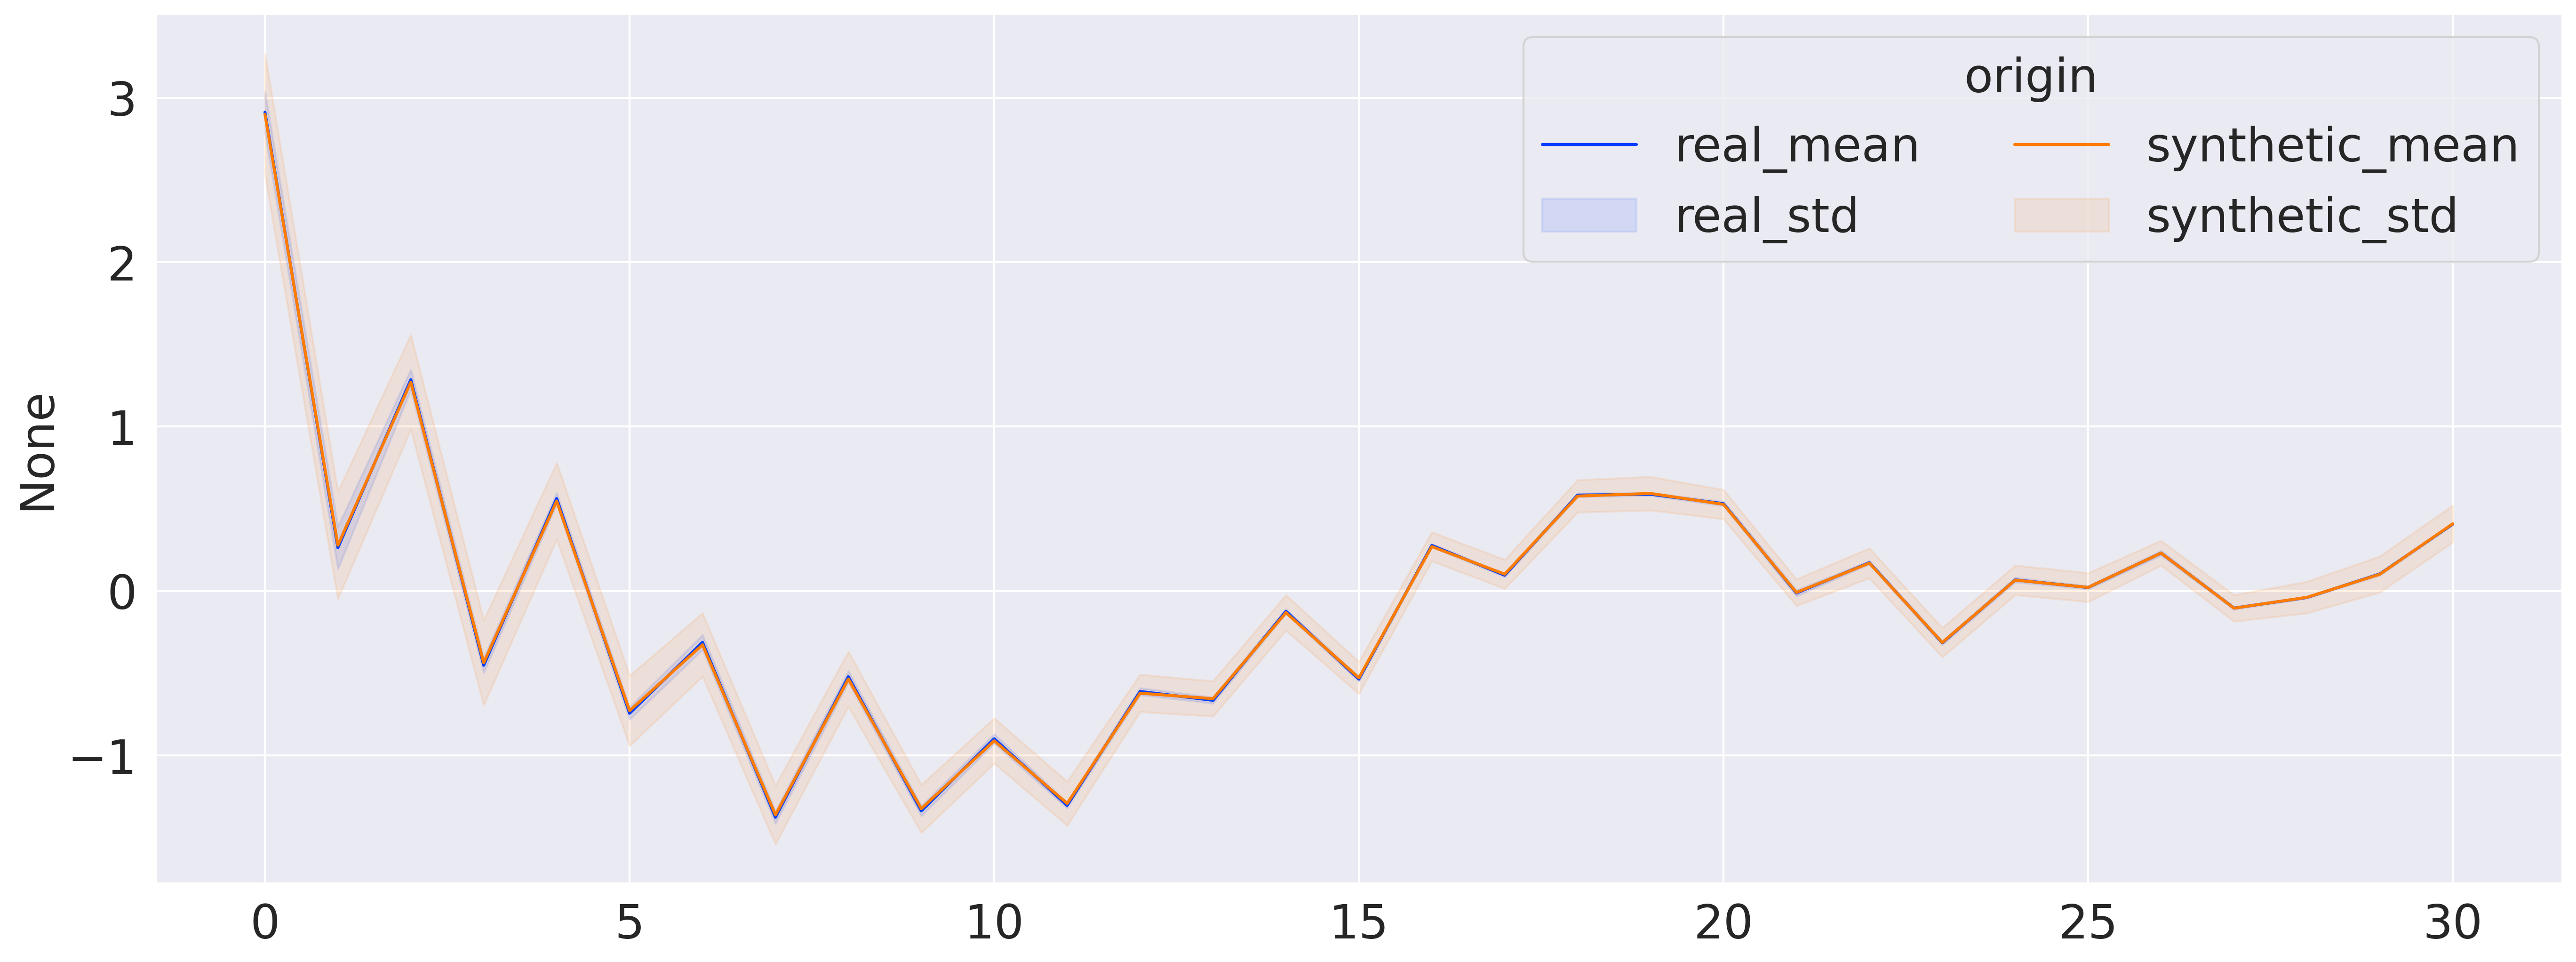

In [14]:
from plot_utils import plot_classwise_dist

fig = plot_classwise_dist(df=df, label_col=target_col)
fig.gca().legend(ncol=2, loc="best", title=target_col)

## A-B Experiments

In [15]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer
from sklearn.cluster import KMeans

from imblearn.under_sampling import ClusterCentroids
from imblearn.base import FunctionSampler
from imblearn.pipeline import Pipeline

from pipe_utils import build_pipeline, build_filtered_pipeline, build_sampled_pipeline

## Plot some results for overview

In [16]:
def test_feature(feature, n_subgroups=5, samples_per_class=10):
    models = []
    labels = {}

    n_train_samples = int(Xsyn.shape[0] * 0.9)
    models.append([("A", build_pipeline())])
    labels["A"] = f"All data ({n_train_samples})"

    n_classes = len(np.unique(ysyn))
    strgy = dict(zip(range(n_classes), [samples_per_class] * n_classes))
    sampler = ClusterCentroids(
        estimator=KMeans(n_init="auto"),
        sampling_strategy=strgy,
        random_state=random_state,
    )
    estimator = KNeighborsRegressor(n_neighbors=1, leaf_size=1)
    pipeline = build_sampled_pipeline(sampler, estimator)
    models.append([("B", pipeline)])
    labels["B"] = f"CCSampling({samples_per_class * n_classes})"

    value_min = feat_data[feature].min()
    value_max = feat_data[feature].max()
    gap = (value_max - value_min) / (n_subgroups * 25)
    for i, s in enumerate(np.linspace(value_min, value_max - gap, n_subgroups)):
        n_train_samples = (
            ((feat_data[feature] >= s) & (feat_data[feature] <= s + gap))
            .to_numpy()
            .sum()
        )

        fparams = [dict(filter_tag=feature, min_value=s, max_value=s + gap)]
        pipeline = build_filtered_pipeline(fparams, random_state=None)
        models.append([(f"C{i}", pipeline)])
        labels[f"C{i}"] = f"{s:.2e} <= {feature} <= {s+gap:.2e} ({n_train_samples})"

    scoring = get_real_regression_scoring()
    X_sext = feat_data.copy()
    X_sext["X"] = list(Xsyn)
 
    # add dummy columns to real data for later concatination with syn data
    X_rext = pd.DataFrame(
        [["", -1, -1, -1, -1, -1, -1, -1, -1, -1]] * len(Xreal), columns=FEATURE_LIST
    )
    X_rext["X"] = list(Xreal)

    results = conduct_ab_mixed_reg_experiment(
        Xsyn=X_sext,
        ysyn=ysyn,
        Xreal=X_rext,
        yreal=yreal,
        estimators=models,
        n_splits=32,
        test_size=0.1,
        scoring=scoring,
        random_state=random_state,
    )

    plot_metrics(
        extract_metrics(
            results, ["test_mse_0.0_40.0", "test_mse_2.5_40.0", "test_mse_5.0_40.0"]
        )
    )
    plt.tight_layout()
    plt.show()

    shm_scoring = SHM_Scoring()
    plot_metrics(extract_metrics(results, shm_scoring.REAL_MSE_RESULTS))
    plt.gca().get_legend().remove()
    plt.show()

    plot_metrics(extract_metrics(results, shm_scoring.REAL_REL_ERROR))
    plt.gca().get_legend().remove()
    plt.show()

    print(labels)
    return results

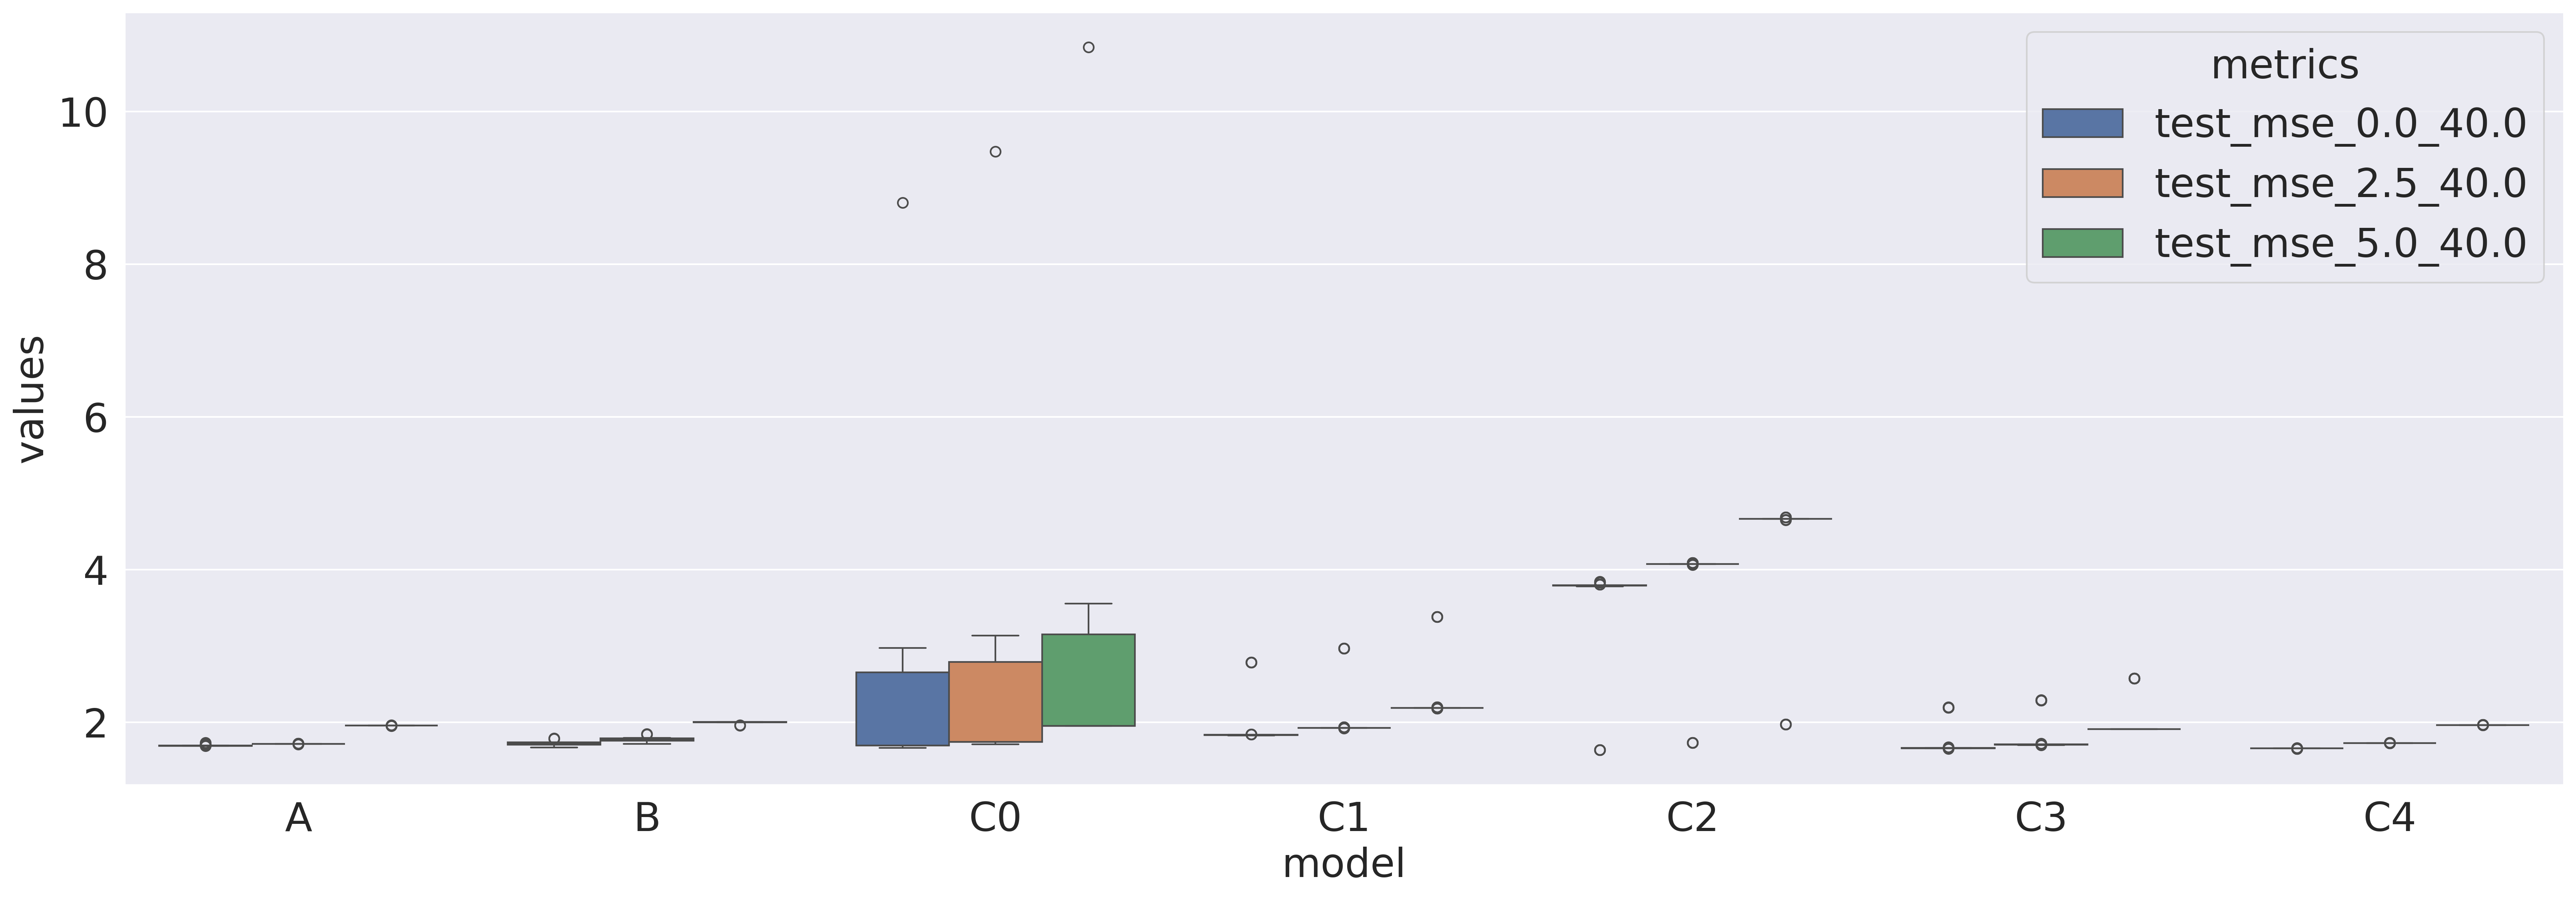

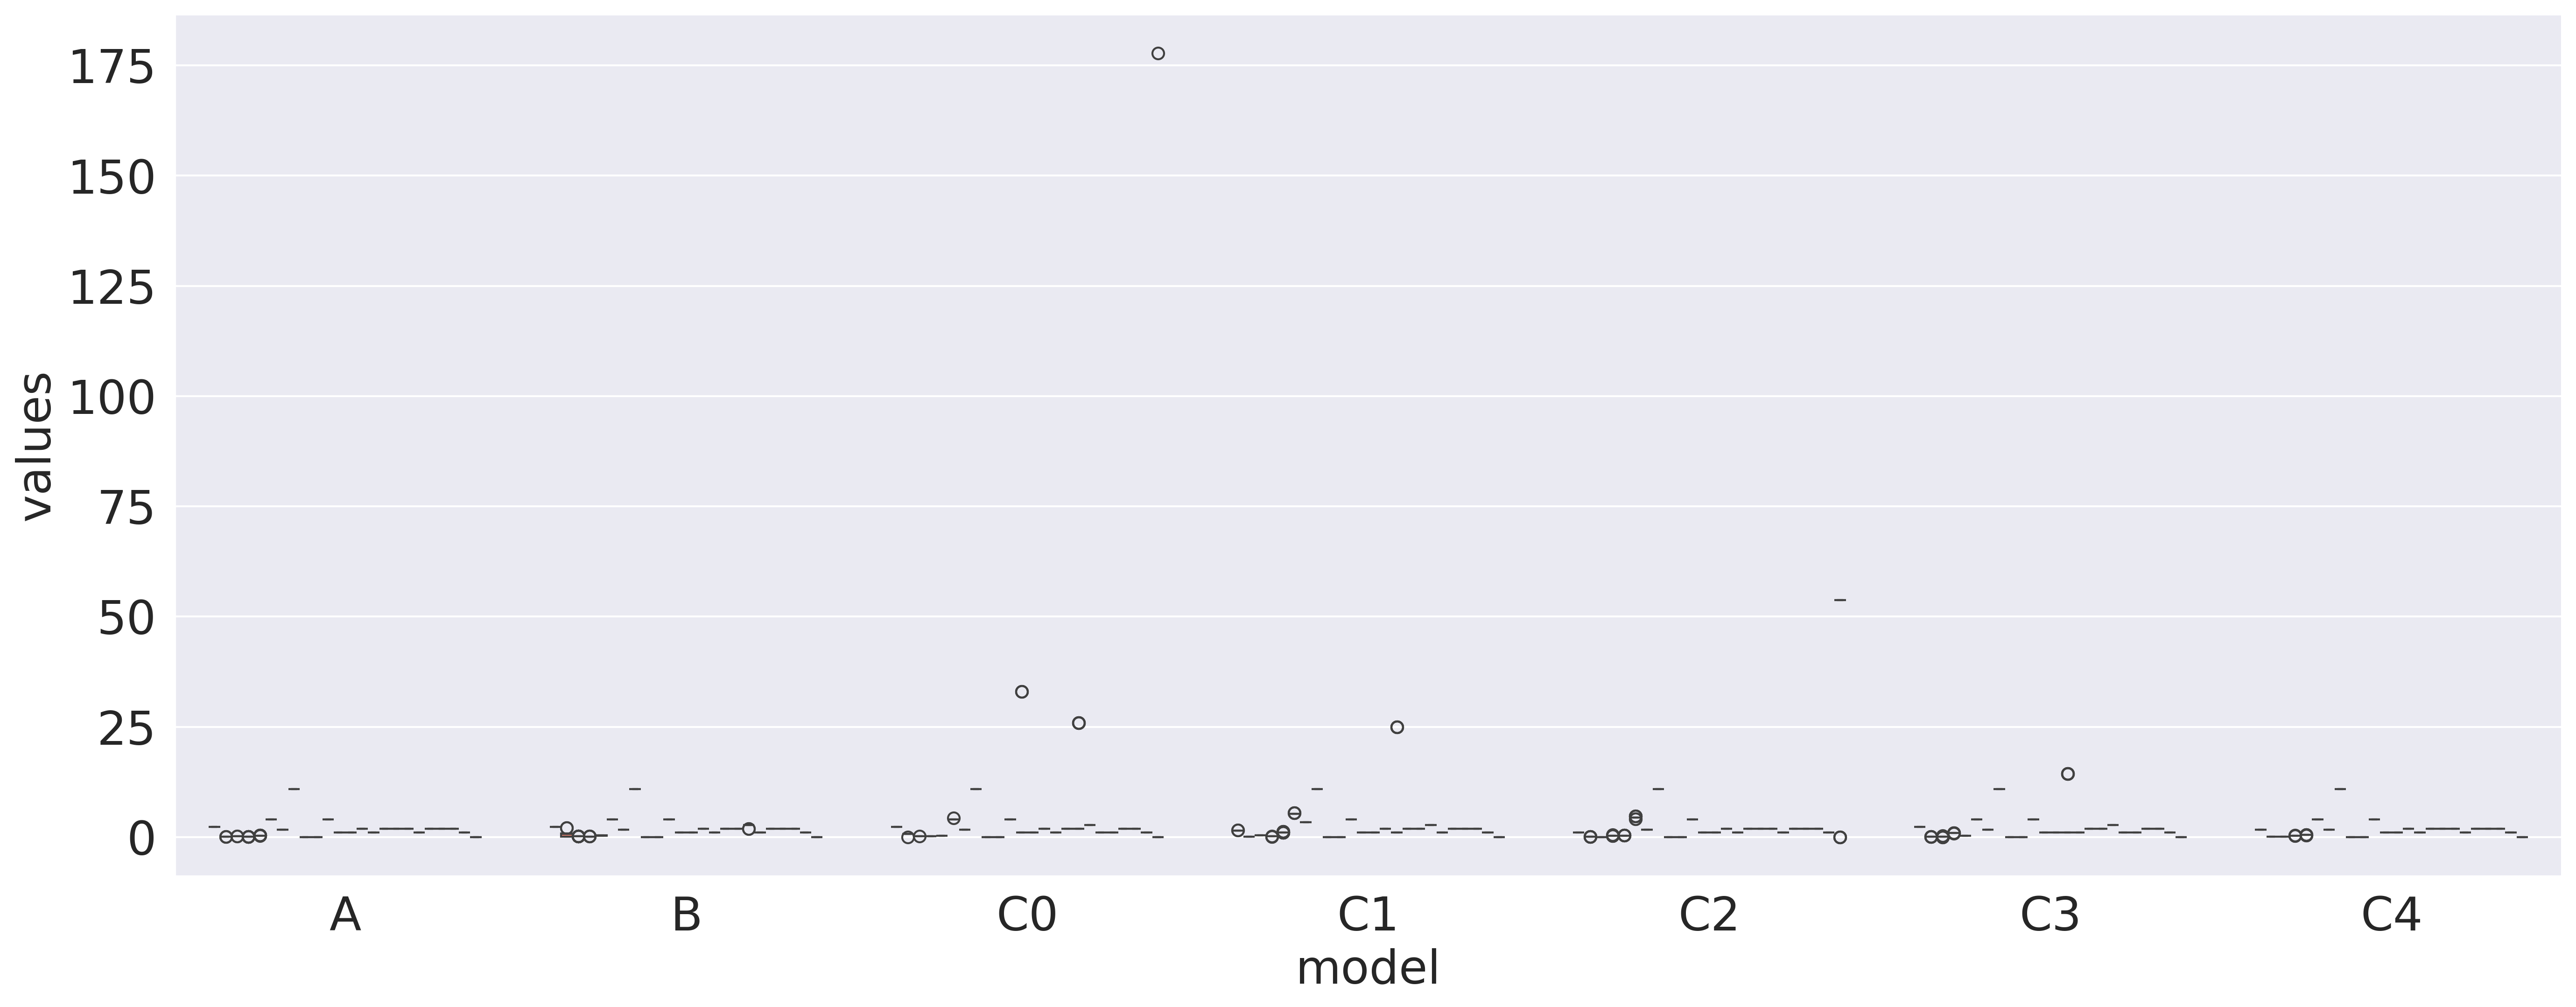

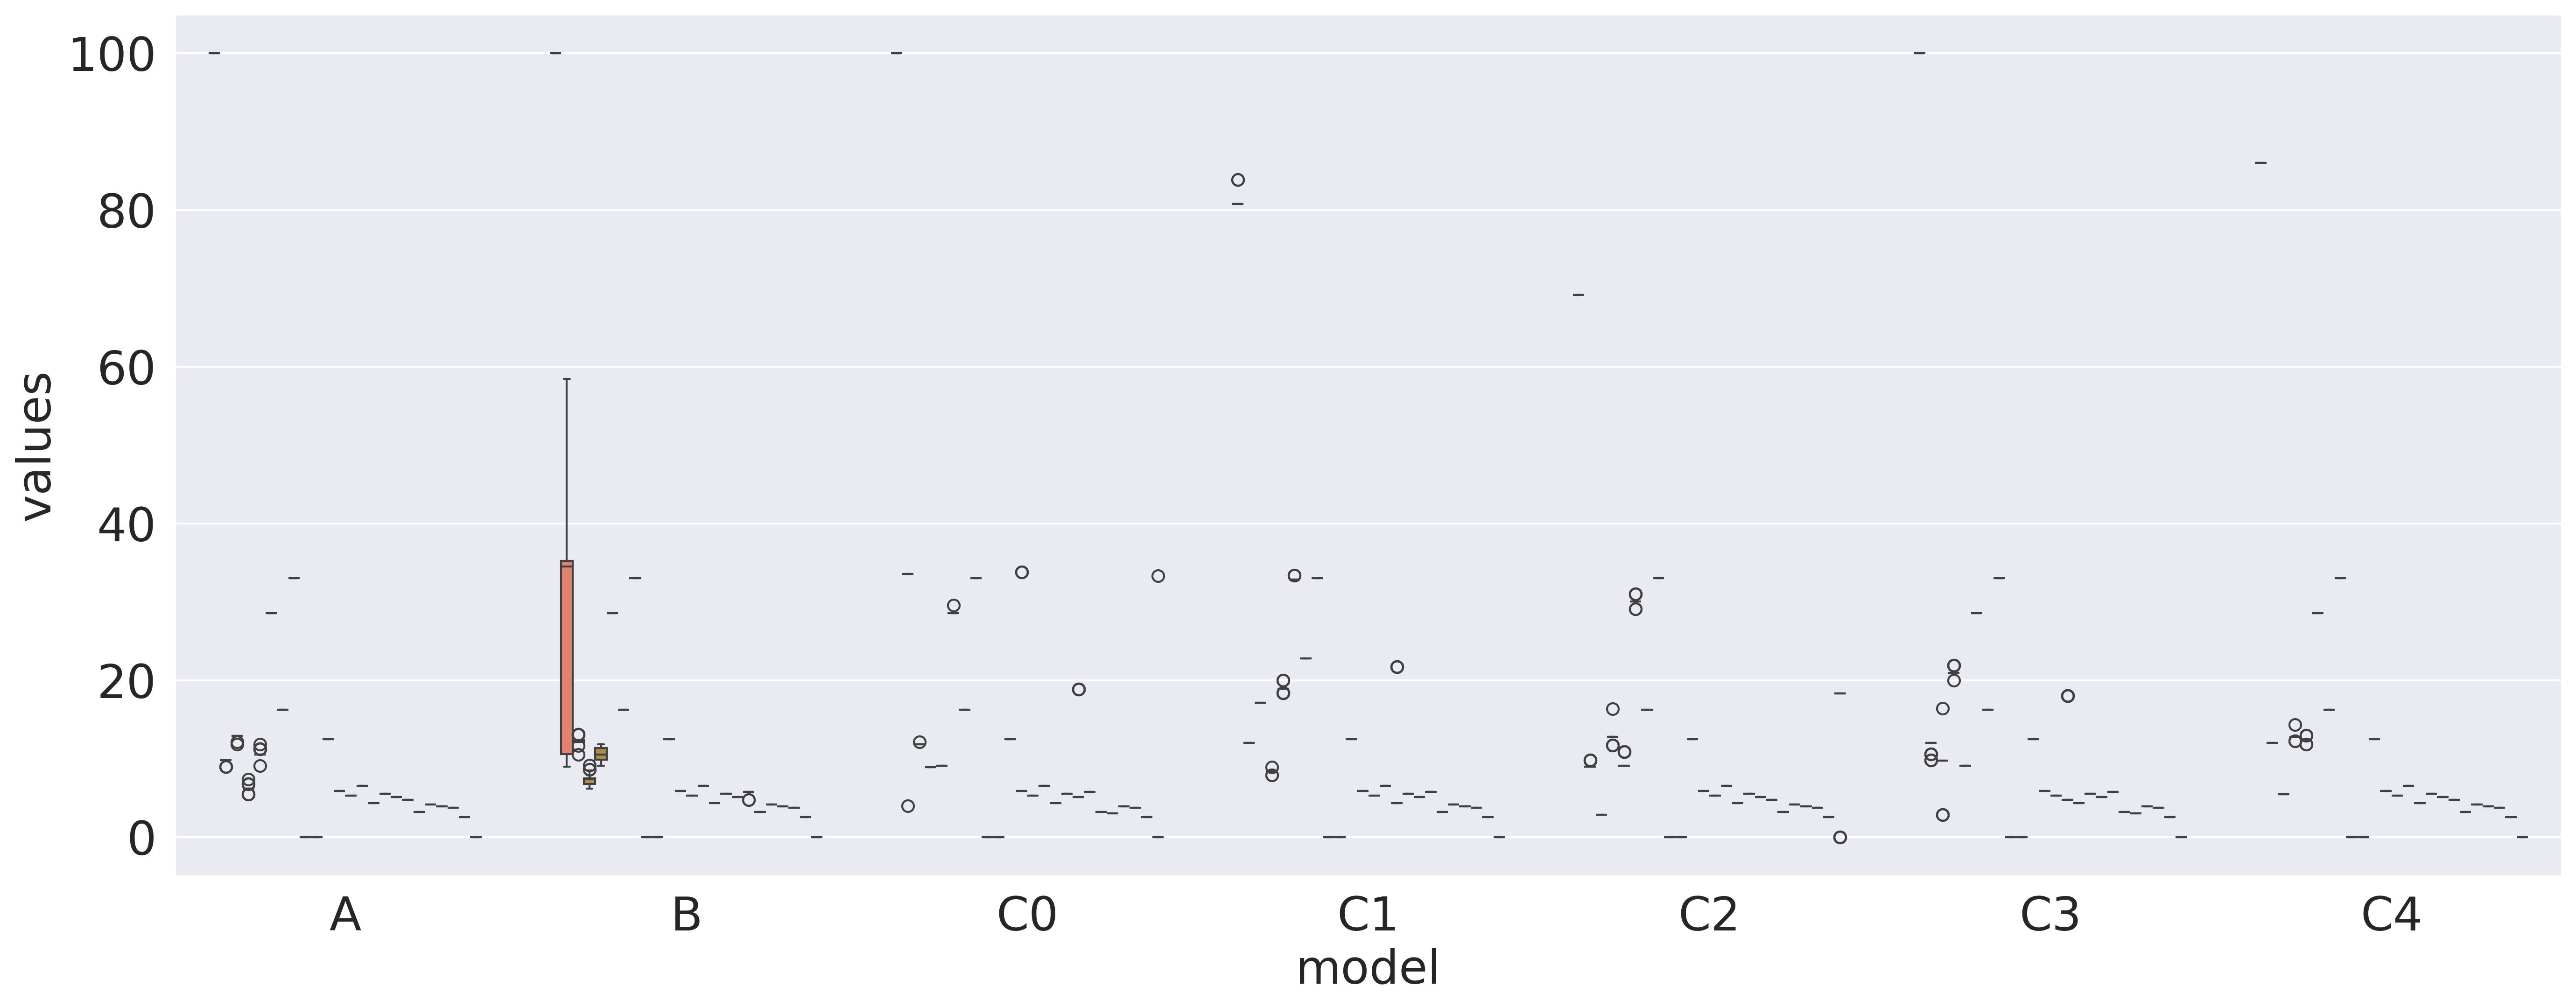

{
    'A': 'All data (25471)',
    'B': 'CCSampling(290)',
    'C0': '1.25e-04 <= y_sdv_fl <= 5.23e-04 (284)',
    'C1': '1.25e-02 <= y_sdv_fl <= 1.29e-02 (138)',
    'C2': '2.48e-02 <= y_sdv_fl <= 2.52e-02 (289)',
    'C3': '3.71e-02 <= y_sdv_fl <= 3.75e-02 (141)',
    'C4': '4.95e-02 <= y_sdv_fl <= 4.99e-02 (288)'
}

fit_time  score_time  test_r2 avg  test_neg_mean_squared_error avg  \
0    0.089573    0.058464     0.989396                        -1.687200   
1    0.114559    0.059567     0.989239                        -1.712178   
2    0.111753    0.056984     0.989368                        -1.691733   
3    0.039305    0.036976     0.989104                        -1.733689   
4    0.040766    0.036838     0.989364                        -1.692400   
..        ...         ...          ...                              ...   
219  0.020361    0.032189     0.989595                        -1.655556   
220  0.023464    0.032797     0.989584                        -1.657289   
221  0.023026    0.033094     0.989595                        -1.655556   
222  0.023411    0.032795     0.989595                        -1.655556   
223  0.019485    0.032453     0.989595                        -1.655556   

     test_r2_0.0  test_r2_1.5  test_r2_2.5  test_r2_3.5  test_r2_4.5  \
0            0.0          0.0          0.0          0.0          0.0   
1            0.0          0.0          0.0          0.0          0.0   
2            0.0          0.0          0.0          0.0          0.0   
3            0.0          0.0          0.0          0.0          0.0   
4            0.0          0.0          0.0          0.0          0.0   
..           ...          ...          ...          ...          ...   
219          1.0          0.0          0.0          0.0          0.0   
220          1.0          0.0          0.0          0.0          0.0   
221          1.0          0.0          0.0          0.0          0.0   
222          1.0          0.0          0.0          0.0          0.0   
223          1.0          0.0          0.0          0.0          0.0   

     test_r2_5.5  ...  test_abs_err_23.0  test_abs_err_25.0  \
0            0.0  ...                1.0           1.374369   
1            0.0  ...                1.0           1.374369   
2            0.0  ...                1.0           1.374369   
3            0.0  ...                1.0           1.374369   
4            0.0  ...                1.0           1.374369   
..           ...  ...                ...                ...   
219          0.0  ...                1.0           1.374369   
220          0.0  ...                1.0           1.374369   
221          0.0  ...                1.0           1.374369   
222          0.0  ...                1.0           1.374369   
223          0.0  ...                1.0           1.374369   

     test_abs_err_27.0  test_abs_err_29.0  test_abs_err_31.0  \
0             1.374369           1.374369                1.0   
1             1.374369           1.374369                1.0   
2             1.374369           1.374369                1.0   
3             1.374369           1.374369                1.0   
4             1.374369           1.374369                1.0   
..                 ...                ...                ...   
219           1.374369           1.374369                1.0   
220           1.374369           1.374369                1.0   
221           1.374369           1.374369                1.0   
222           1.374369           1.374369                1.0   
223           1.374369           1.374369                1.0   

     test_abs_err_33.0  test_abs_err_35.0  test_abs_err_37.0  \
0             1.374369           1.374369           1.374369   
1             1.374369           1.374369           1.374369   
2             1.374369           1.374369           1.374369   
3             1.374369           1.374369           1.374369   
4             1.374369           1.374369           1.374369   
..                 ...                ...                ...   
219           1.374369           1.374369           1.374369   
220           1.374369           1.374369           1.374369   
221           1.374369           1.374369           1.374369   
222           1.374369           1.374369           1.374369   
223      

In [17]:
test_feature("y_sdv_fl")

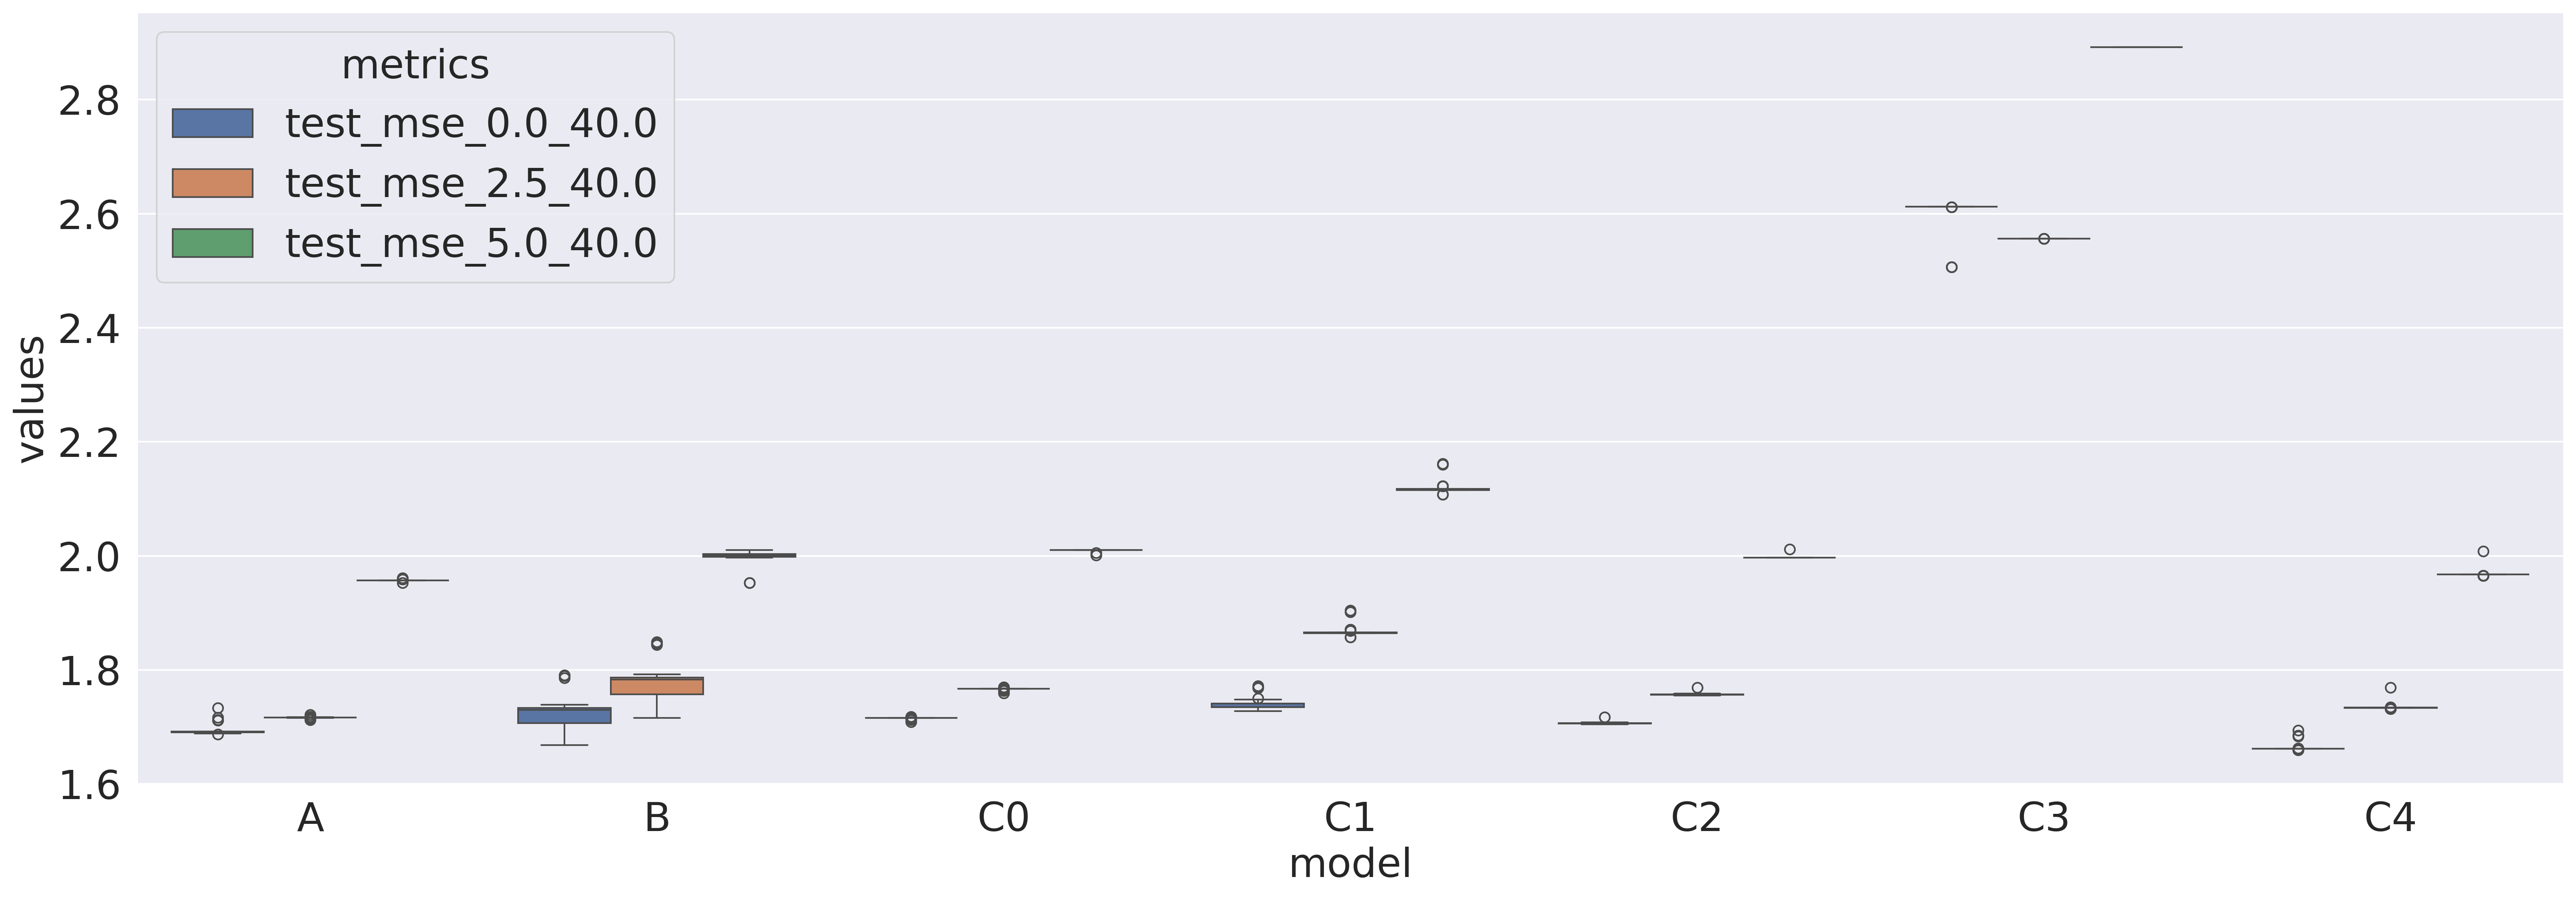

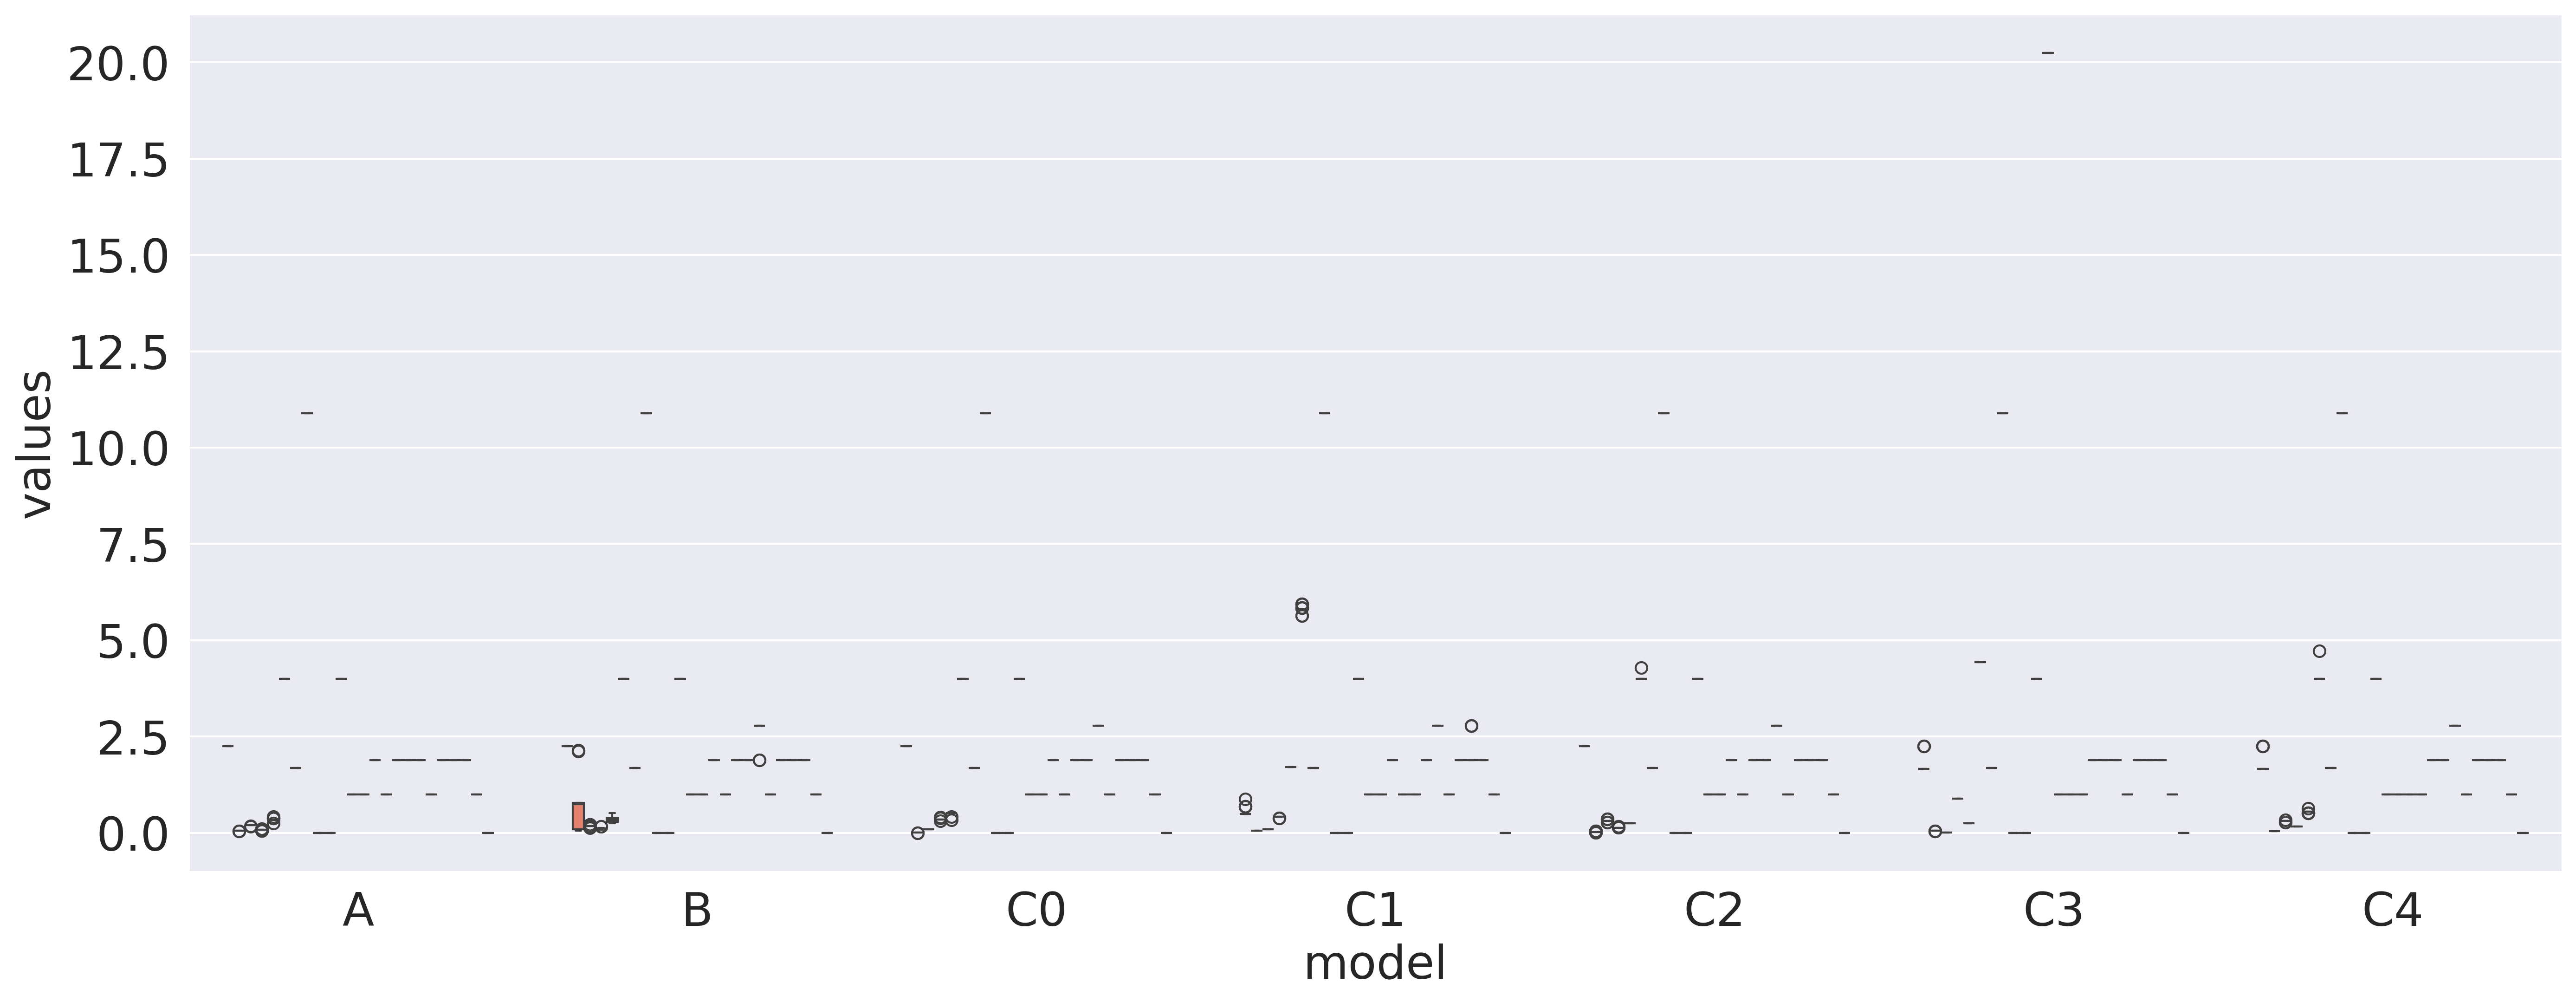

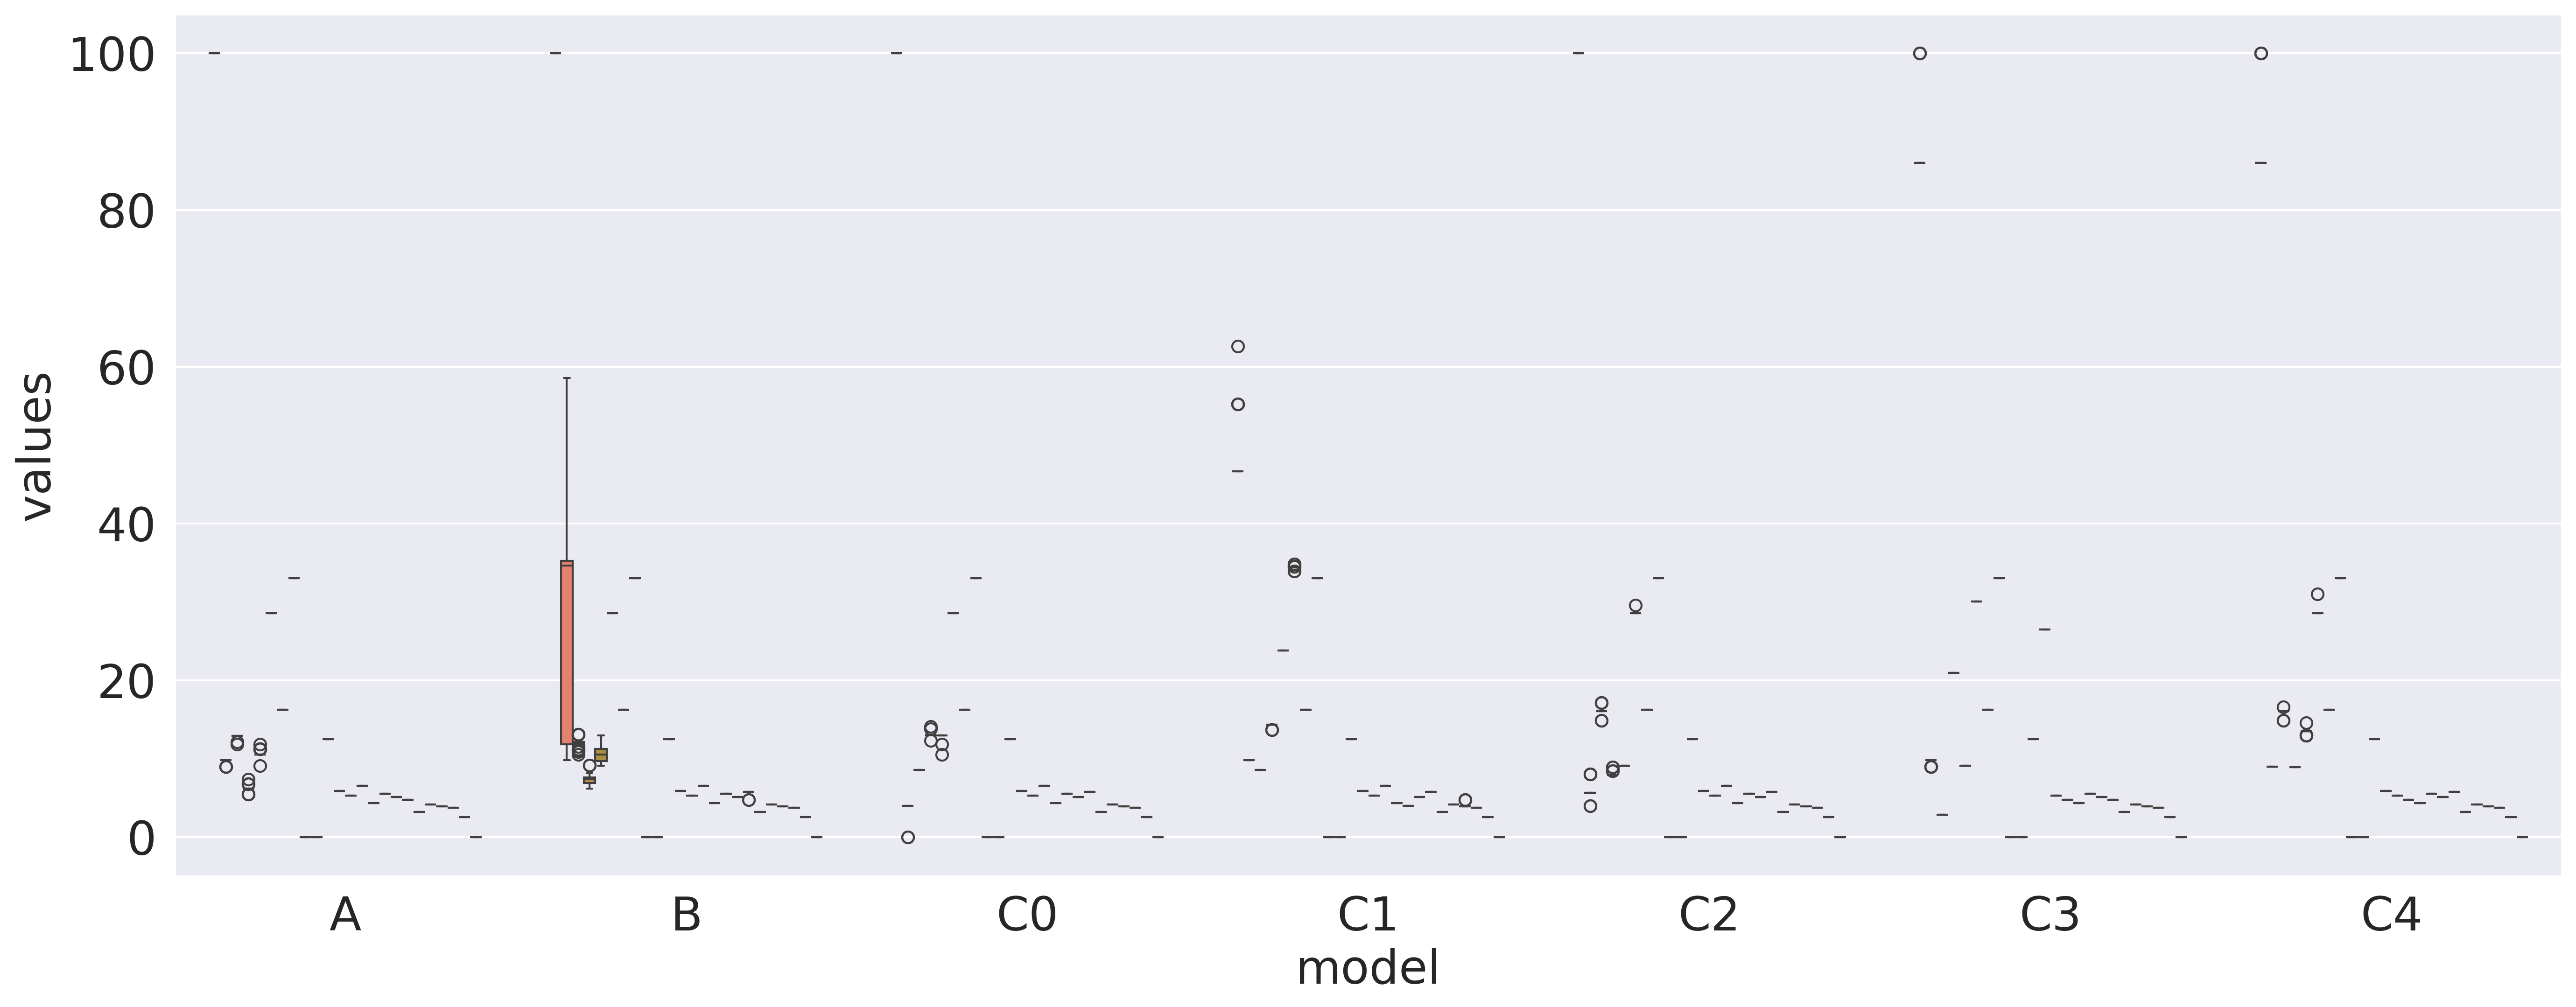

{
    'A': 'All data (25471)',
    'B': 'CCSampling(290)',
    'C0': '1.25e-04 <= y_sdv_core <= 5.23e-04 (286)',
    'C1': '1.25e-02 <= y_sdv_core <= 1.29e-02 (139)',
    'C2': '2.48e-02 <= y_sdv_core <= 2.52e-02 (282)',
    'C3': '3.71e-02 <= y_sdv_core <= 3.75e-02 (144)',
    'C4': '4.95e-02 <= y_sdv_core <= 4.99e-02 (282)'
}

fit_time  score_time  test_r2 avg  test_neg_mean_squared_error avg  \
0    0.039057    0.034816     0.989396                        -1.687200   
1    0.037756    0.033735     0.989239                        -1.712178   
2    0.037609    0.034013     0.989368                        -1.691733   
3    0.039914    0.034277     0.989104                        -1.733689   
4    0.039363    0.035140     0.989364                        -1.692400   
..        ...         ...          ...                              ...   
219  0.021346    0.034178     0.989556                        -1.661778   
220  0.020901    0.032562     0.989419                        -1.683511   
221  0.020568    0.032830     0.989550                        -1.662667   
222  0.021333    0.034236     0.989556                        -1.661778   
223  0.018965    0.032325     0.989354                        -1.693911   

     test_r2_0.0  test_r2_1.5  test_r2_2.5  test_r2_3.5  test_r2_4.5  \
0            0.0          0.0          0.0          0.0          0.0   
1            0.0          0.0          0.0          0.0          0.0   
2            0.0          0.0          0.0          0.0          0.0   
3            0.0          0.0          0.0          0.0          0.0   
4            0.0          0.0          0.0          0.0          0.0   
..           ...          ...          ...          ...          ...   
219          1.0          0.0          0.0          0.0          0.0   
220          1.0          0.0          0.0          0.0          0.0   
221          1.0          0.0          0.0          0.0          0.0   
222          1.0          0.0          0.0          0.0          0.0   
223          1.0          0.0          0.0          0.0          0.0   

     test_r2_5.5  ...  test_abs_err_23.0  test_abs_err_25.0  \
0            0.0  ...                1.0           1.374369   
1            0.0  ...                1.0           1.374369   
2            0.0  ...                1.0           1.374369   
3            0.0  ...                1.0           1.374369   
4            0.0  ...                1.0           1.374369   
..           ...  ...                ...                ...   
219          0.0  ...                1.0           1.374369   
220          0.0  ...                1.0           1.374369   
221          0.0  ...                1.0           1.374369   
222          0.0  ...                1.0           1.374369   
223          0.0  ...                1.0           1.374369   

     test_abs_err_27.0  test_abs_err_29.0  test_abs_err_31.0  \
0             1.374369           1.374369                1.0   
1             1.374369           1.374369                1.0   
2             1.374369           1.374369                1.0   
3             1.374369           1.374369                1.0   
4             1.374369           1.374369                1.0   
..                 ...                ...                ...   
219           1.374369           1.666667                1.0   
220           1.374369           1.666667                1.0   
221           1.374369           1.666667                1.0   
222           1.374369           1.666667                1.0   
223           1.374369           1.666667                1.0   

     test_abs_err_33.0  test_abs_err_35.0  test_abs_err_37.0  \
0             1.374369           1.374369           1.374369   
1             1.374369           1.374369           1.374369   
2             1.374369           1.374369           1.374369   
3             1.374369           1.374369           1.374369   
4             1.374369           1.374369           1.374369   
..                 ...                ...                ...   
219           1.374369           1.374369           1.374369   
220           1.374369           1.374369           1.374369   
221           1.374369           1.374369           1.374369   
222           1.374369           1.374369           1.374369   
223      

In [18]:
test_feature("y_sdv_core")

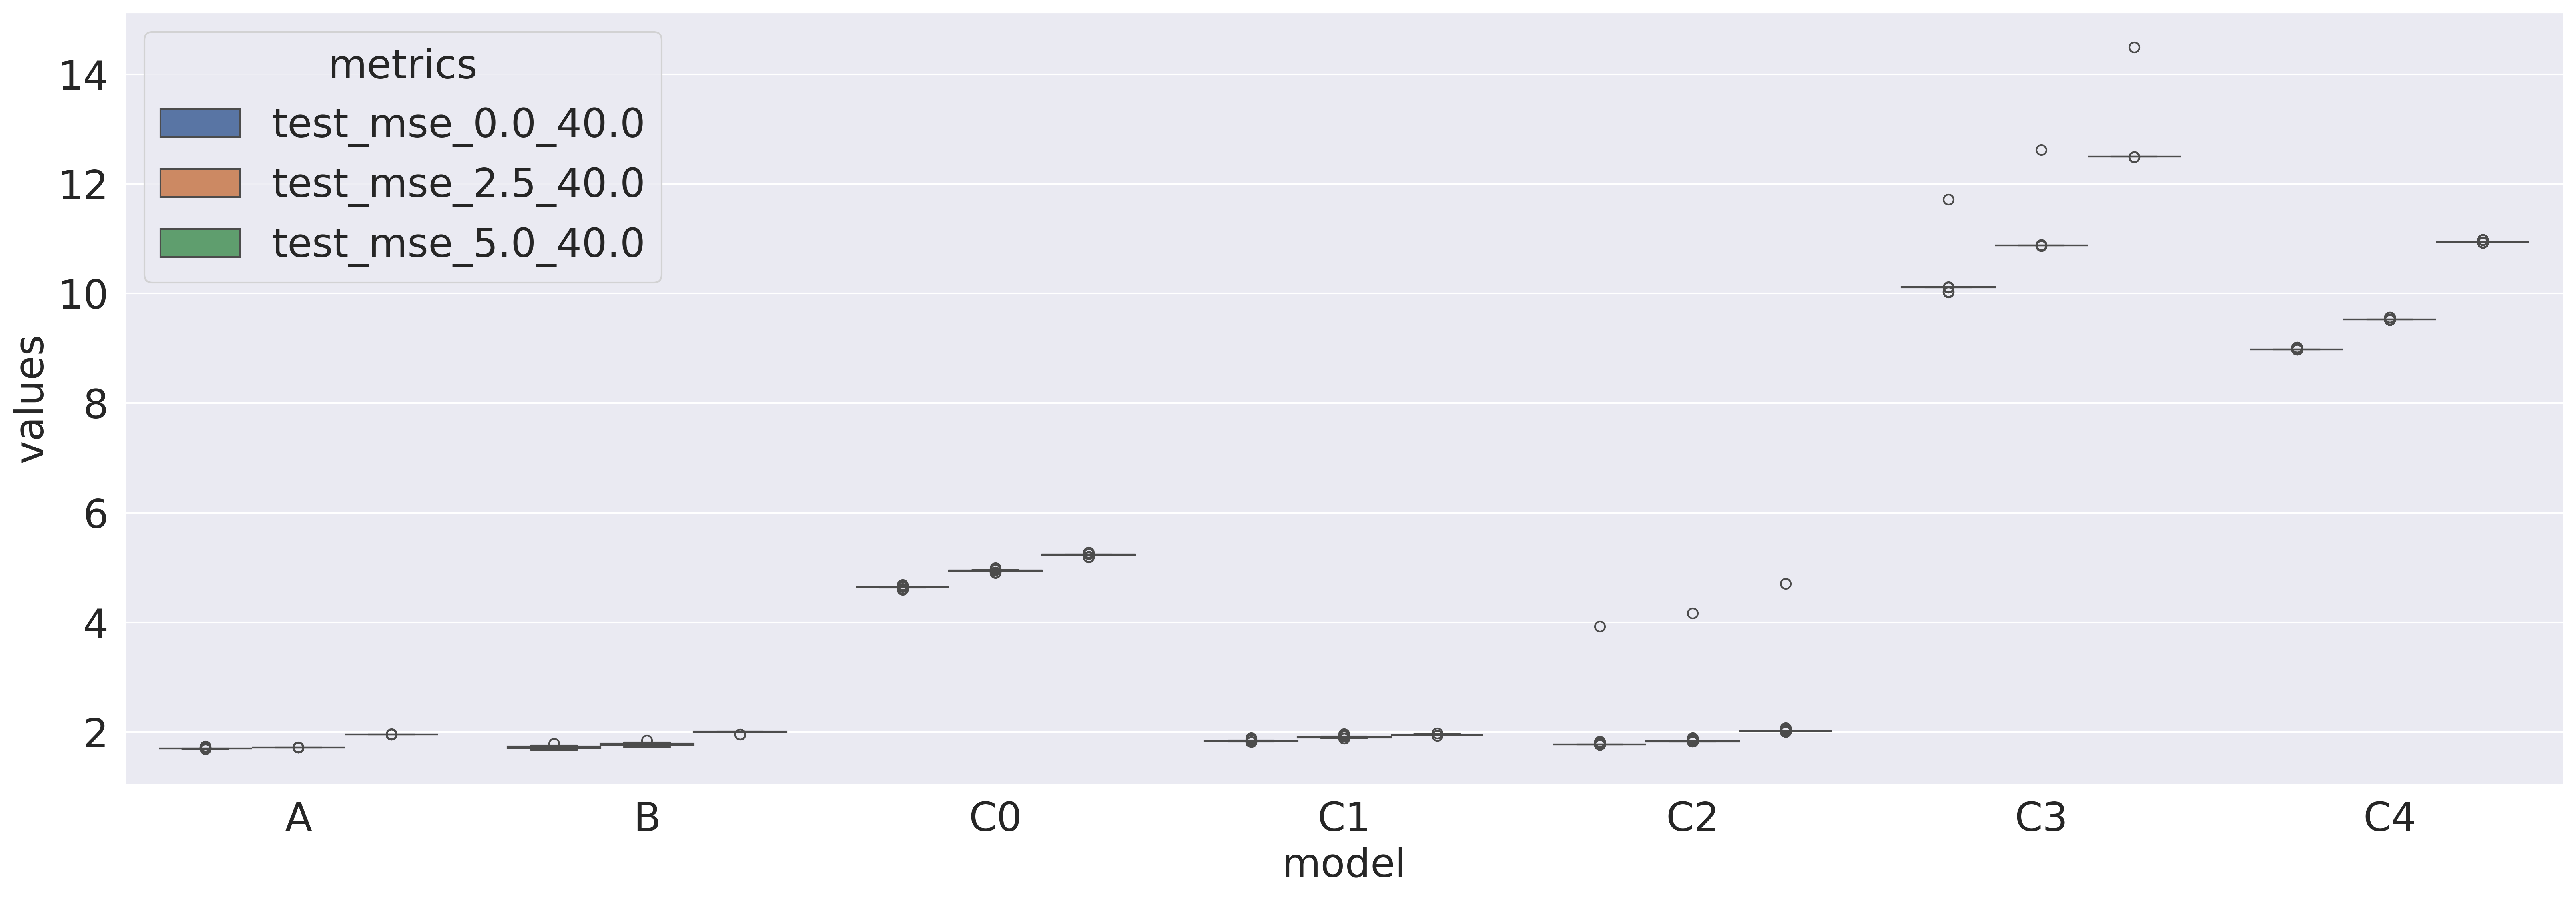

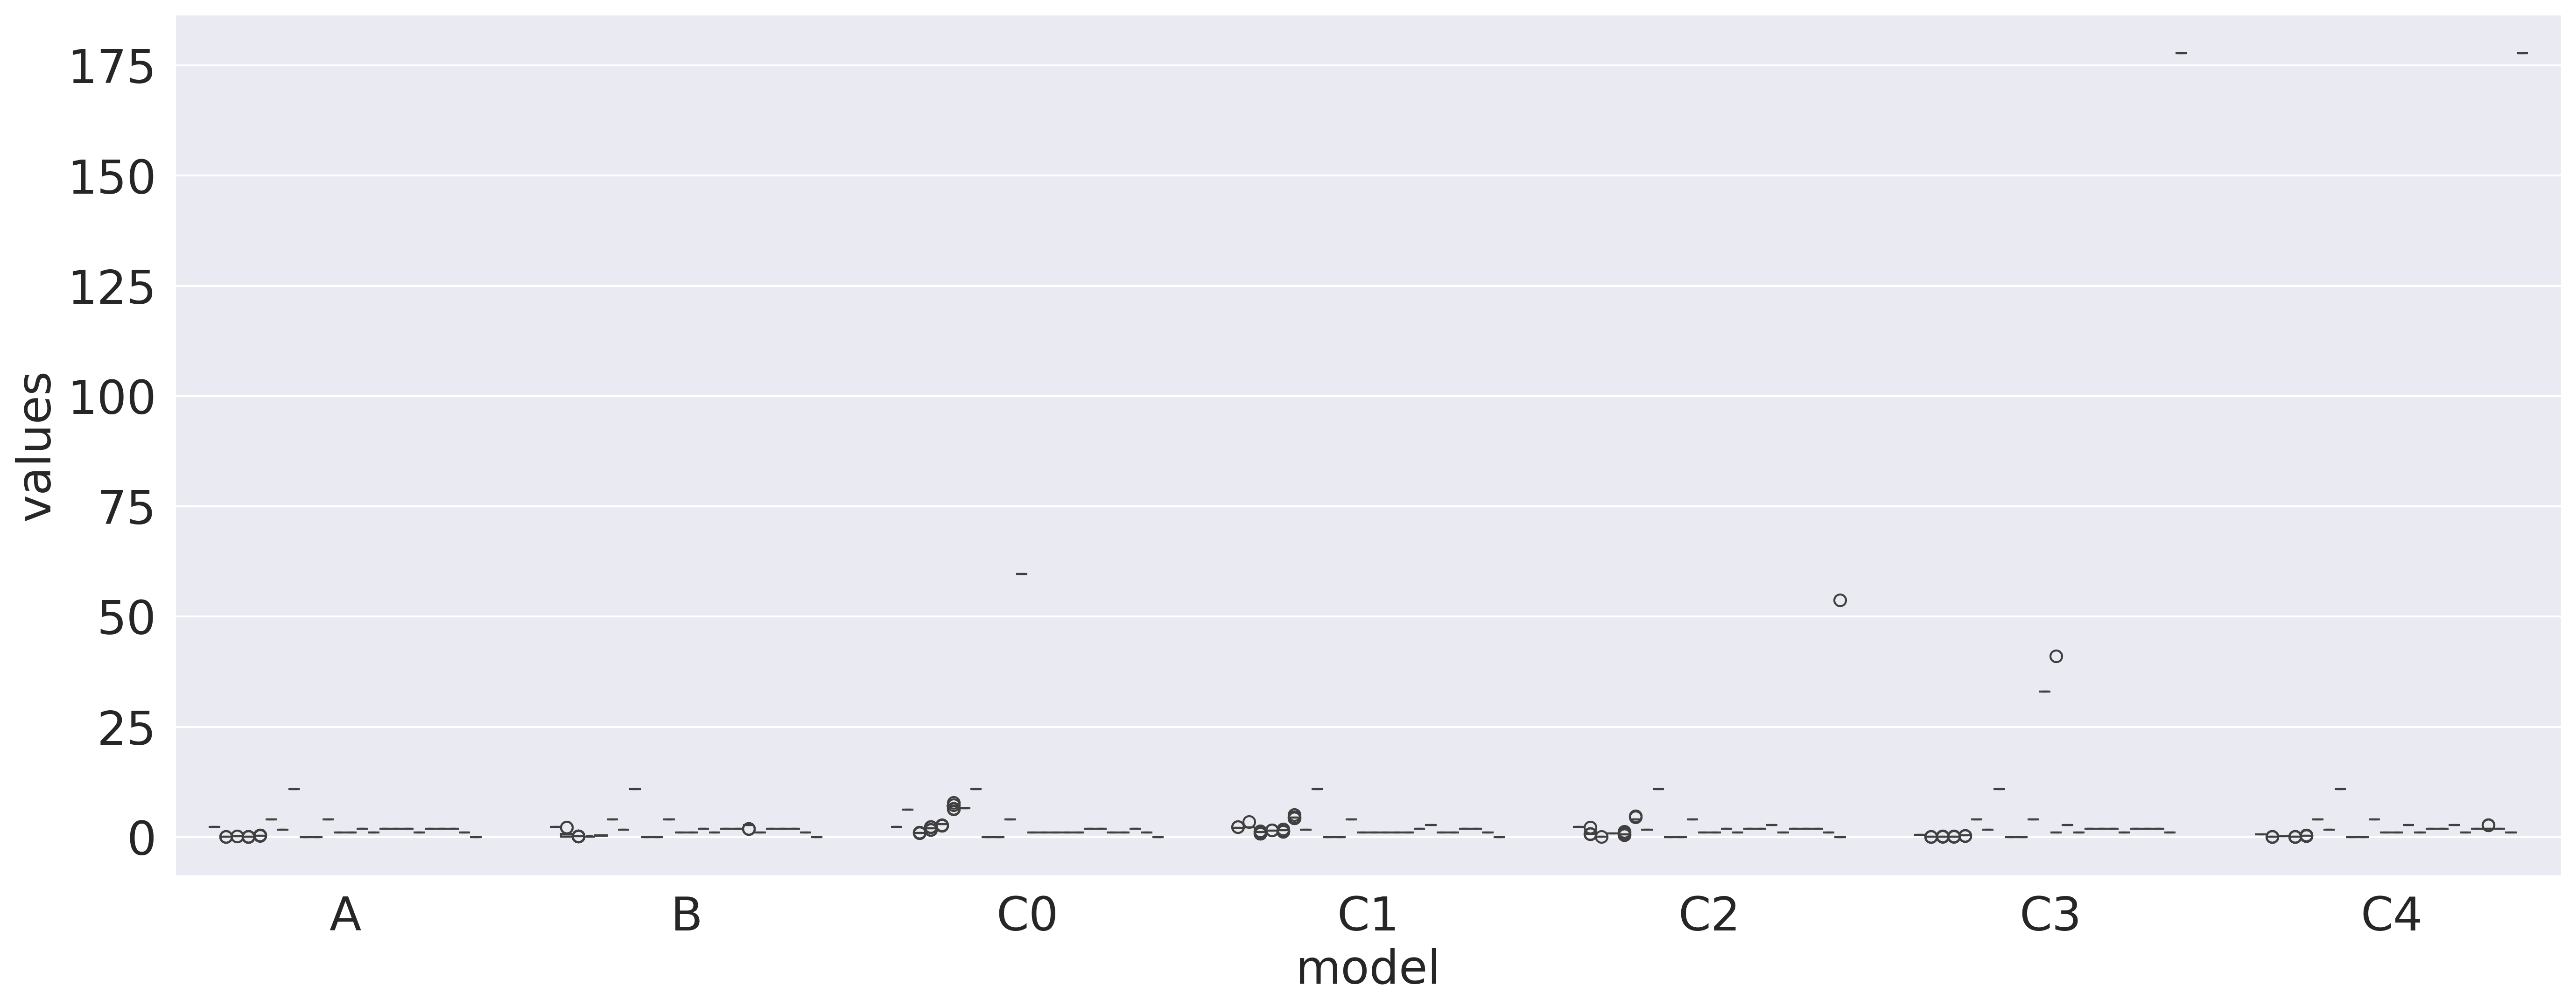

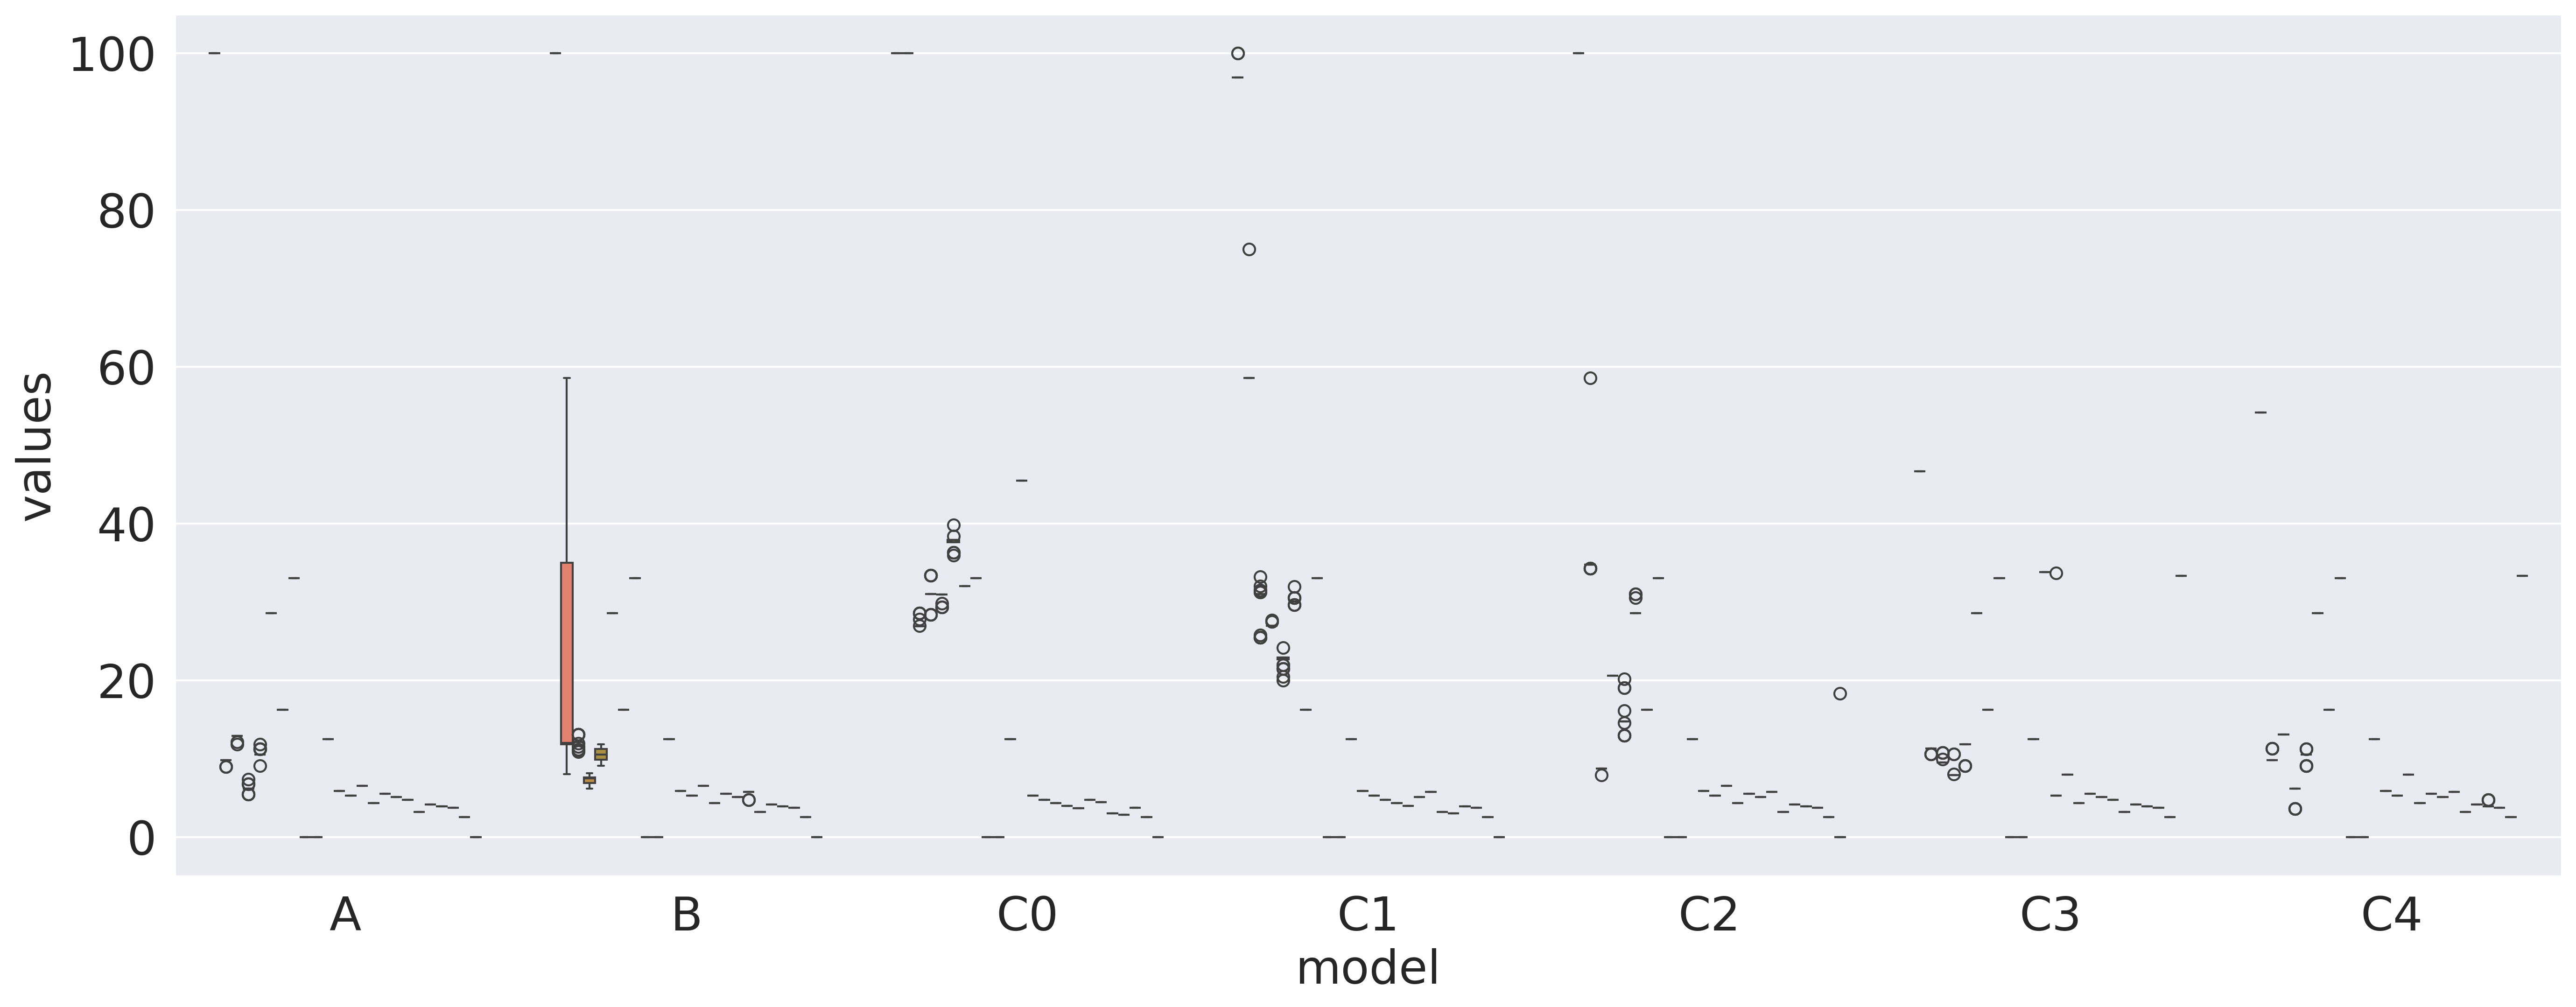

{
    'A': 'All data (25471)',
    'B': 'CCSampling(290)',
    'C0': '8.00e-01 <= y_dens_core <= 8.03e-01 (280)',
    'C1': '8.99e-01 <= y_dens_core <= 9.03e-01 (141)',
    'C2': '9.98e-01 <= y_dens_core <= 1.00e+00 (283)',
    'C3': '1.10e+00 <= y_dens_core <= 1.10e+00 (141)',
    'C4': '1.20e+00 <= y_dens_core <= 1.20e+00 (286)'
}

fit_time  score_time  test_r2 avg  test_neg_mean_squared_error avg  \
0    0.039010    0.034362     0.989396                        -1.687200   
1    0.043440    0.038367     0.989239                        -1.712178   
2    0.039598    0.033814     0.989368                        -1.691733   
3    0.039376    0.034196     0.989104                        -1.733689   
4    0.039511    0.036571     0.989364                        -1.692400   
..        ...         ...          ...                              ...   
219  0.020231    0.032652     0.943565                        -8.979644   
220  0.020788    0.032946     0.943552                        -8.981644   
221  0.021155    0.032793     0.943329                        -9.017200   
222  0.021280    0.032466     0.943552                        -8.981644   
223  0.019304    0.032890     0.943552                        -8.981644   

     test_r2_0.0  test_r2_1.5  test_r2_2.5  test_r2_3.5  test_r2_4.5  \
0            0.0          0.0          0.0          0.0          0.0   
1            0.0          0.0          0.0          0.0          0.0   
2            0.0          0.0          0.0          0.0          0.0   
3            0.0          0.0          0.0          0.0          0.0   
4            0.0          0.0          0.0          0.0          0.0   
..           ...          ...          ...          ...          ...   
219          0.0          0.0          0.0          0.0          0.0   
220          0.0          0.0          0.0          0.0          0.0   
221          0.0          0.0          0.0          0.0          0.0   
222          0.0          0.0          0.0          0.0          0.0   
223          0.0          0.0          0.0          0.0          0.0   

     test_r2_5.5  ...  test_abs_err_23.0  test_abs_err_25.0  \
0            0.0  ...                1.0           1.374369   
1            0.0  ...                1.0           1.374369   
2            0.0  ...                1.0           1.374369   
3            0.0  ...                1.0           1.374369   
4            0.0  ...                1.0           1.374369   
..           ...  ...                ...                ...   
219          0.0  ...                1.0           1.374369   
220          0.0  ...                1.0           1.374369   
221          0.0  ...                1.0           1.374369   
222          0.0  ...                1.0           1.374369   
223          0.0  ...                1.0           1.374369   

     test_abs_err_27.0  test_abs_err_29.0  test_abs_err_31.0  \
0             1.374369           1.374369                1.0   
1             1.374369           1.374369                1.0   
2             1.374369           1.374369                1.0   
3             1.374369           1.374369                1.0   
4             1.374369           1.374369                1.0   
..                 ...                ...                ...   
219           1.374369           1.666667                1.0   
220           1.374369           1.666667                1.0   
221           1.374369           1.666667                1.0   
222           1.374369           1.666667                1.0   
223           1.374369           1.666667                1.0   

     test_abs_err_33.0  test_abs_err_35.0  test_abs_err_37.0  \
0             1.374369           1.374369           1.374369   
1             1.374369           1.374369           1.374369   
2             1.374369           1.374369           1.374369   
3             1.374369           1.374369           1.374369   
4             1.374369           1.374369           1.374369   
..                 ...                ...                ...   
219           1.374369           1.374369           1.374369   
220           1.374369           1.374369           1.374369   
221           1.374369           1.666667           1.374369   
222           1.374369           1.374369           1.374369   
223      

In [19]:
test_feature("y_dens_core")

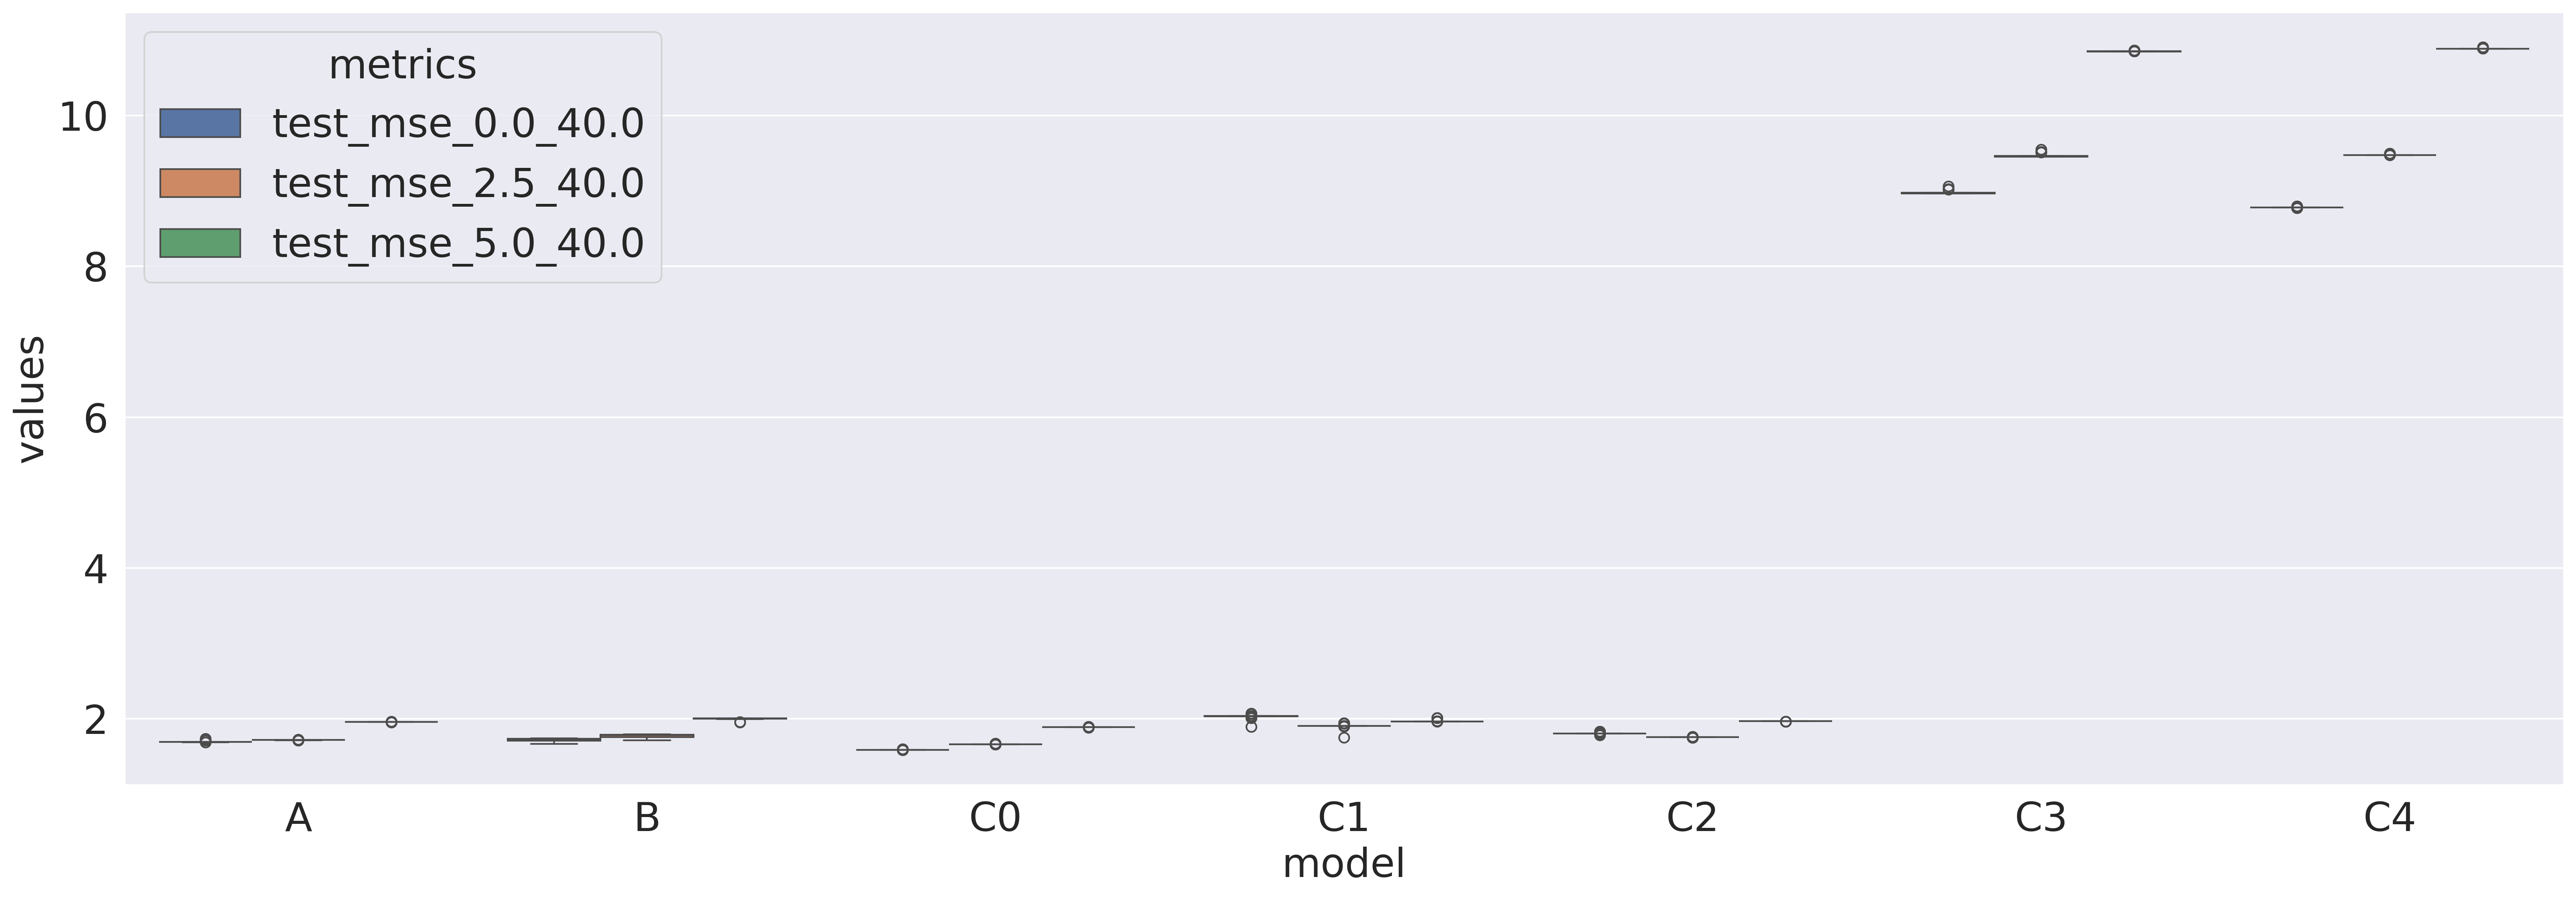

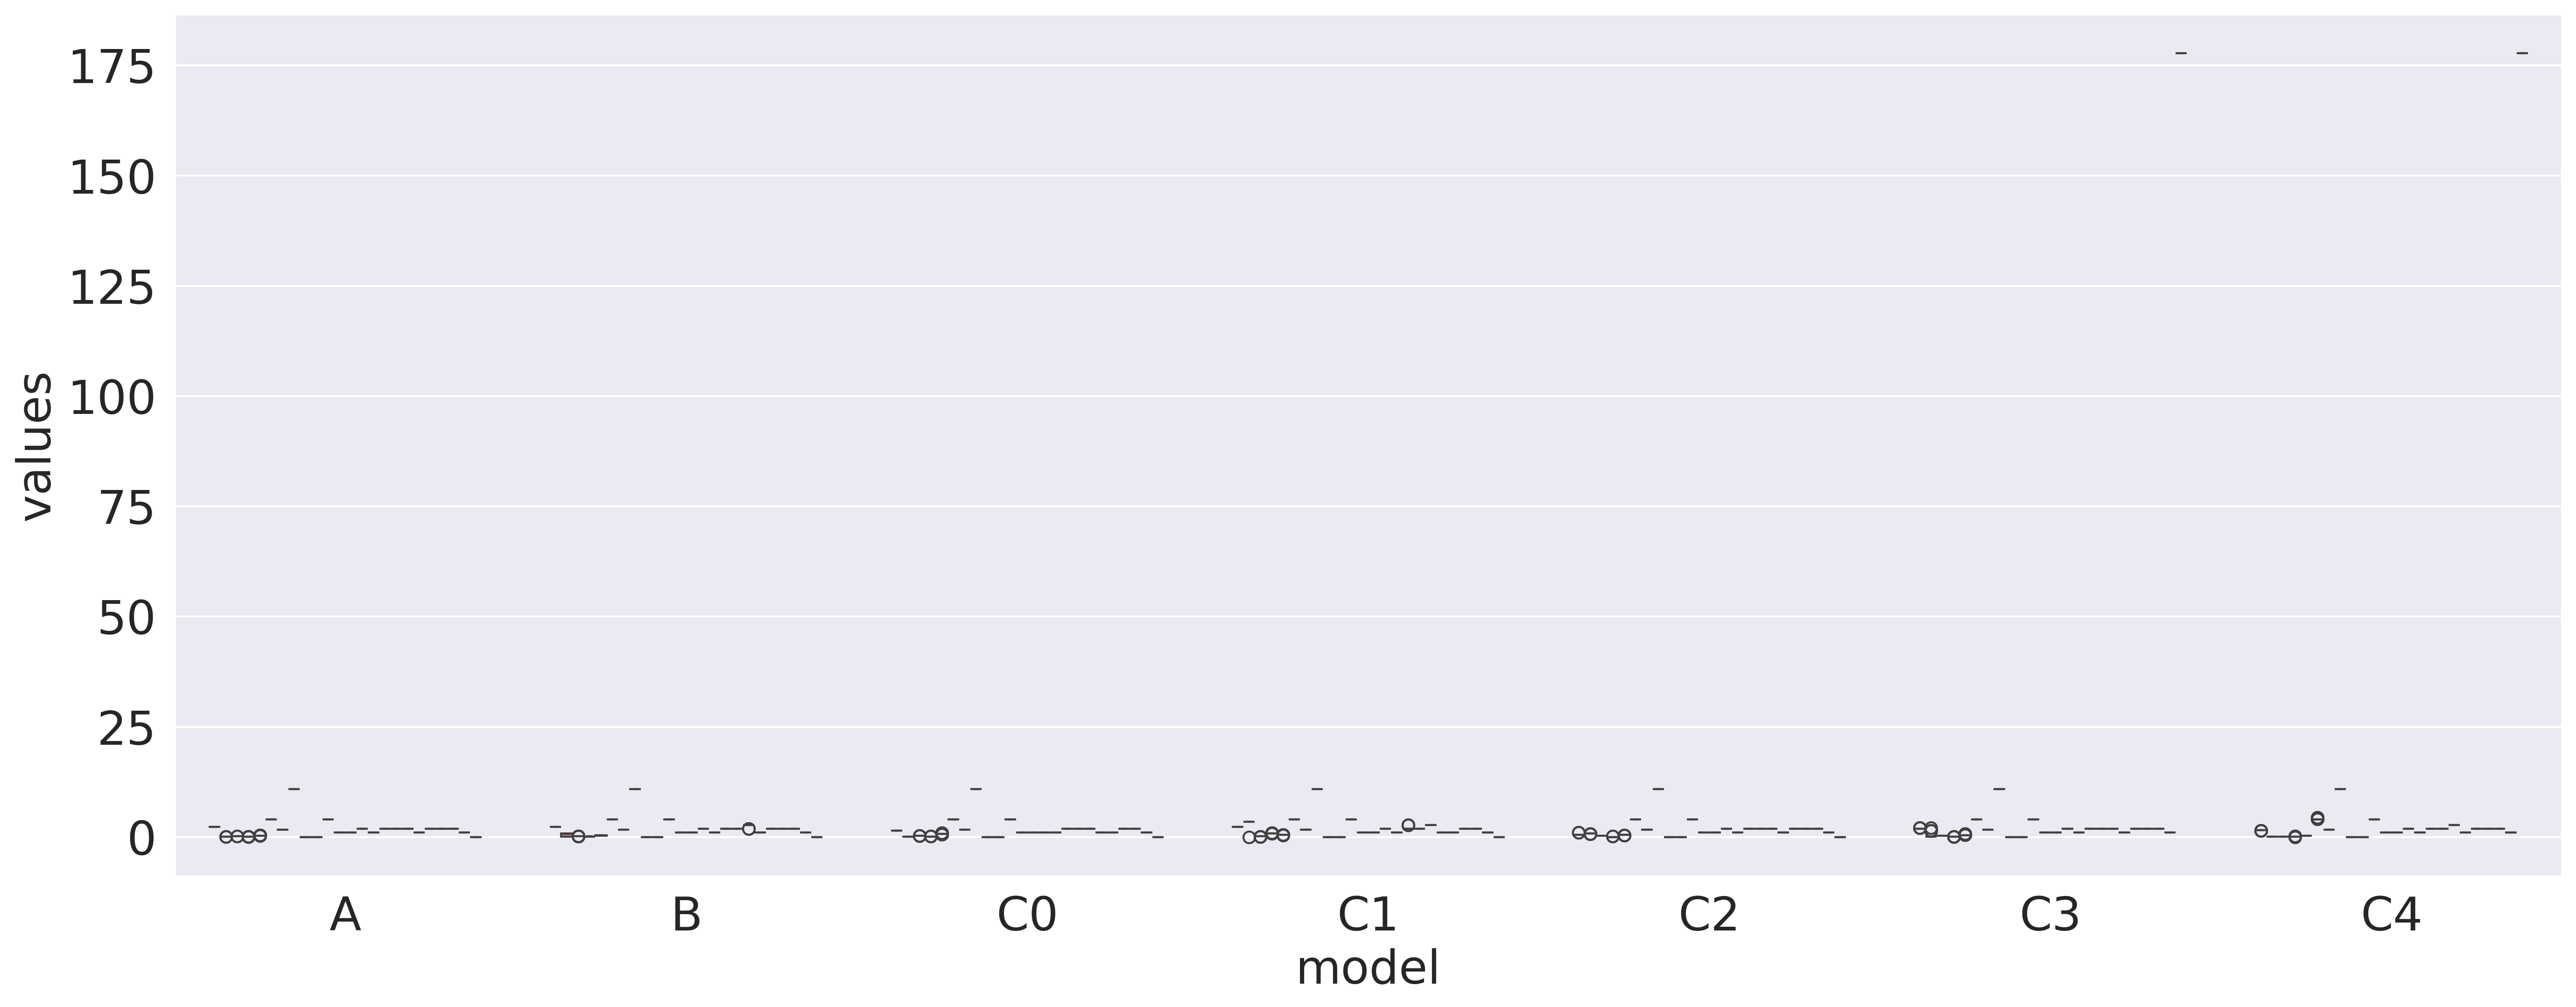

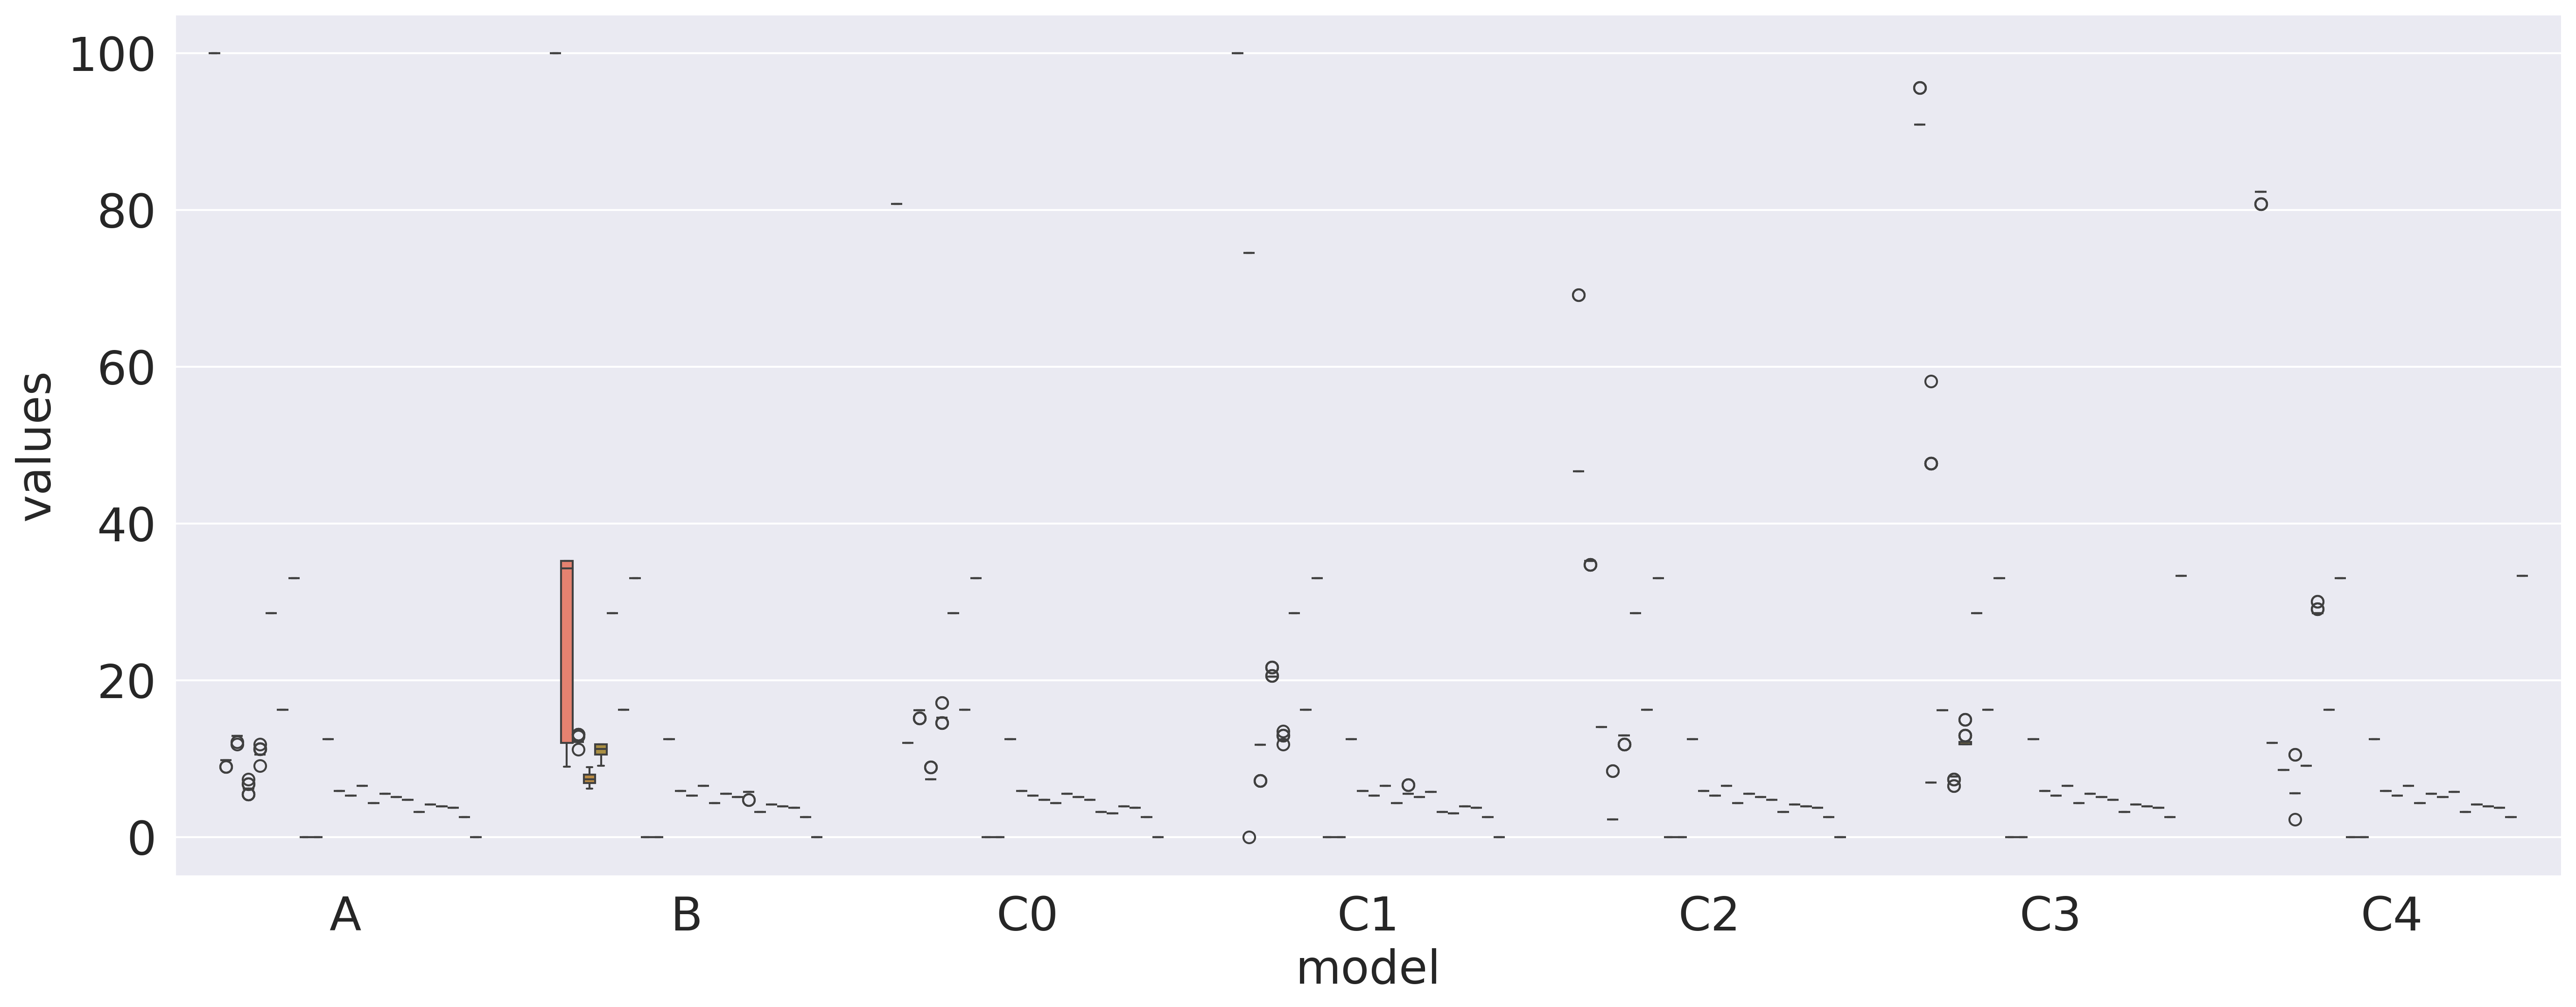

{
    'A': 'All data (25471)',
    'B': 'CCSampling(290)',
    'C0': '9.71e-01 <= y_young_fl <= 9.72e-01 (282)',
    'C1': '9.82e-01 <= y_young_fl <= 9.82e-01 (143)',
    'C2': '9.93e-01 <= y_young_fl <= 9.93e-01 (282)',
    'C3': '1.00e+00 <= y_young_fl <= 1.00e+00 (284)',
    'C4': '1.01e+00 <= y_young_fl <= 1.01e+00 (279)'
}

fit_time  score_time  test_r2 avg  test_neg_mean_squared_error avg  \
0    0.038882    0.033847     0.989396                        -1.687200   
1    0.038298    0.033944     0.989239                        -1.712178   
2    0.038807    0.034882     0.989368                        -1.691733   
3    0.038481    0.033791     0.989104                        -1.733689   
4    0.038794    0.033890     0.989364                        -1.692400   
..        ...         ...          ...                              ...   
219  0.020199    0.032438     0.944823                        -8.779467   
220  0.020380    0.032740     0.944823                        -8.779467   
221  0.021181    0.032636     0.944746                        -8.791600   
222  0.020541    0.032373     0.944787                        -8.785200   
223  0.019604    0.032710     0.944836                        -8.777333   

     test_r2_0.0  test_r2_1.5  test_r2_2.5  test_r2_3.5  test_r2_4.5  \
0            0.0          0.0          0.0          0.0          0.0   
1            0.0          0.0          0.0          0.0          0.0   
2            0.0          0.0          0.0          0.0          0.0   
3            0.0          0.0          0.0          0.0          0.0   
4            0.0          0.0          0.0          0.0          0.0   
..           ...          ...          ...          ...          ...   
219          1.0          0.0          0.0          0.0          0.0   
220          1.0          0.0          0.0          0.0          0.0   
221          1.0          0.0          0.0          0.0          0.0   
222          1.0          0.0          0.0          0.0          0.0   
223          1.0          0.0          0.0          0.0          0.0   

     test_r2_5.5  ...  test_abs_err_23.0  test_abs_err_25.0  \
0            0.0  ...                1.0           1.374369   
1            0.0  ...                1.0           1.374369   
2            0.0  ...                1.0           1.374369   
3            0.0  ...                1.0           1.374369   
4            0.0  ...                1.0           1.374369   
..           ...  ...                ...                ...   
219          0.0  ...                1.0           1.374369   
220          0.0  ...                1.0           1.374369   
221          0.0  ...                1.0           1.374369   
222          0.0  ...                1.0           1.374369   
223          0.0  ...                1.0           1.374369   

     test_abs_err_27.0  test_abs_err_29.0  test_abs_err_31.0  \
0             1.374369           1.374369                1.0   
1             1.374369           1.374369                1.0   
2             1.374369           1.374369                1.0   
3             1.374369           1.374369                1.0   
4             1.374369           1.374369                1.0   
..                 ...                ...                ...   
219           1.374369           1.666667                1.0   
220           1.374369           1.666667                1.0   
221           1.374369           1.666667                1.0   
222           1.374369           1.666667                1.0   
223           1.374369           1.666667                1.0   

     test_abs_err_33.0  test_abs_err_35.0  test_abs_err_37.0  \
0             1.374369           1.374369           1.374369   
1             1.374369           1.374369           1.374369   
2             1.374369           1.374369           1.374369   
3             1.374369           1.374369           1.374369   
4             1.374369           1.374369           1.374369   
..                 ...                ...                ...   
219           1.374369           1.374369           1.374369   
220           1.374369           1.374369           1.374369   
221           1.374369           1.374369           1.374369   
222           1.374369           1.374369           1.374369   
223      

In [20]:
test_feature("y_young_fl")

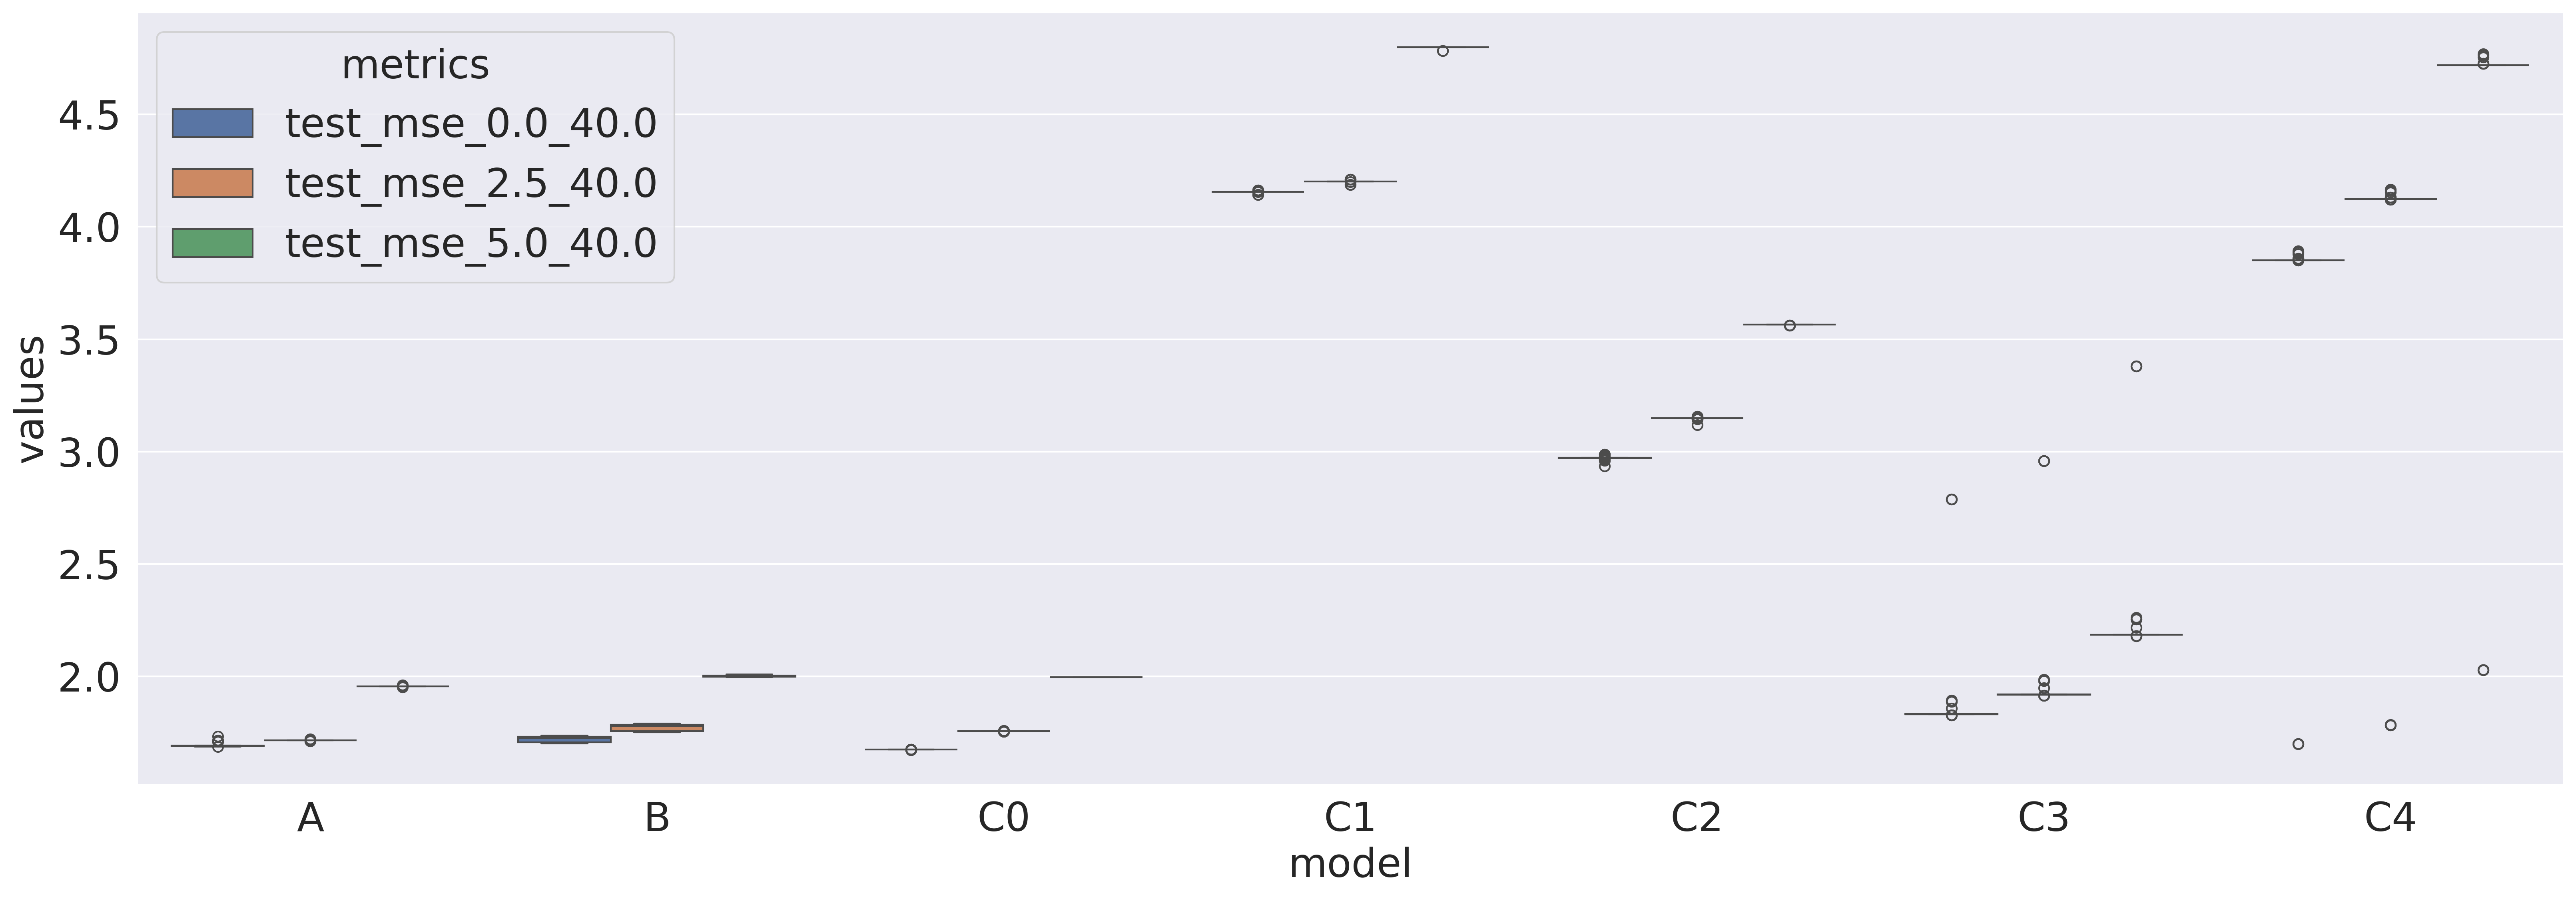

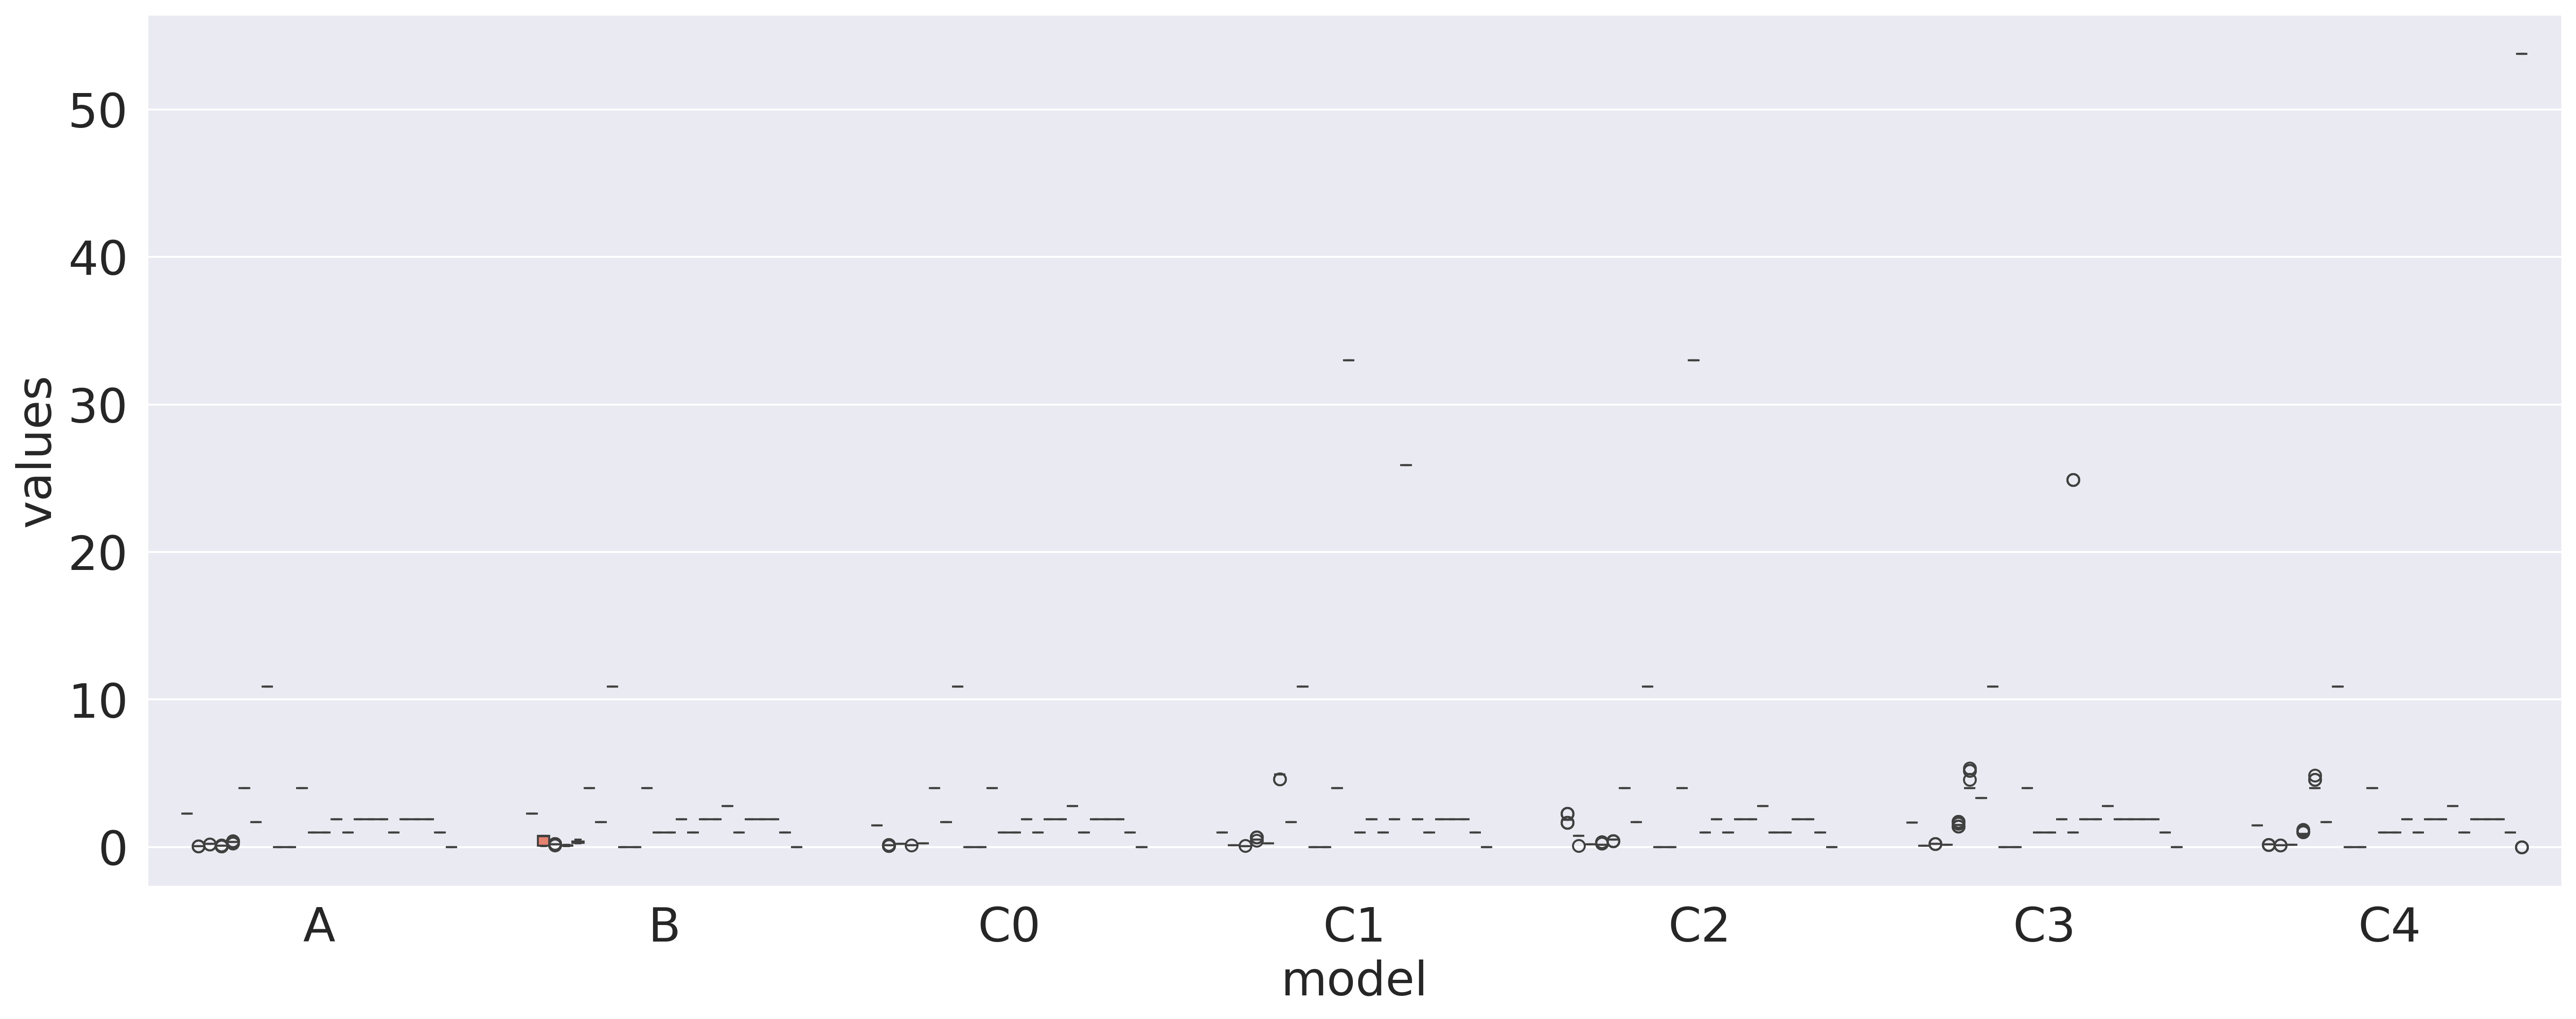

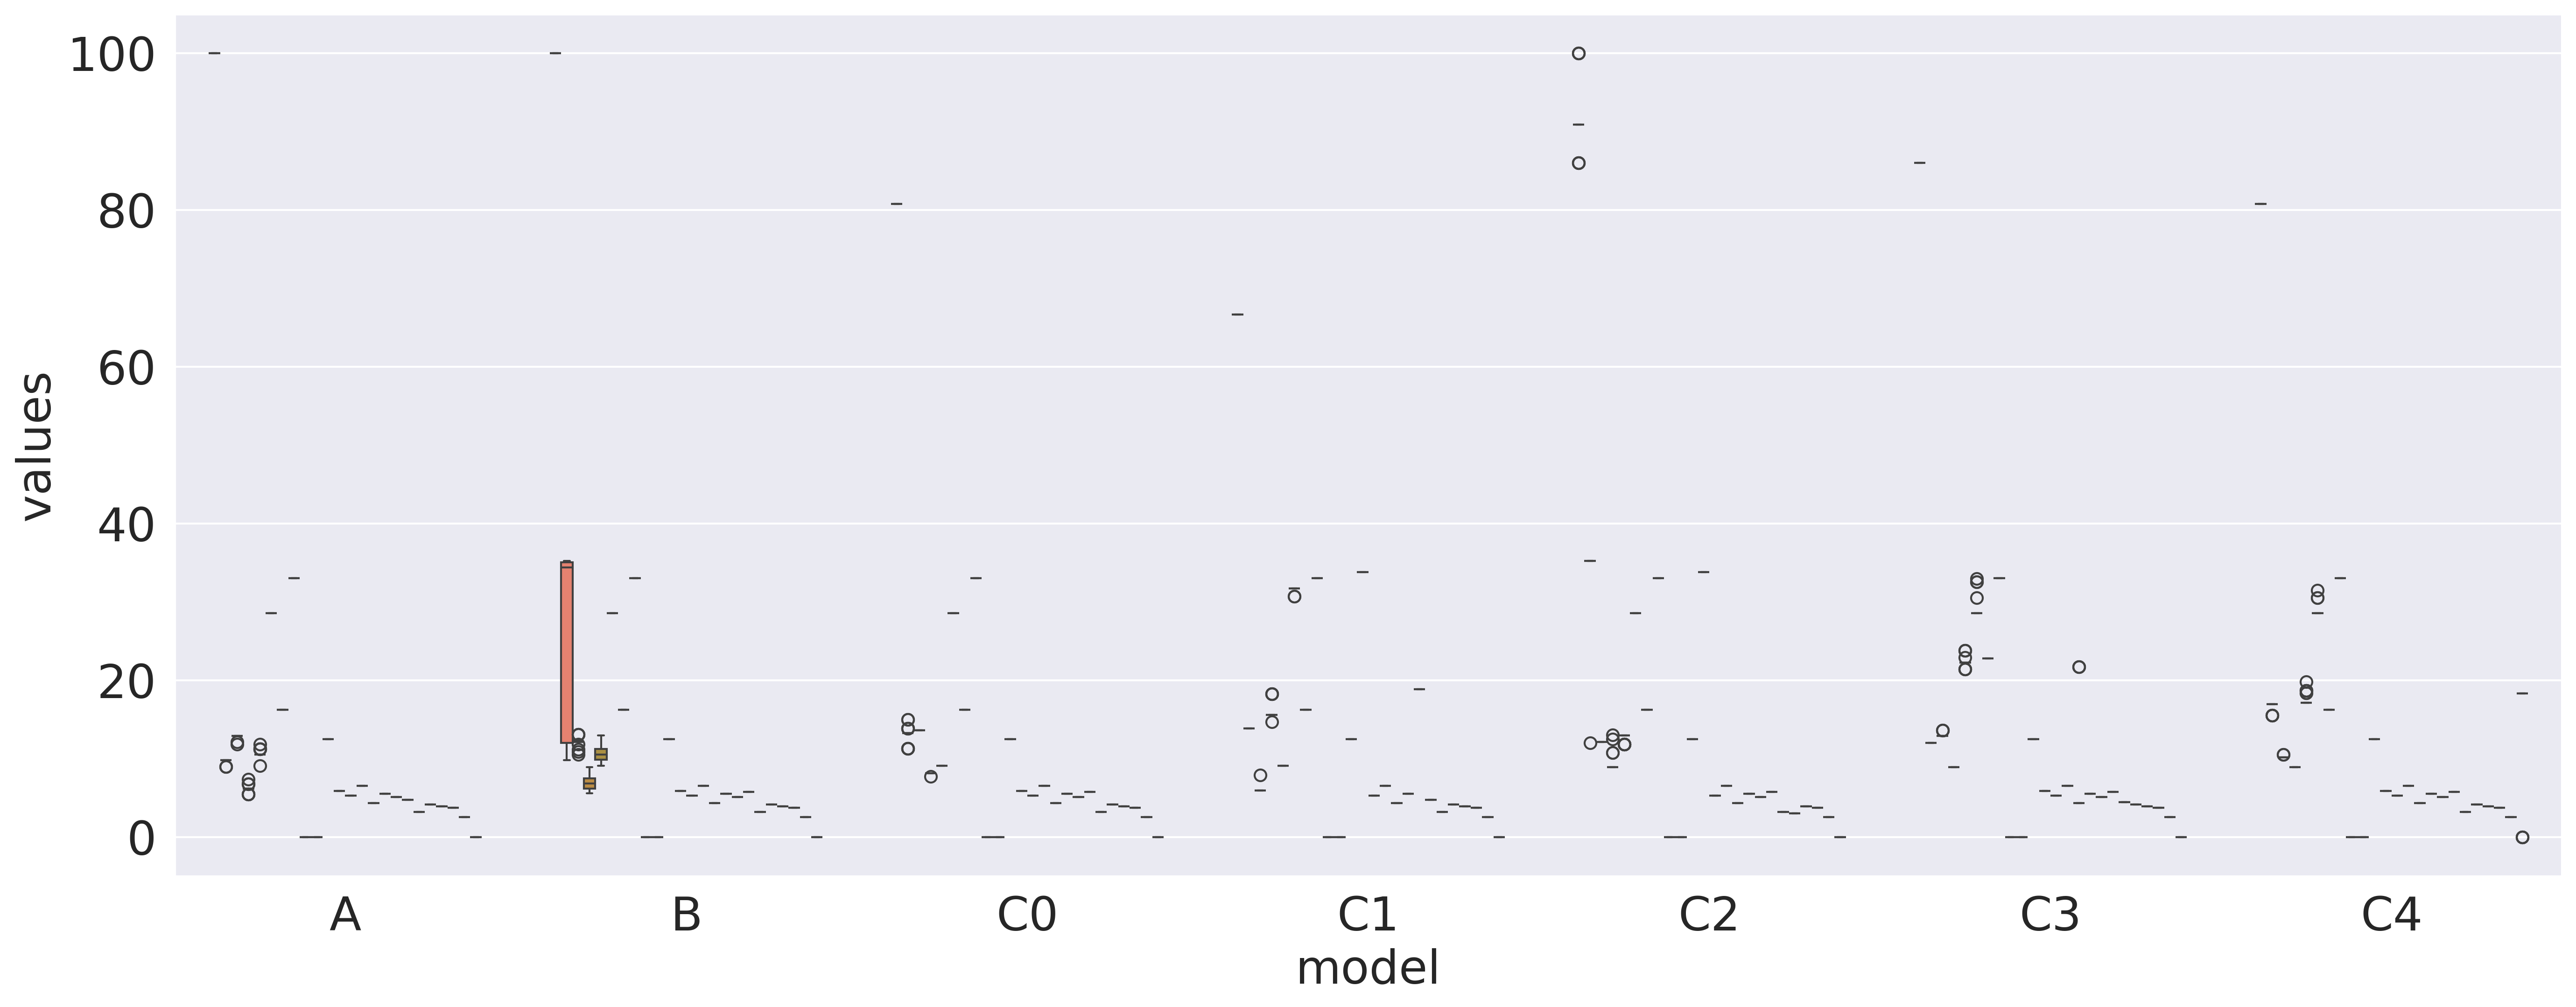

{
    'A': 'All data (25471)',
    'B': 'CCSampling(290)',
    'C0': '9.50e-01 <= y_dc <= 9.51e-01 (282)',
    'C1': '9.75e-01 <= y_dc <= 9.76e-01 (142)',
    'C2': '1.00e+00 <= y_dc <= 1.00e+00 (279)',
    'C3': '1.02e+00 <= y_dc <= 1.03e+00 (143)',
    'C4': '1.05e+00 <= y_dc <= 1.05e+00 (282)'
}

fit_time  score_time  test_r2 avg  test_neg_mean_squared_error avg  \
0    0.039760    0.034249     0.989396                        -1.687200   
1    0.038943    0.033882     0.989239                        -1.712178   
2    0.039532    0.034529     0.989368                        -1.691733   
3    0.040354    0.034230     0.989104                        -1.733689   
4    0.040968    0.034241     0.989364                        -1.692400   
..        ...         ...          ...                              ...   
219  0.020544    0.032571     0.975793                        -3.851733   
220  0.020735    0.032750     0.975793                        -3.851733   
221  0.021019    0.032515     0.975800                        -3.850533   
222  0.020816    0.032172     0.975800                        -3.850533   
223  0.018187    0.032766     0.975793                        -3.851733   

     test_r2_0.0  test_r2_1.5  test_r2_2.5  test_r2_3.5  test_r2_4.5  \
0            0.0          0.0          0.0          0.0          0.0   
1            0.0          0.0          0.0          0.0          0.0   
2            0.0          0.0          0.0          0.0          0.0   
3            0.0          0.0          0.0          0.0          0.0   
4            0.0          0.0          0.0          0.0          0.0   
..           ...          ...          ...          ...          ...   
219          1.0          0.0          0.0          0.0          0.0   
220          1.0          0.0          0.0          0.0          0.0   
221          1.0          0.0          0.0          0.0          0.0   
222          1.0          0.0          0.0          0.0          0.0   
223          1.0          0.0          0.0          0.0          0.0   

     test_r2_5.5  ...  test_abs_err_23.0  test_abs_err_25.0  \
0            0.0  ...                1.0           1.374369   
1            0.0  ...                1.0           1.374369   
2            0.0  ...                1.0           1.374369   
3            0.0  ...                1.0           1.374369   
4            0.0  ...                1.0           1.374369   
..           ...  ...                ...                ...   
219          0.0  ...                1.0           1.374369   
220          0.0  ...                1.0           1.374369   
221          0.0  ...                1.0           1.374369   
222          0.0  ...                1.0           1.374369   
223          0.0  ...                1.0           1.374369   

     test_abs_err_27.0  test_abs_err_29.0  test_abs_err_31.0  \
0             1.374369           1.374369                1.0   
1             1.374369           1.374369                1.0   
2             1.374369           1.374369                1.0   
3             1.374369           1.374369                1.0   
4             1.374369           1.374369                1.0   
..                 ...                ...                ...   
219           1.374369           1.666667                1.0   
220           1.374369           1.666667                1.0   
221           1.374369           1.666667                1.0   
222           1.374369           1.666667                1.0   
223           1.374369           1.666667                1.0   

     test_abs_err_33.0  test_abs_err_35.0  test_abs_err_37.0  \
0             1.374369           1.374369           1.374369   
1             1.374369           1.374369           1.374369   
2             1.374369           1.374369           1.374369   
3             1.374369           1.374369           1.374369   
4             1.374369           1.374369           1.374369   
..                 ...                ...                ...   
219           1.374369           1.374369           1.374369   
220           1.374369           1.374369           1.374369   
221           1.374369           1.374369           1.374369   
222           1.374369           1.374369           1.374369   
223      

In [21]:
test_feature("y_dc")

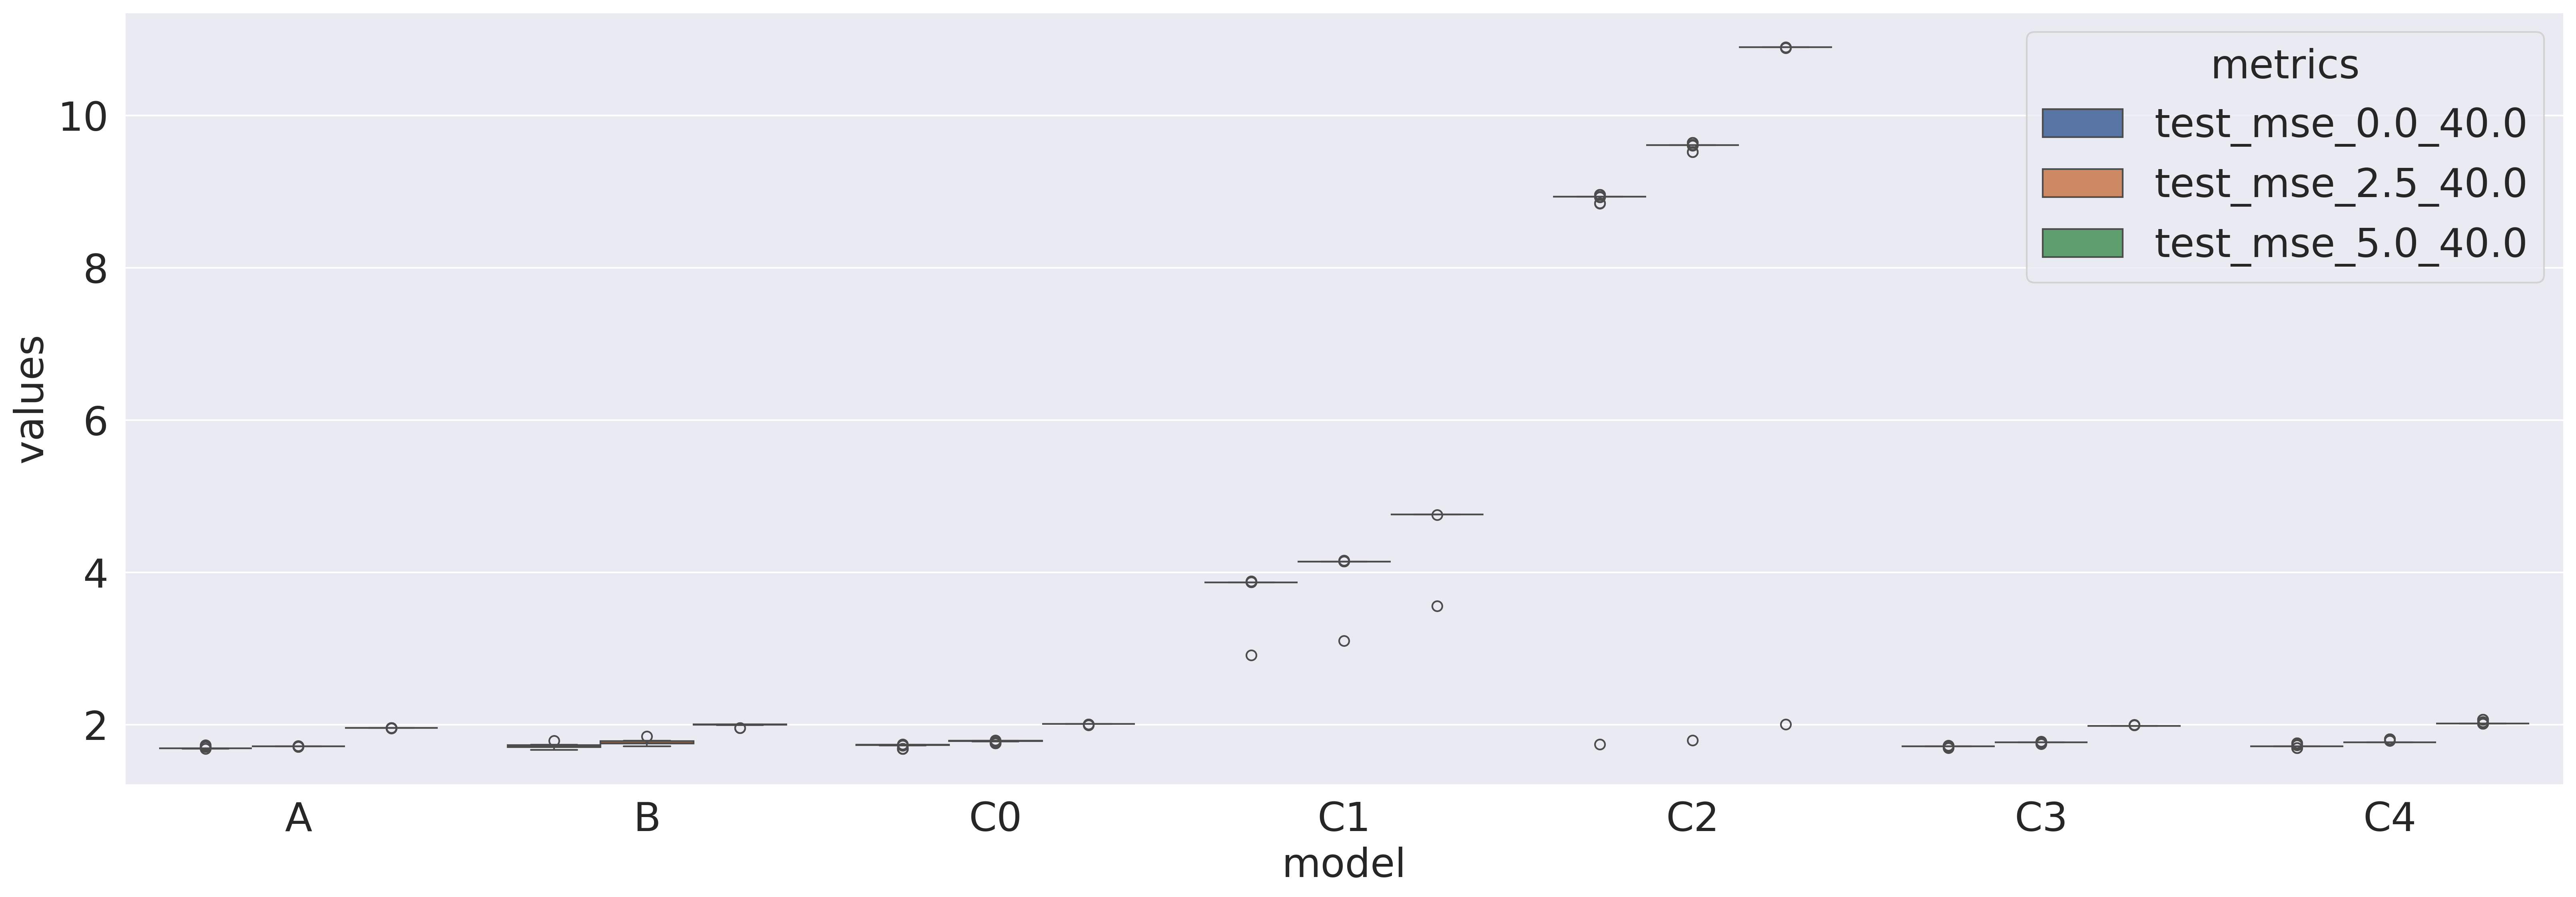

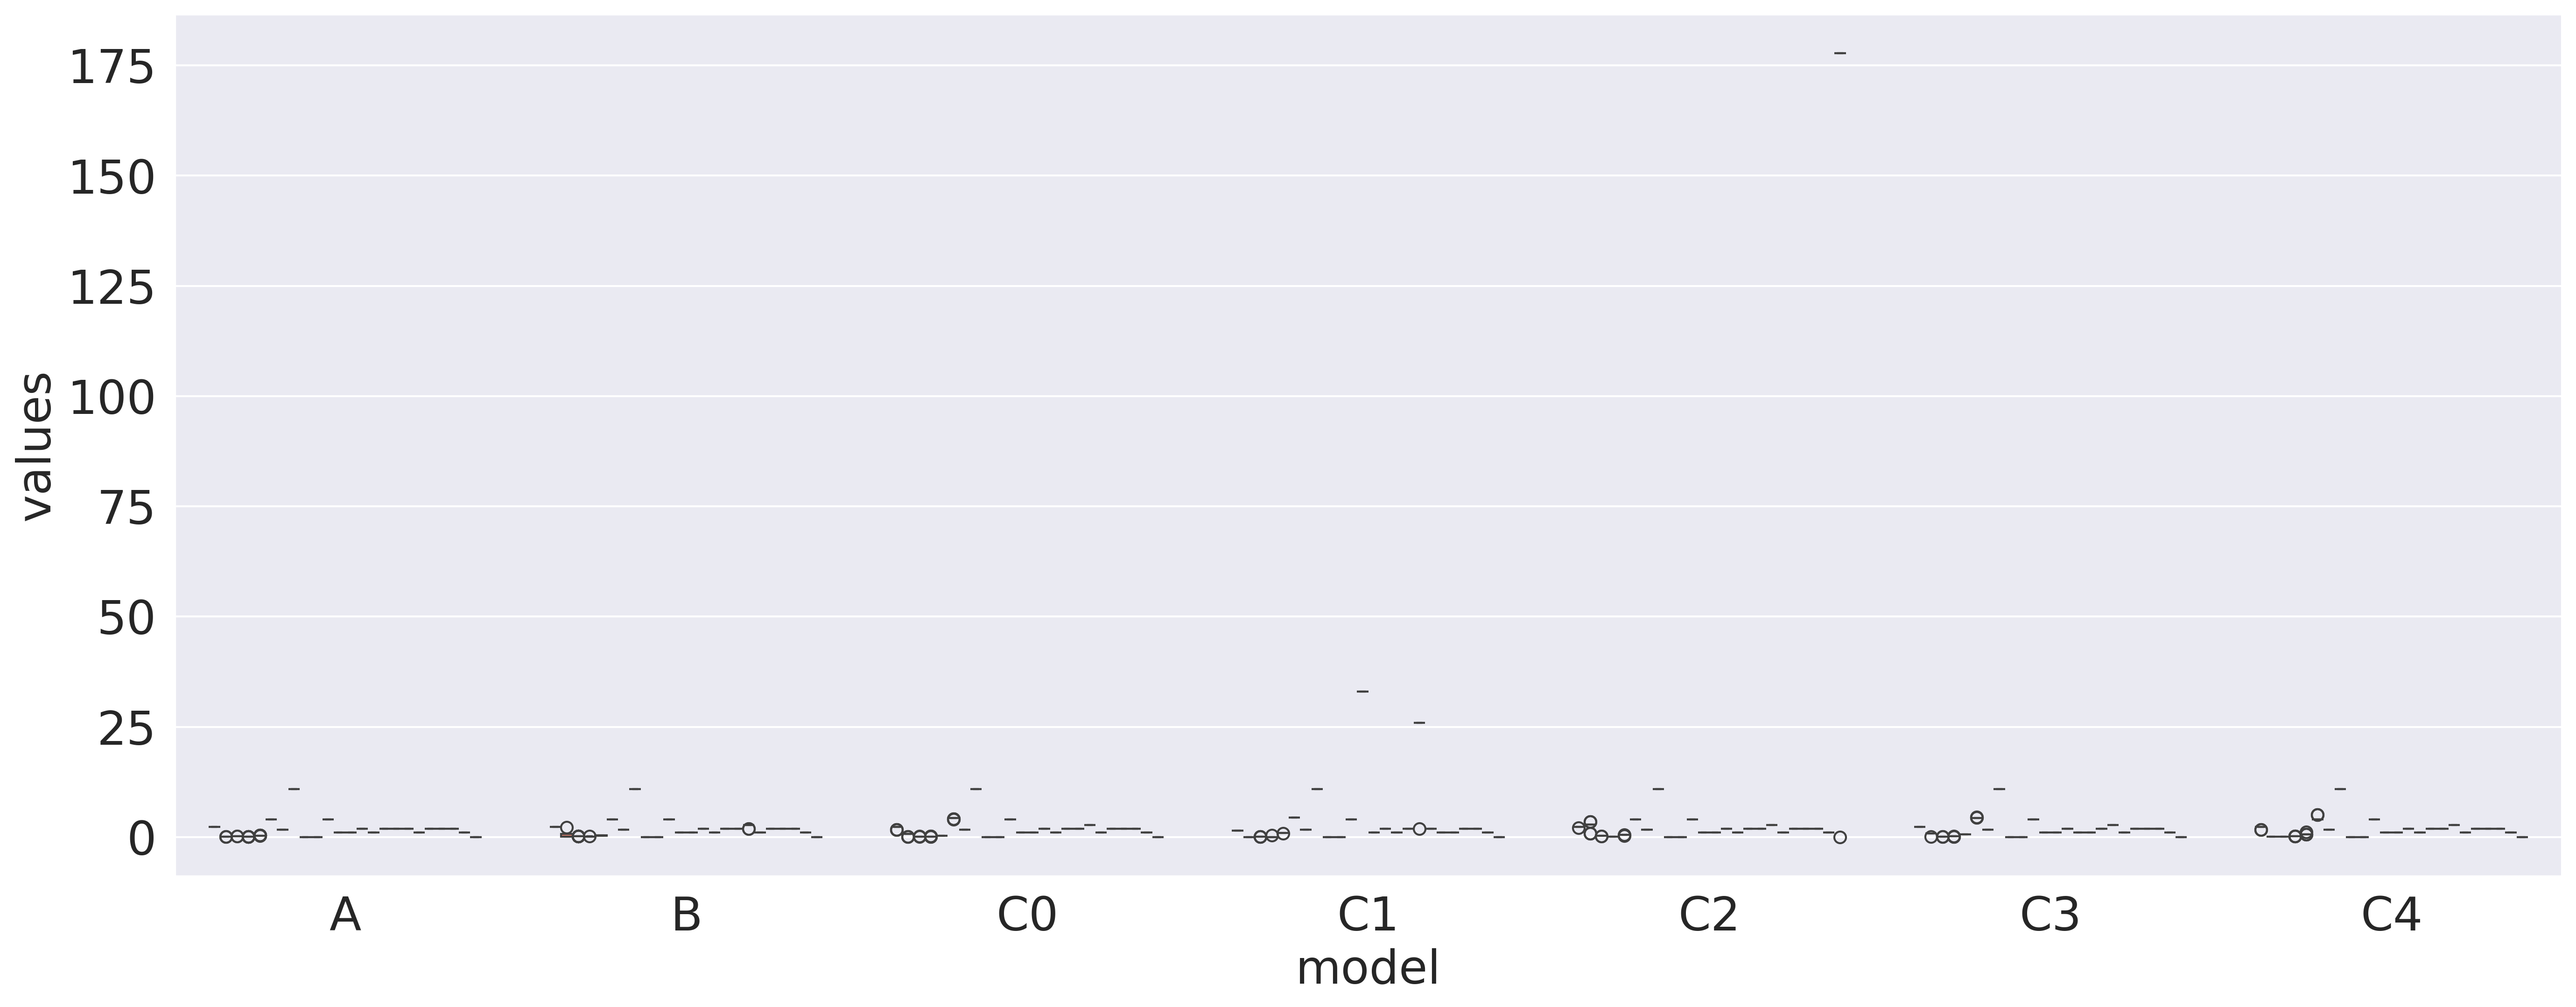

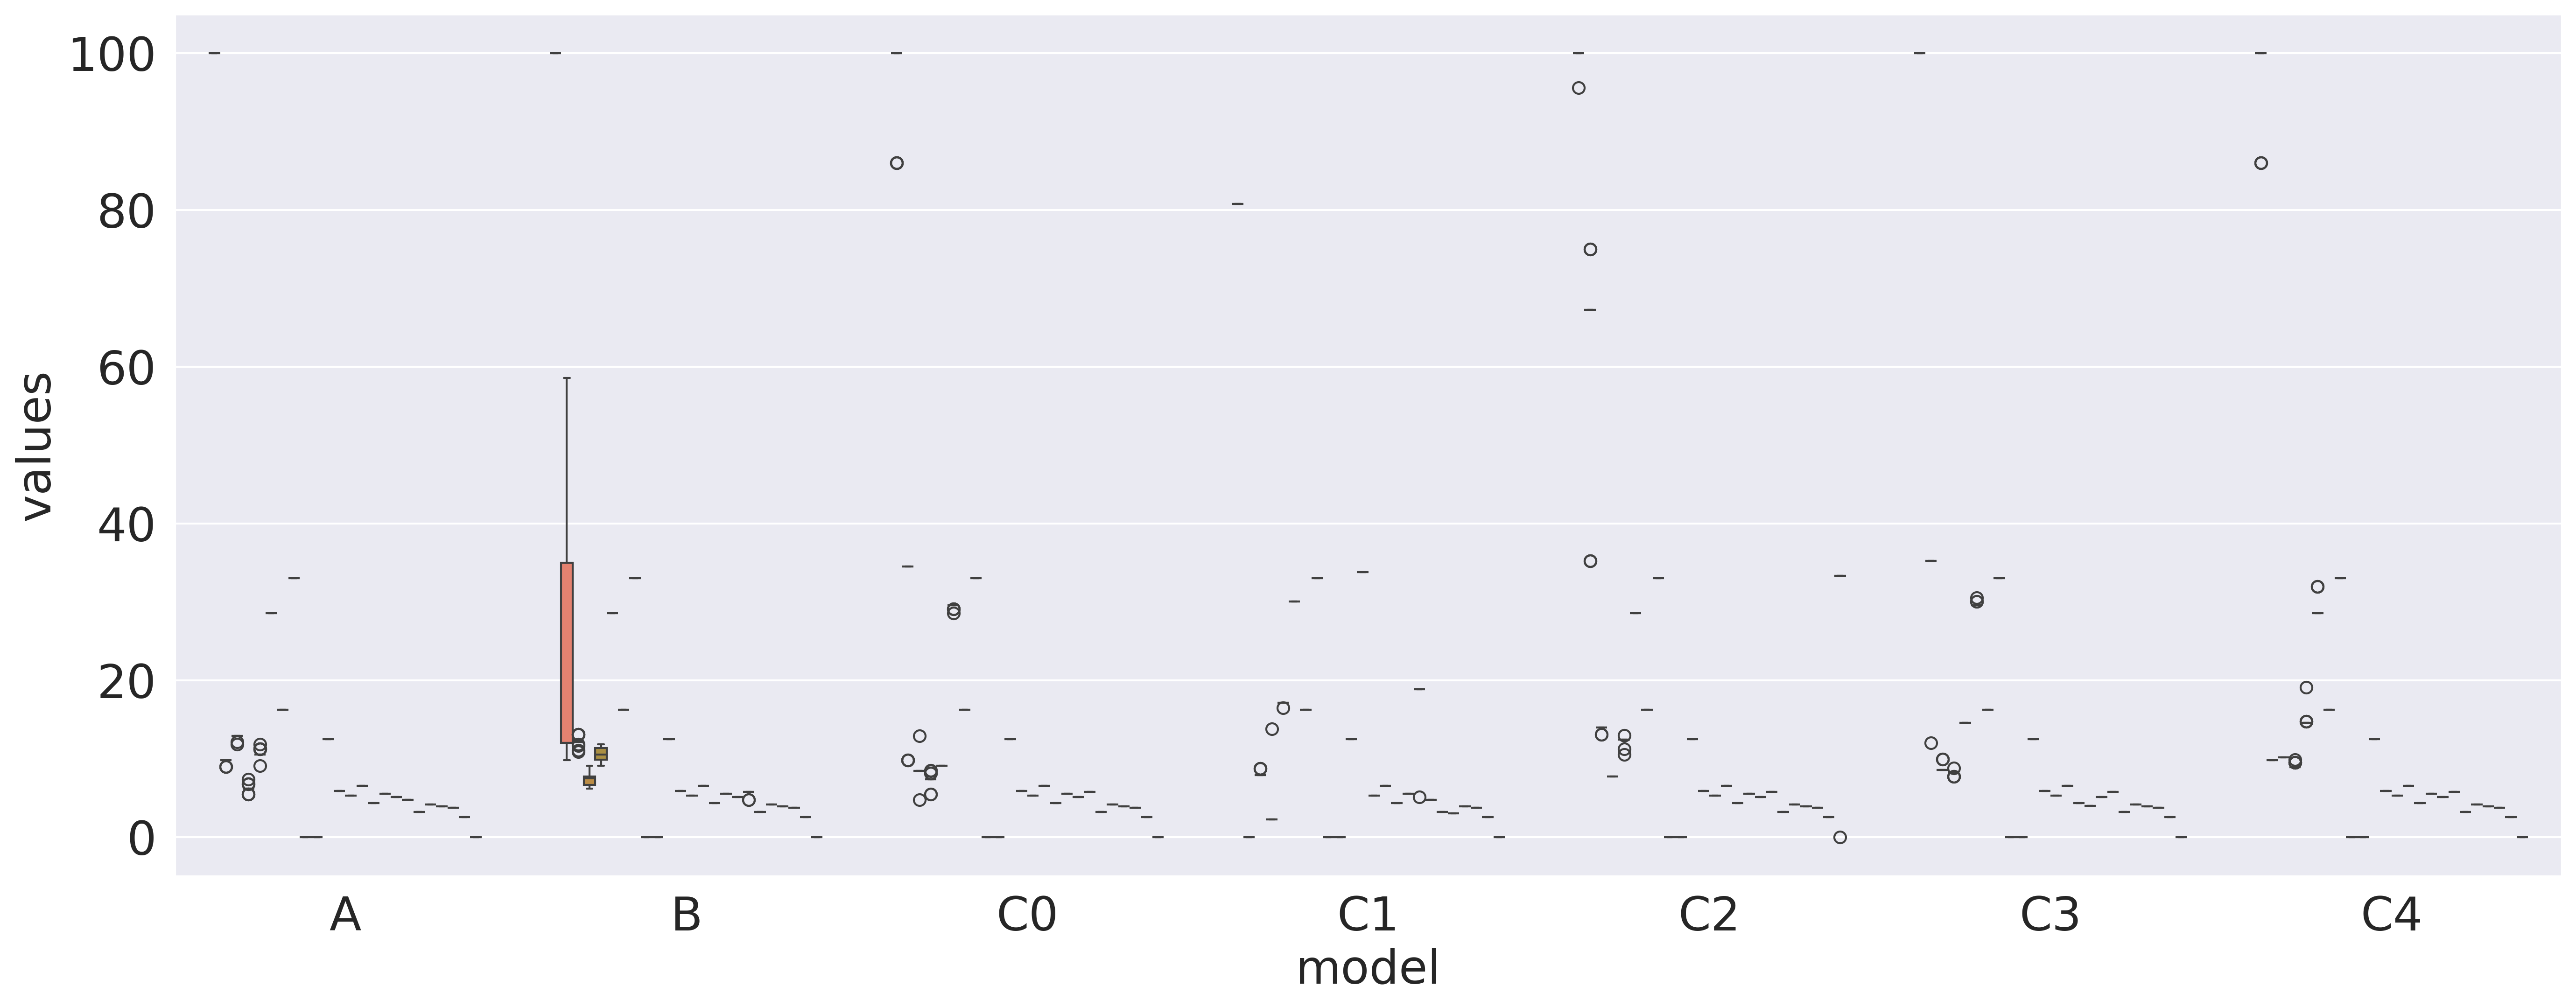

{
    'A': 'All data (25471)',
    'B': 'CCSampling(290)',
    'C0': '9.50e-01 <= y_pcf <= 9.51e-01 (279)',
    'C1': '9.75e-01 <= y_pcf <= 9.76e-01 (142)',
    'C2': '1.00e+00 <= y_pcf <= 1.00e+00 (282)',
    'C3': '1.02e+00 <= y_pcf <= 1.03e+00 (285)',
    'C4': '1.05e+00 <= y_pcf <= 1.05e+00 (284)'
}

fit_time  score_time  test_r2 avg  test_neg_mean_squared_error avg  \
0    0.039196    0.033949     0.989396                        -1.687200   
1    0.039613    0.033744     0.989239                        -1.712178   
2    0.038275    0.034132     0.989368                        -1.691733   
3    0.038585    0.034292     0.989104                        -1.733689   
4    0.038137    0.033735     0.989364                        -1.692400   
..        ...         ...          ...                              ...   
219  0.020885    0.032591     0.989208                        -1.717111   
220  0.022286    0.032676     0.989208                        -1.717111   
221  0.021696    0.032576     0.989208                        -1.717111   
222  0.020926    0.032144     0.989208                        -1.717111   
223  0.019178    0.032644     0.989092                        -1.735644   

     test_r2_0.0  test_r2_1.5  test_r2_2.5  test_r2_3.5  test_r2_4.5  \
0            0.0          0.0          0.0          0.0          0.0   
1            0.0          0.0          0.0          0.0          0.0   
2            0.0          0.0          0.0          0.0          0.0   
3            0.0          0.0          0.0          0.0          0.0   
4            0.0          0.0          0.0          0.0          0.0   
..           ...          ...          ...          ...          ...   
219          1.0          0.0          0.0          0.0          0.0   
220          1.0          0.0          0.0          0.0          0.0   
221          1.0          0.0          0.0          0.0          0.0   
222          1.0          0.0          0.0          0.0          0.0   
223          1.0          0.0          0.0          0.0          0.0   

     test_r2_5.5  ...  test_abs_err_23.0  test_abs_err_25.0  \
0            0.0  ...                1.0           1.374369   
1            0.0  ...                1.0           1.374369   
2            0.0  ...                1.0           1.374369   
3            0.0  ...                1.0           1.374369   
4            0.0  ...                1.0           1.374369   
..           ...  ...                ...                ...   
219          0.0  ...                1.0           1.374369   
220          0.0  ...                1.0           1.374369   
221          0.0  ...                1.0           1.374369   
222          0.0  ...                1.0           1.374369   
223          0.0  ...                1.0           1.374369   

     test_abs_err_27.0  test_abs_err_29.0  test_abs_err_31.0  \
0             1.374369           1.374369                1.0   
1             1.374369           1.374369                1.0   
2             1.374369           1.374369                1.0   
3             1.374369           1.374369                1.0   
4             1.374369           1.374369                1.0   
..                 ...                ...                ...   
219           1.374369           1.666667                1.0   
220           1.374369           1.666667                1.0   
221           1.374369           1.666667                1.0   
222           1.374369           1.666667                1.0   
223           1.374369           1.666667                1.0   

     test_abs_err_33.0  test_abs_err_35.0  test_abs_err_37.0  \
0             1.374369           1.374369           1.374369   
1             1.374369           1.374369           1.374369   
2             1.374369           1.374369           1.374369   
3             1.374369           1.374369           1.374369   
4             1.374369           1.374369           1.374369   
..                 ...                ...                ...   
219           1.374369           1.374369           1.374369   
220           1.374369           1.374369           1.374369   
221           1.374369           1.374369           1.374369   
222           1.374369           1.374369           1.374369   
223      

In [22]:
test_feature("y_pcf")

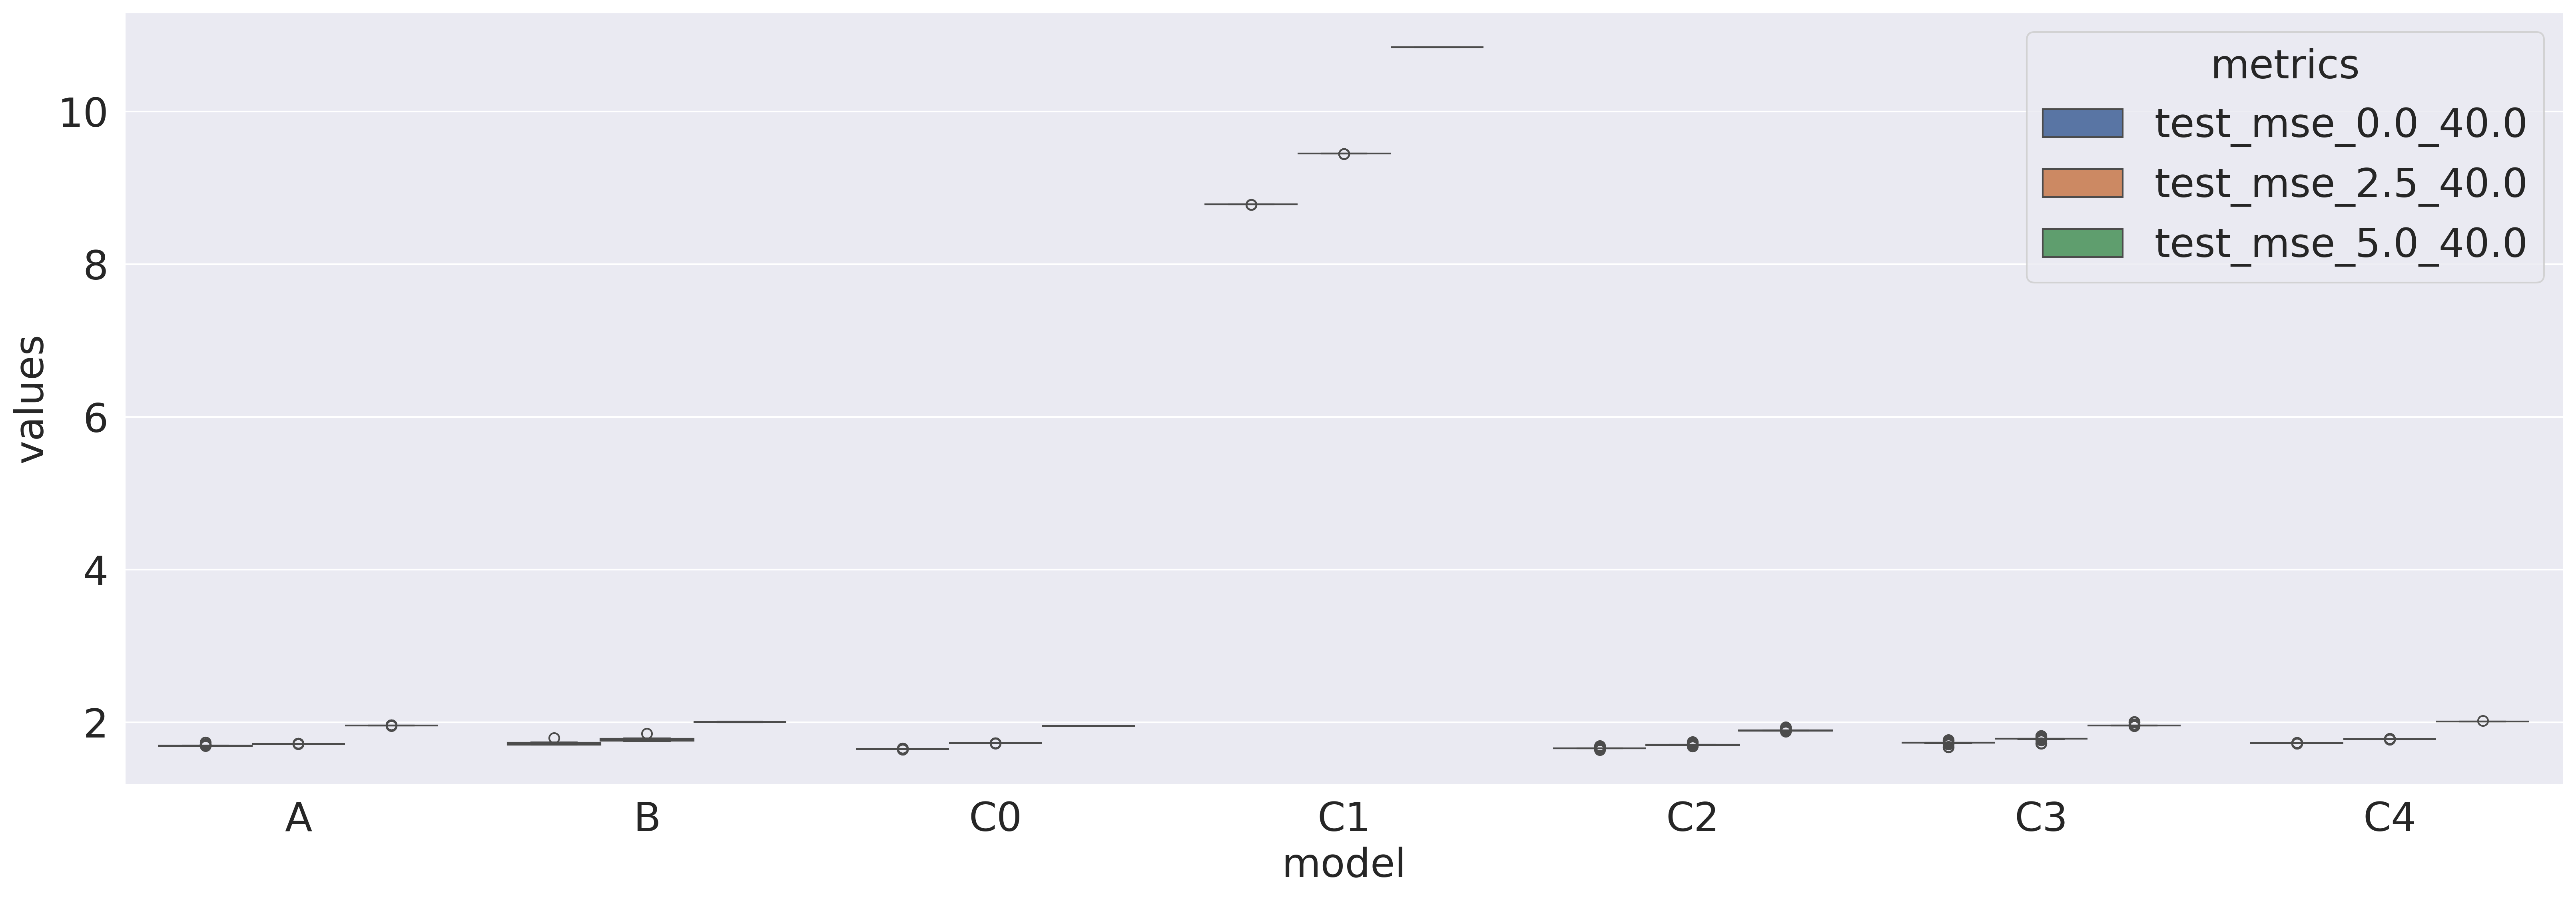

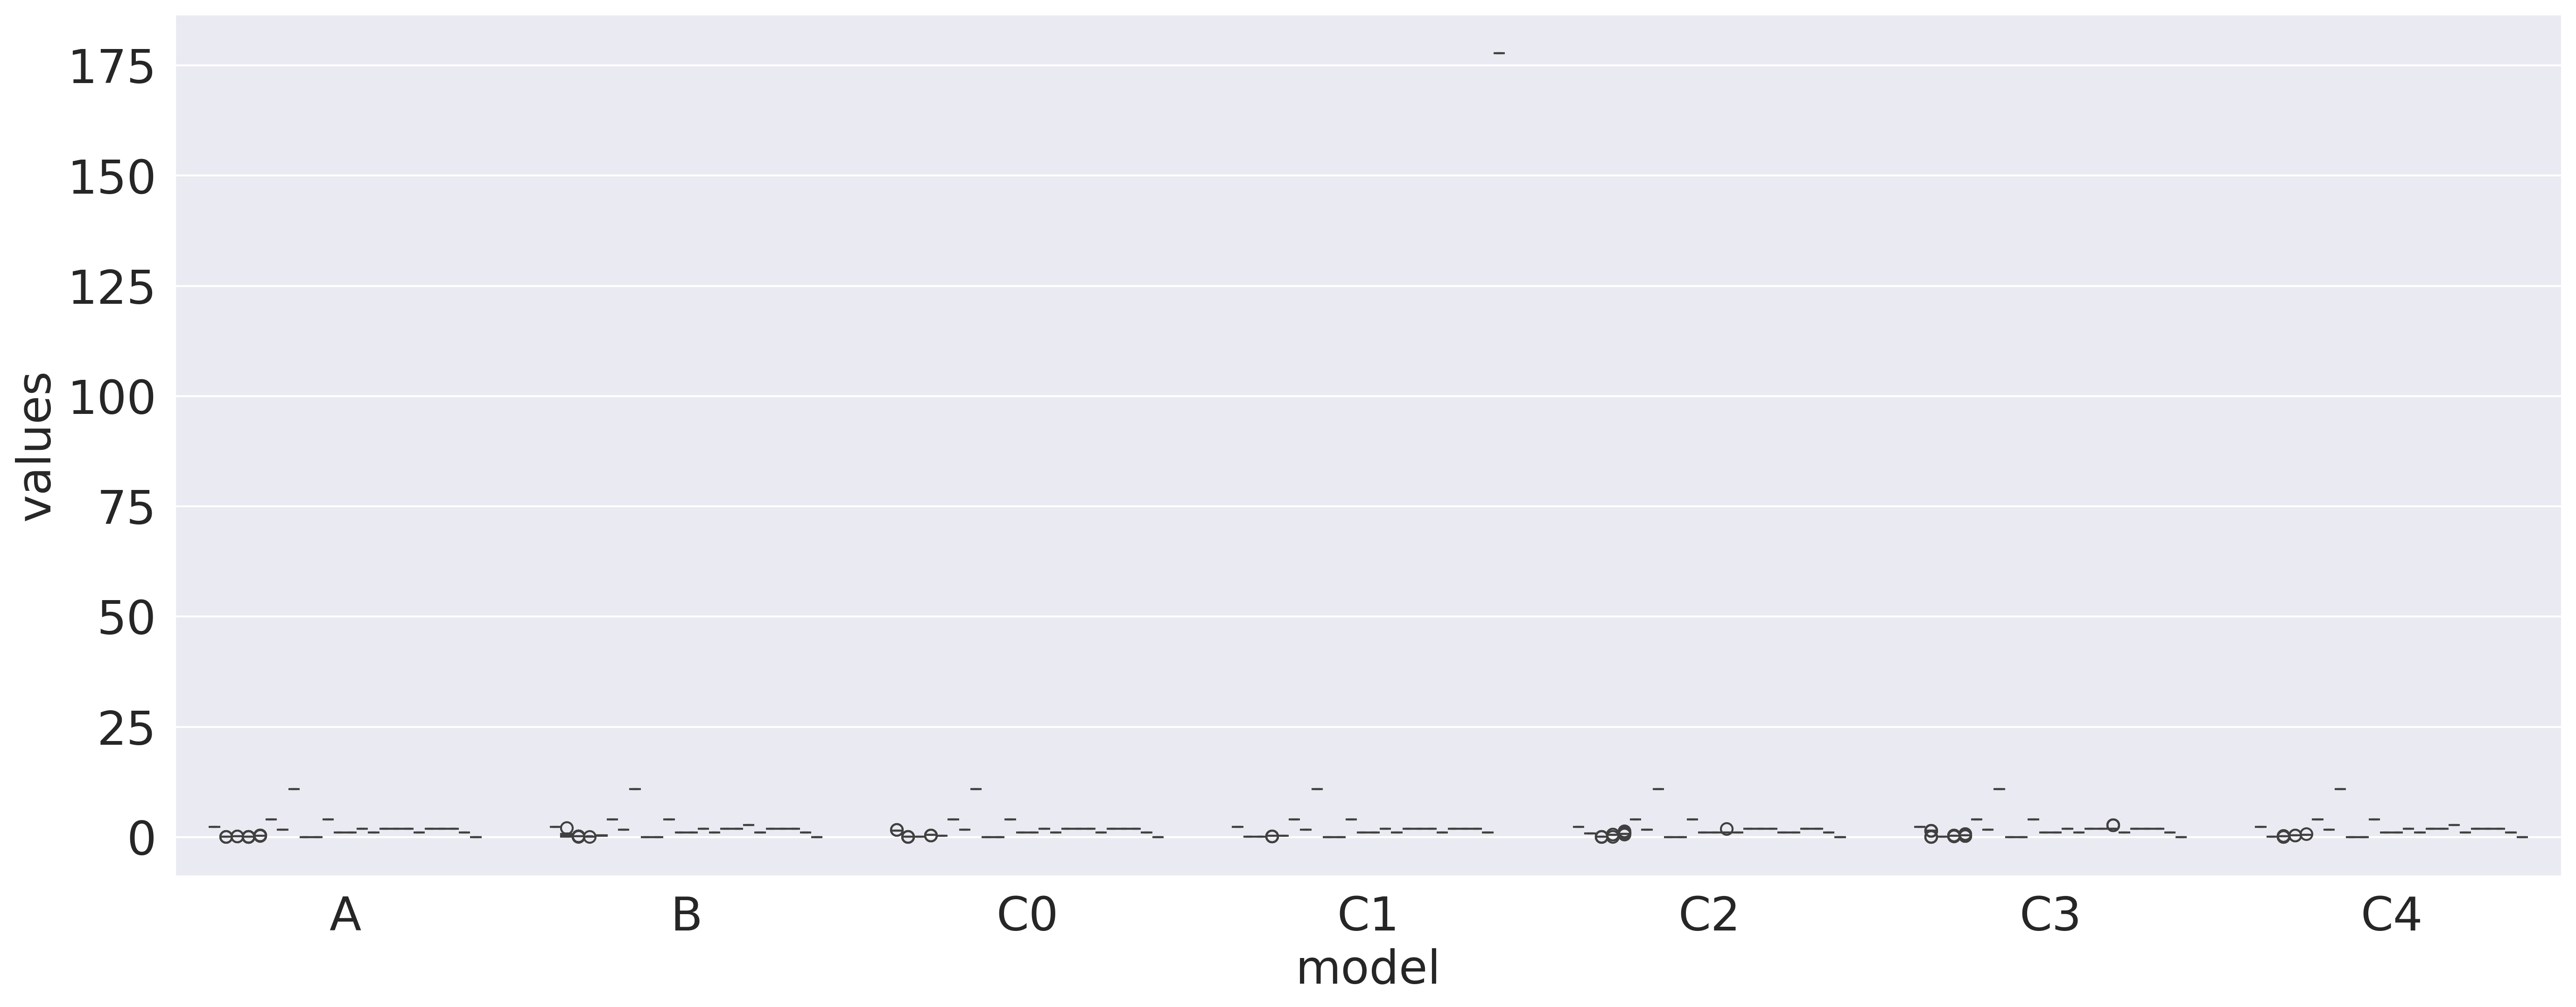

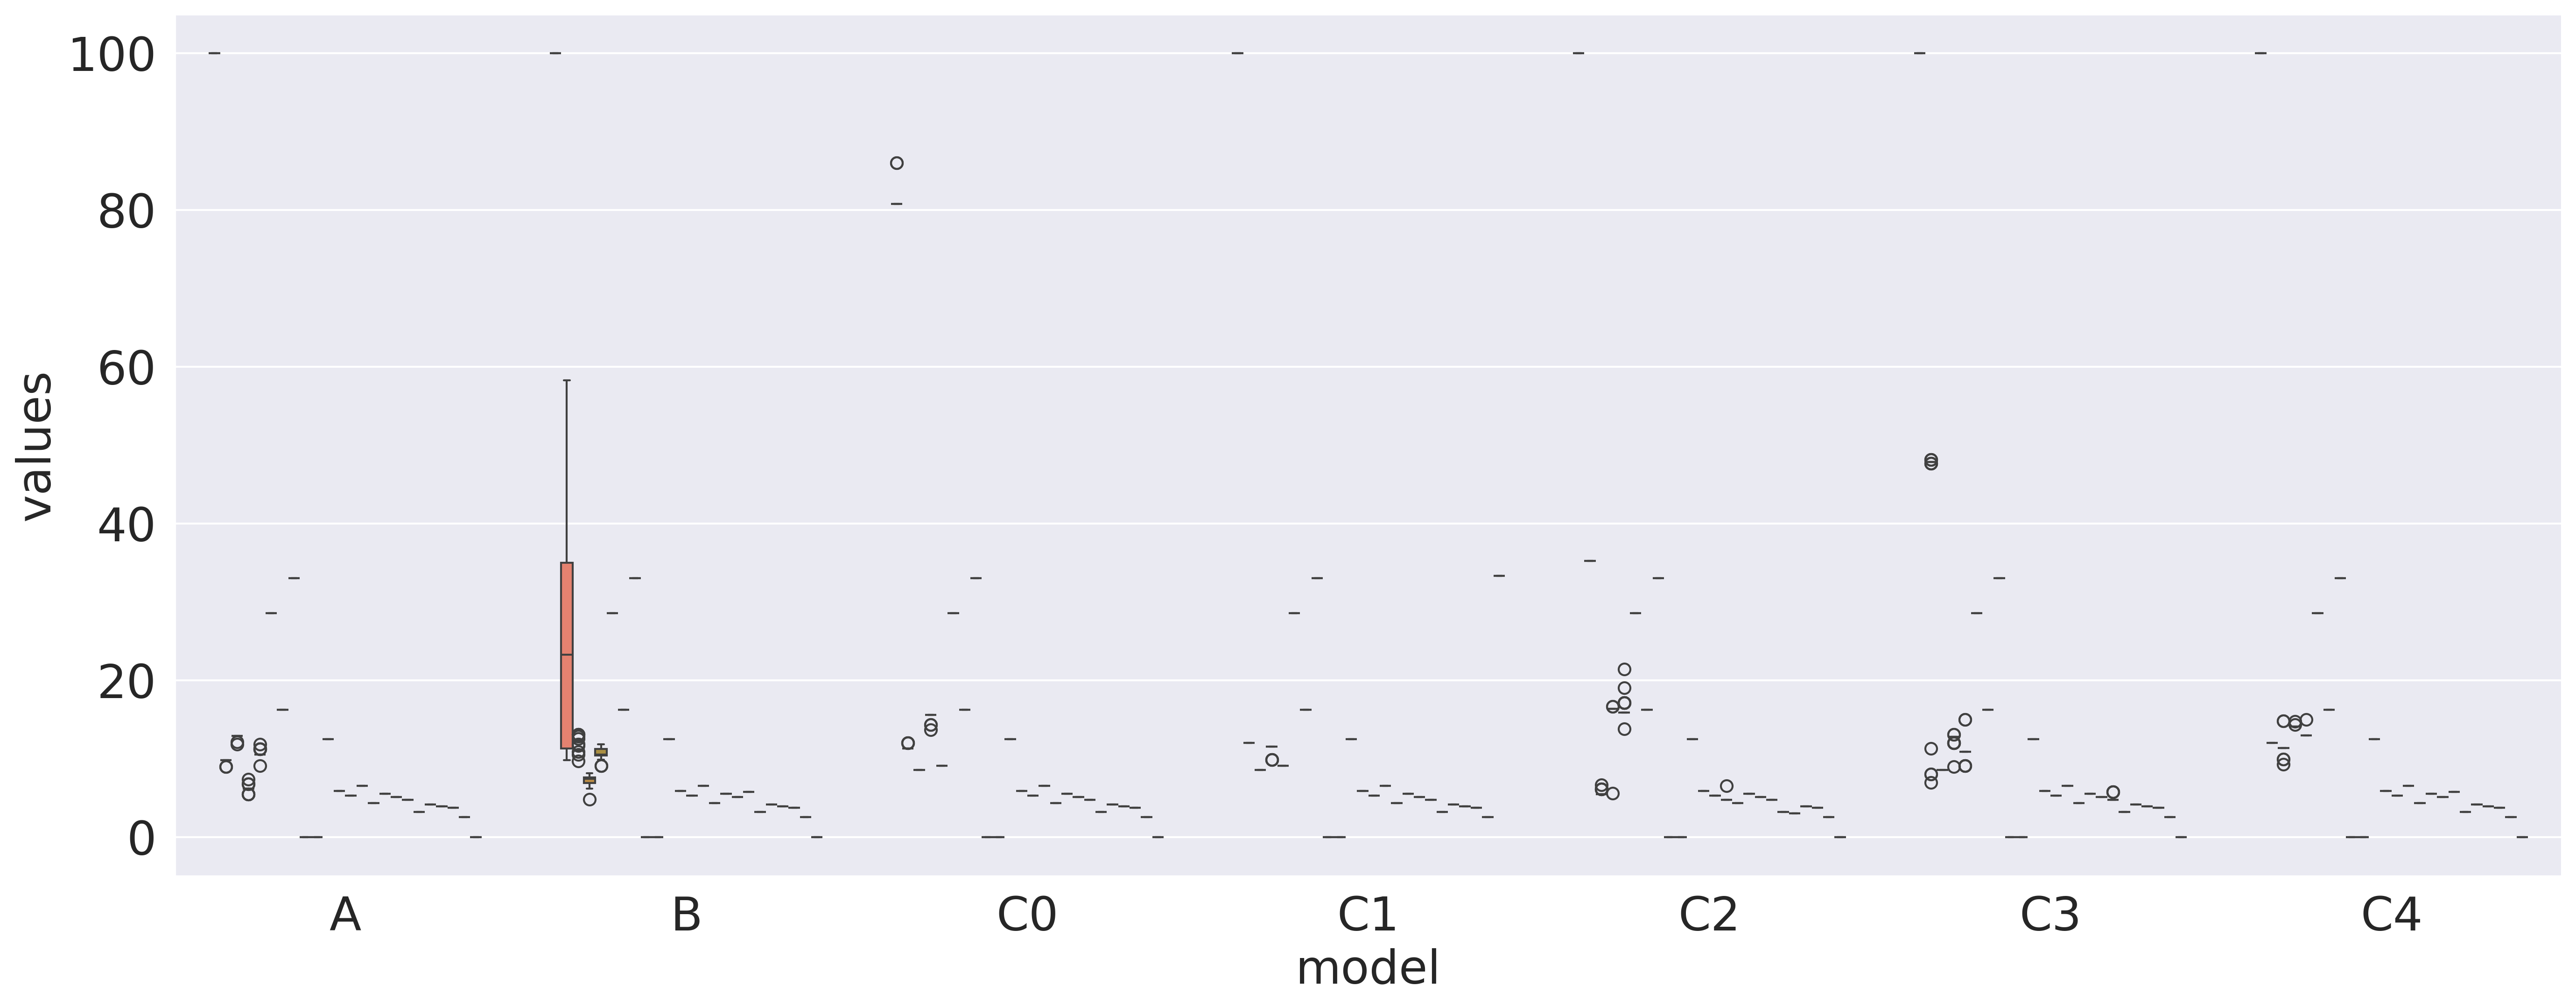

{
    'A': 'All data (25471)',
    'B': 'CCSampling(290)',
    'C0': '9.50e-01 <= y_ec_pwas <= 9.51e-01 (283)',
    'C1': '9.75e-01 <= y_ec_pwas <= 9.76e-01 (136)',
    'C2': '1.00e+00 <= y_ec_pwas <= 1.00e+00 (283)',
    'C3': '1.02e+00 <= y_ec_pwas <= 1.03e+00 (281)',
    'C4': '1.05e+00 <= y_ec_pwas <= 1.05e+00 (283)'
}

fit_time  score_time  test_r2 avg  test_neg_mean_squared_error avg  \
0    0.039216    0.034784     0.989396                        -1.687200   
1    0.039365    0.033708     0.989239                        -1.712178   
2    0.040332    0.034513     0.989368                        -1.691733   
3    0.043081    0.033482     0.989104                        -1.733689   
4    0.038920    0.033951     0.989364                        -1.692400   
..        ...         ...          ...                              ...   
219  0.021310    0.032466     0.989164                        -1.724089   
220  0.020871    0.032680     0.989164                        -1.724089   
221  0.020283    0.032835     0.989164                        -1.724089   
222  0.020119    0.032475     0.989164                        -1.724089   
223  0.019020    0.032712     0.989164                        -1.724089   

     test_r2_0.0  test_r2_1.5  test_r2_2.5  test_r2_3.5  test_r2_4.5  \
0            0.0          0.0          0.0          0.0          0.0   
1            0.0          0.0          0.0          0.0          0.0   
2            0.0          0.0          0.0          0.0          0.0   
3            0.0          0.0          0.0          0.0          0.0   
4            0.0          0.0          0.0          0.0          0.0   
..           ...          ...          ...          ...          ...   
219          1.0          0.0          0.0          0.0          0.0   
220          1.0          0.0          0.0          0.0          0.0   
221          1.0          0.0          0.0          0.0          0.0   
222          1.0          0.0          0.0          0.0          0.0   
223          1.0          0.0          0.0          0.0          0.0   

     test_r2_5.5  ...  test_abs_err_23.0  test_abs_err_25.0  \
0            0.0  ...                1.0           1.374369   
1            0.0  ...                1.0           1.374369   
2            0.0  ...                1.0           1.374369   
3            0.0  ...                1.0           1.374369   
4            0.0  ...                1.0           1.374369   
..           ...  ...                ...                ...   
219          0.0  ...                1.0           1.374369   
220          0.0  ...                1.0           1.374369   
221          0.0  ...                1.0           1.374369   
222          0.0  ...                1.0           1.374369   
223          0.0  ...                1.0           1.374369   

     test_abs_err_27.0  test_abs_err_29.0  test_abs_err_31.0  \
0             1.374369           1.374369                1.0   
1             1.374369           1.374369                1.0   
2             1.374369           1.374369                1.0   
3             1.374369           1.374369                1.0   
4             1.374369           1.374369                1.0   
..                 ...                ...                ...   
219           1.374369           1.666667                1.0   
220           1.374369           1.666667                1.0   
221           1.374369           1.666667                1.0   
222           1.374369           1.666667                1.0   
223           1.374369           1.666667                1.0   

     test_abs_err_33.0  test_abs_err_35.0  test_abs_err_37.0  \
0             1.374369           1.374369           1.374369   
1             1.374369           1.374369           1.374369   
2             1.374369           1.374369           1.374369   
3             1.374369           1.374369           1.374369   
4             1.374369           1.374369           1.374369   
..                 ...                ...                ...   
219           1.374369           1.374369           1.374369   
220           1.374369           1.374369           1.374369   
221           1.374369           1.374369           1.374369   
222           1.374369           1.374369           1.374369   
223      

In [23]:
test_feature("y_ec_pwas")

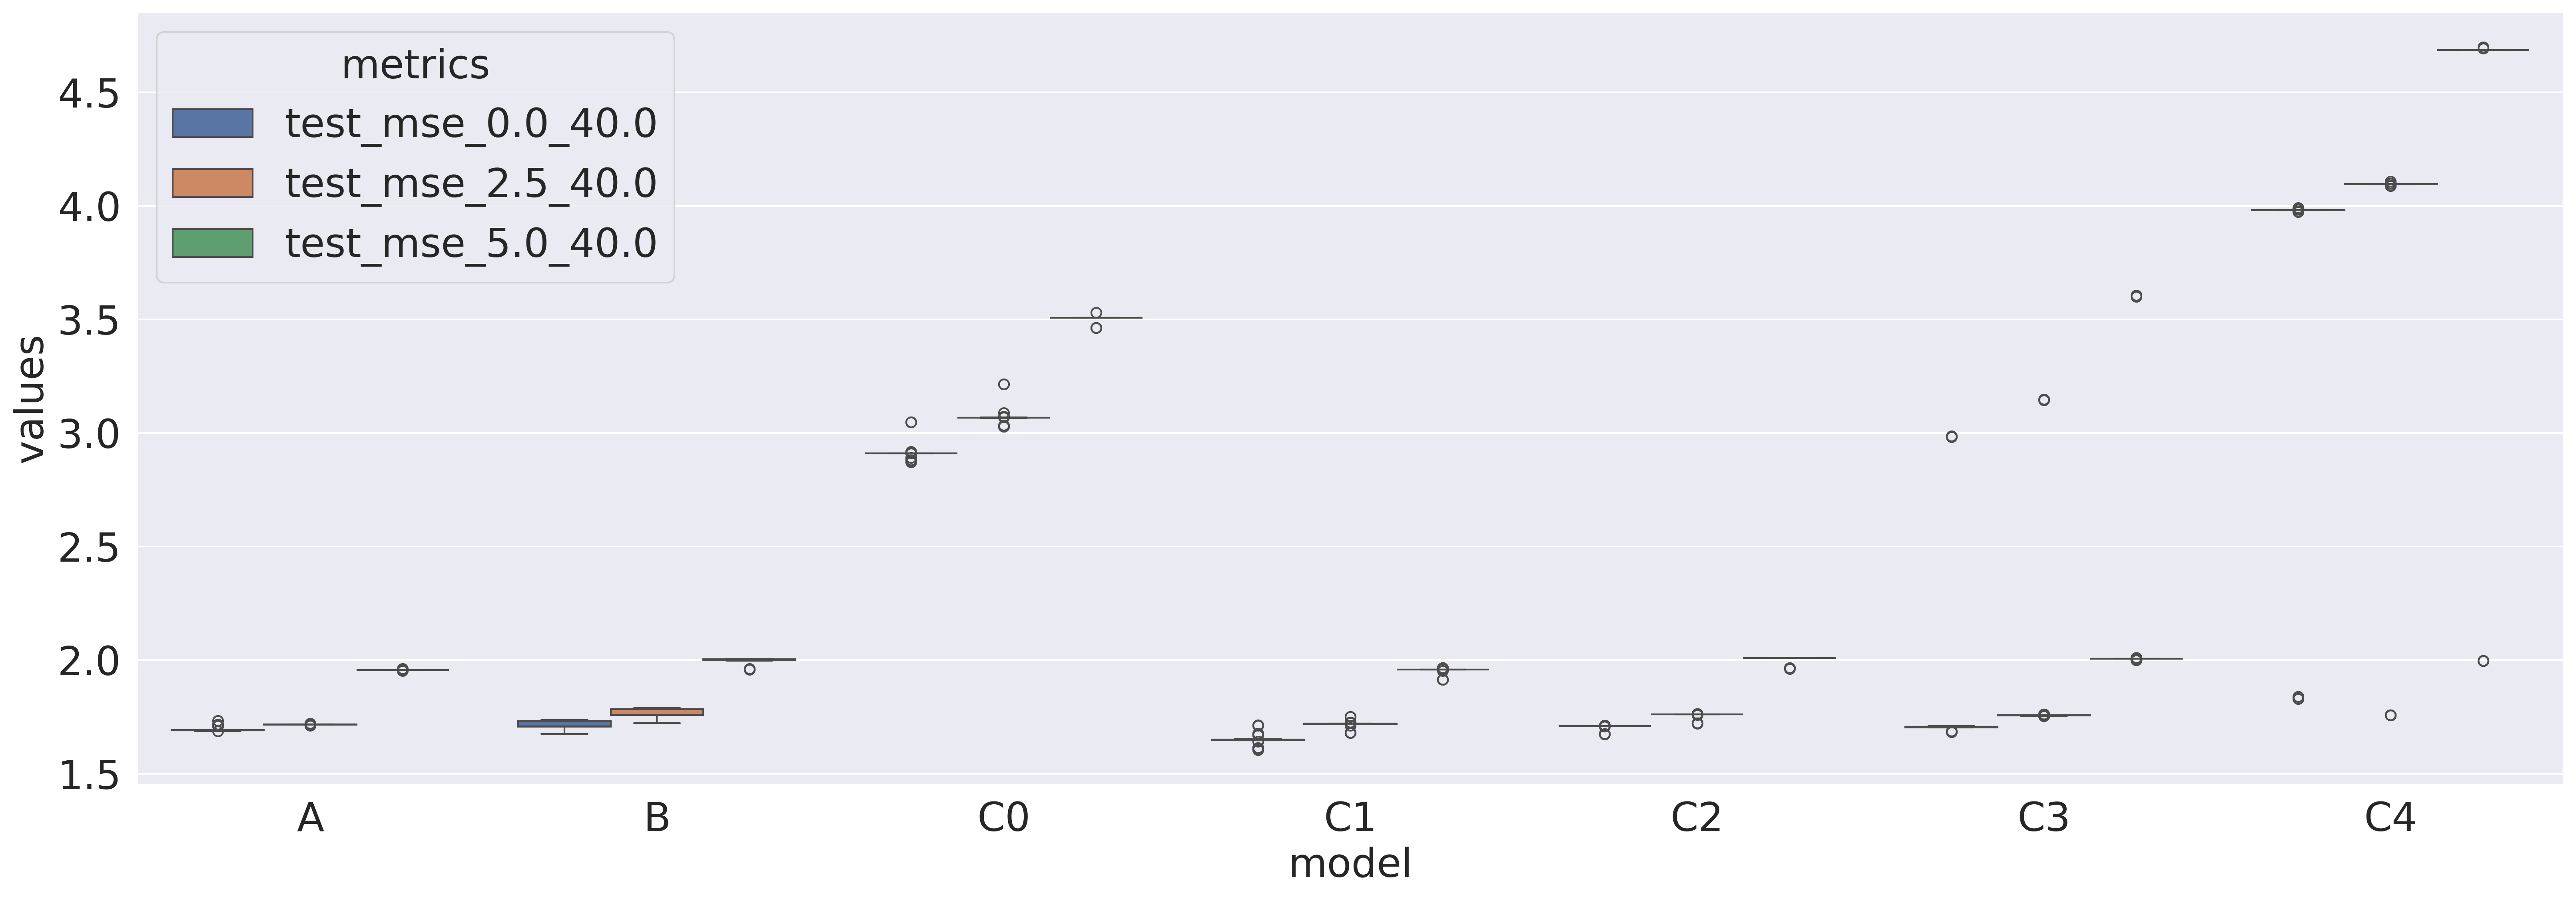

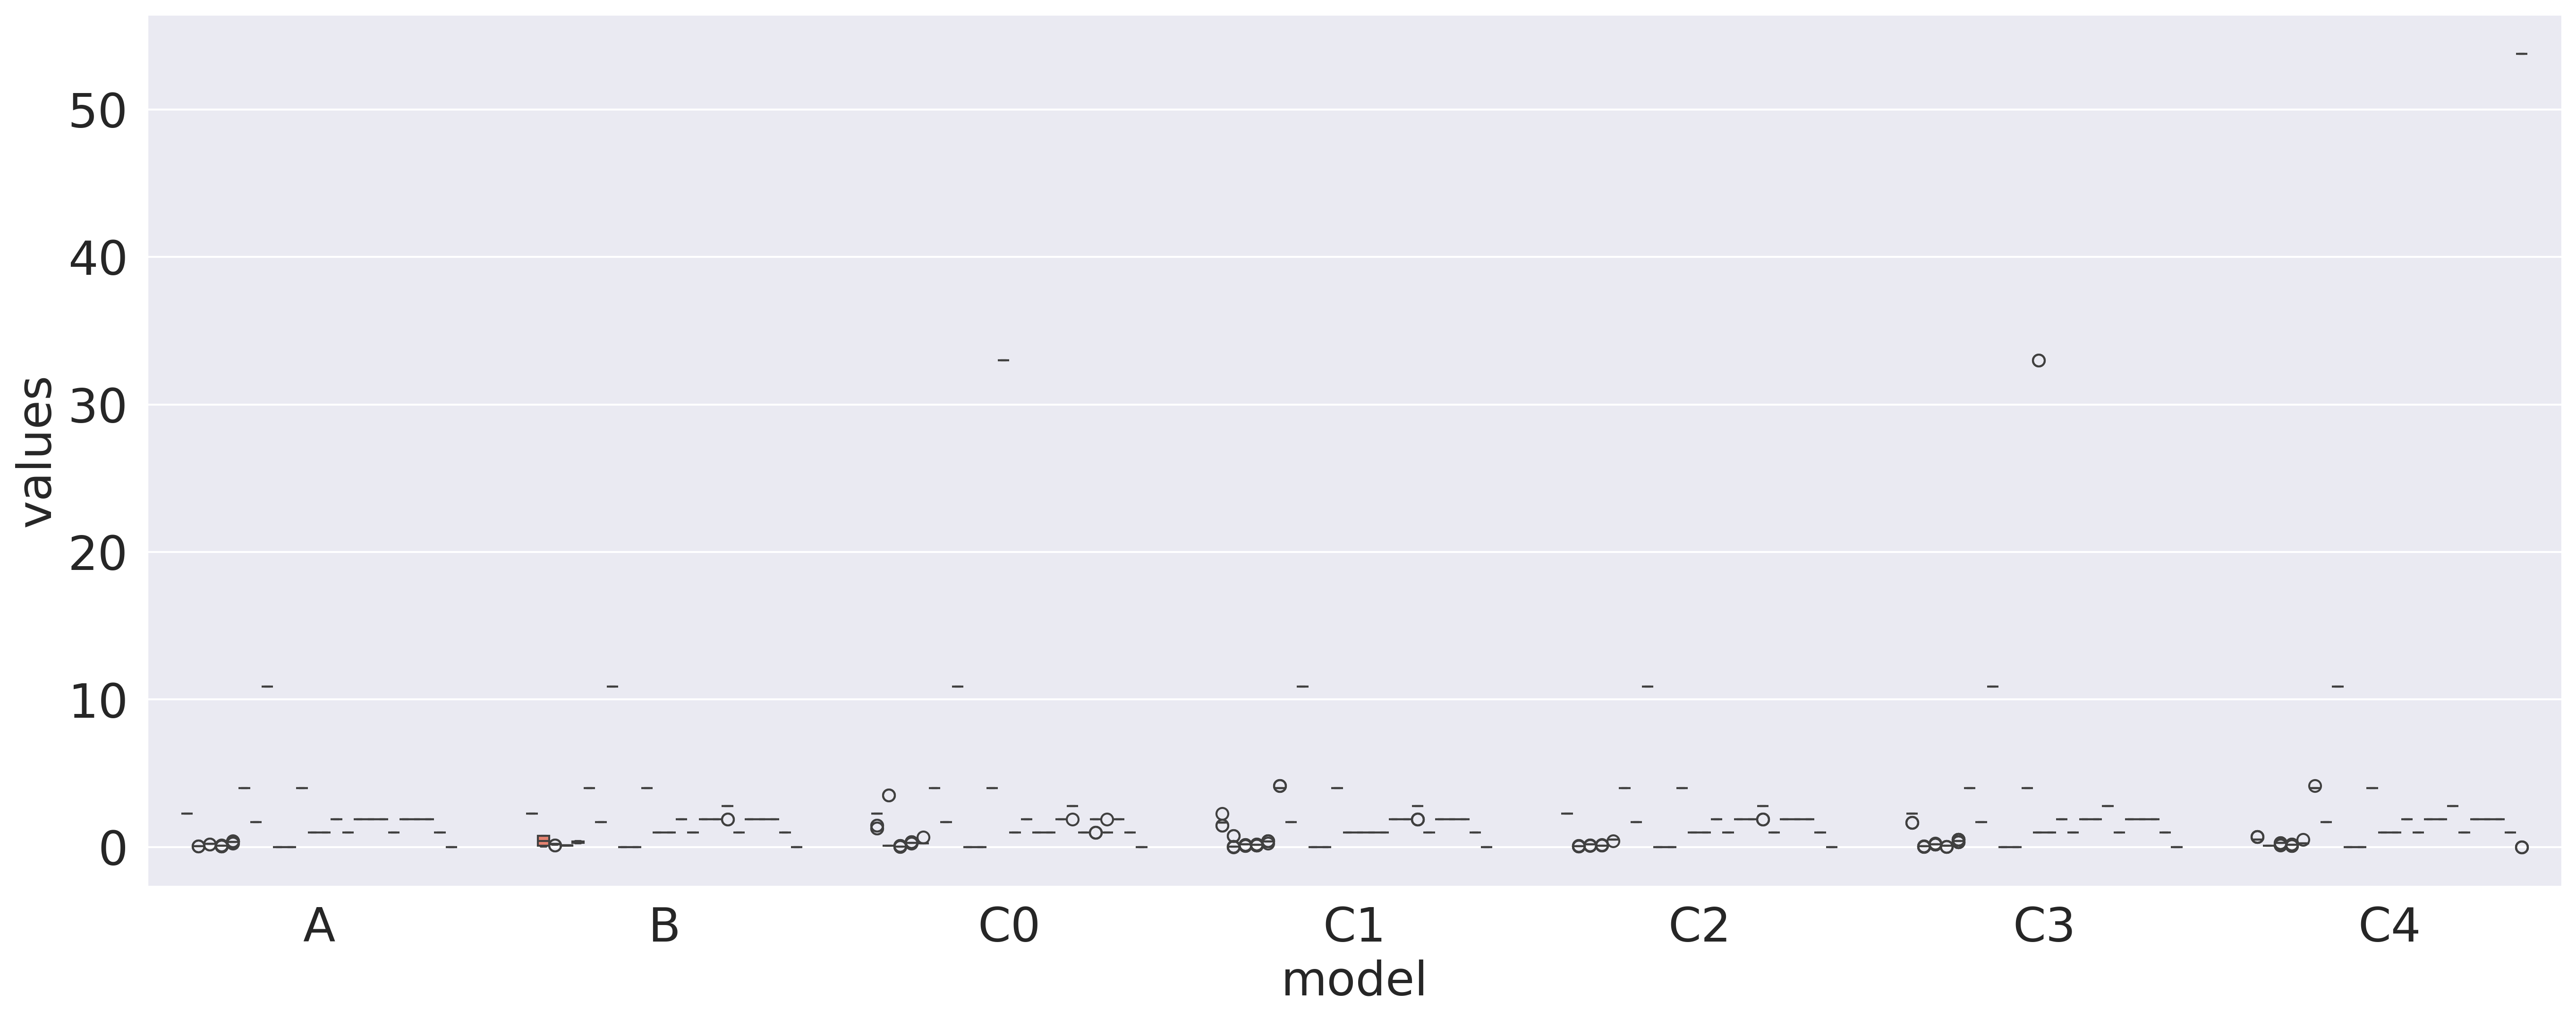

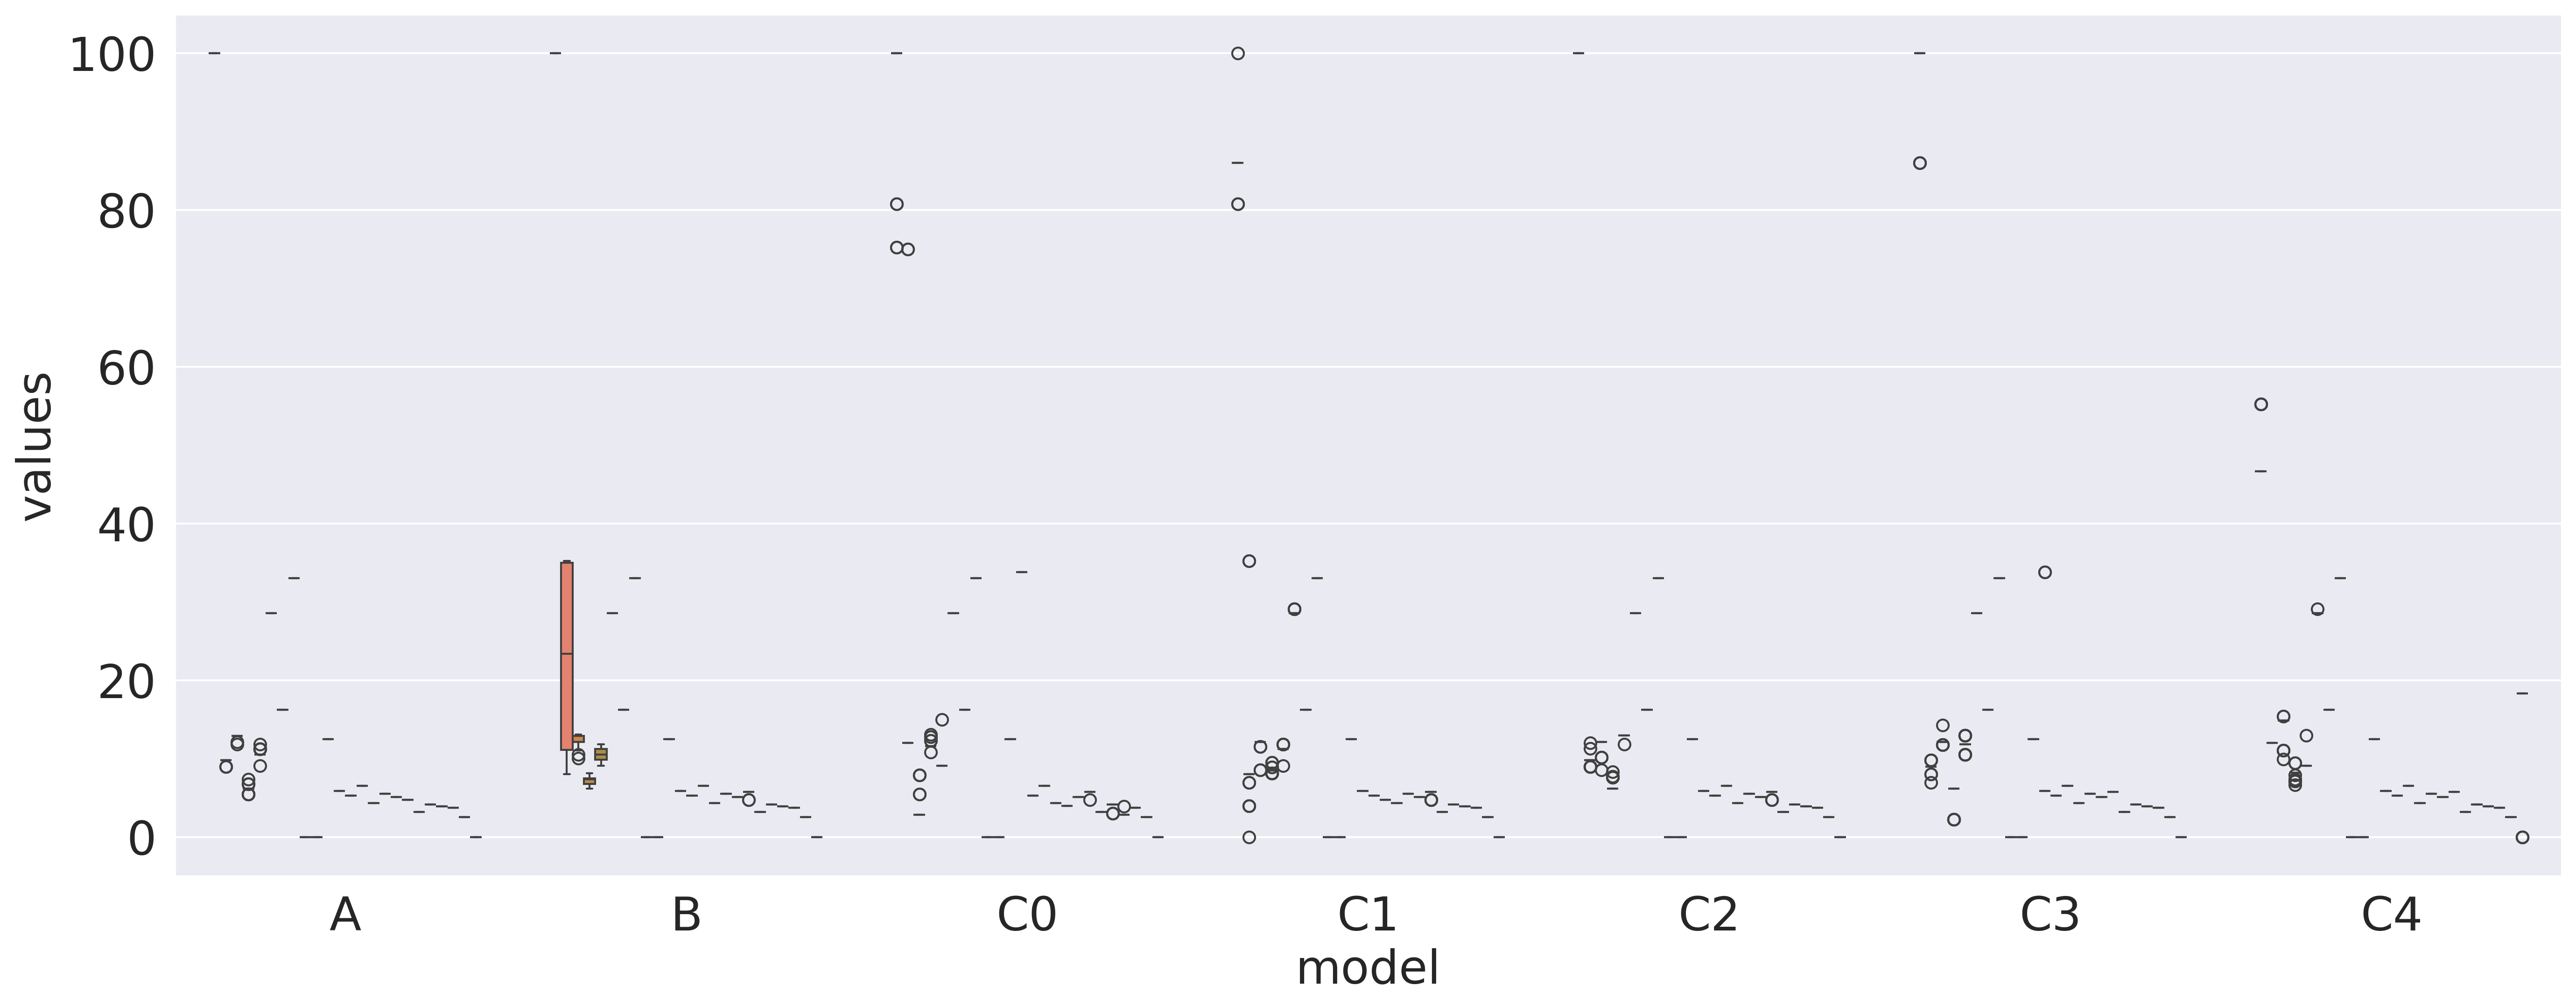

{
    'A': 'All data (25471)',
    'B': 'CCSampling(290)',
    'C0': '1.60e-02 <= y_loss_f <= 1.61e-02 (156)',
    'C1': '1.80e-02 <= y_loss_f <= 1.80e-02 (346)',
    'C2': '2.00e-02 <= y_loss_f <= 2.00e-02 (378)',
    'C3': '2.20e-02 <= y_loss_f <= 2.20e-02 (311)',
    'C4': '2.39e-02 <= y_loss_f <= 2.40e-02 (191)'
}

fit_time  score_time  test_r2 avg  test_neg_mean_squared_error avg  \
0    0.039800    0.034421     0.989396                        -1.687200   
1    0.038556    0.033849     0.989239                        -1.712178   
2    0.038704    0.034301     0.989368                        -1.691733   
3    0.037560    0.034383     0.989104                        -1.733689   
4    0.037650    0.034324     0.989364                        -1.692400   
..        ...         ...          ...                              ...   
219  0.019861    0.032874     0.975014                        -3.975689   
220  0.020802    0.032490     0.974975                        -3.981822   
221  0.020877    0.032575     0.974975                        -3.981822   
222  0.019901    0.032869     0.974975                        -3.981822   
223  0.018743    0.032487     0.974970                        -3.982667   

     test_r2_0.0  test_r2_1.5  test_r2_2.5  test_r2_3.5  test_r2_4.5  \
0            0.0          0.0          0.0          0.0          0.0   
1            0.0          0.0          0.0          0.0          0.0   
2            0.0          0.0          0.0          0.0          0.0   
3            0.0          0.0          0.0          0.0          0.0   
4            0.0          0.0          0.0          0.0          0.0   
..           ...          ...          ...          ...          ...   
219          0.0          0.0          0.0          0.0          0.0   
220          0.0          0.0          0.0          0.0          0.0   
221          0.0          0.0          0.0          0.0          0.0   
222          0.0          0.0          0.0          0.0          0.0   
223          0.0          0.0          0.0          0.0          0.0   

     test_r2_5.5  ...  test_abs_err_23.0  test_abs_err_25.0  \
0            0.0  ...                1.0           1.374369   
1            0.0  ...                1.0           1.374369   
2            0.0  ...                1.0           1.374369   
3            0.0  ...                1.0           1.374369   
4            0.0  ...                1.0           1.374369   
..           ...  ...                ...                ...   
219          0.0  ...                1.0           1.374369   
220          0.0  ...                1.0           1.374369   
221          0.0  ...                1.0           1.374369   
222          0.0  ...                1.0           1.374369   
223          0.0  ...                1.0           1.374369   

     test_abs_err_27.0  test_abs_err_29.0  test_abs_err_31.0  \
0             1.374369           1.374369                1.0   
1             1.374369           1.374369                1.0   
2             1.374369           1.374369                1.0   
3             1.374369           1.374369                1.0   
4             1.374369           1.374369                1.0   
..                 ...                ...                ...   
219           1.374369           1.666667                1.0   
220           1.374369           1.666667                1.0   
221           1.374369           1.666667                1.0   
222           1.374369           1.666667                1.0   
223           1.374369           1.666667                1.0   

     test_abs_err_33.0  test_abs_err_35.0  test_abs_err_37.0  \
0             1.374369           1.374369           1.374369   
1             1.374369           1.374369           1.374369   
2             1.374369           1.374369           1.374369   
3             1.374369           1.374369           1.374369   
4             1.374369           1.374369           1.374369   
..                 ...                ...                ...   
219           1.374369           1.374369           1.374369   
220           1.374369           1.374369           1.374369   
221           1.374369           1.374369           1.374369   
222           1.374369           1.374369           1.374369   
223      

In [24]:
test_feature("y_loss_f")

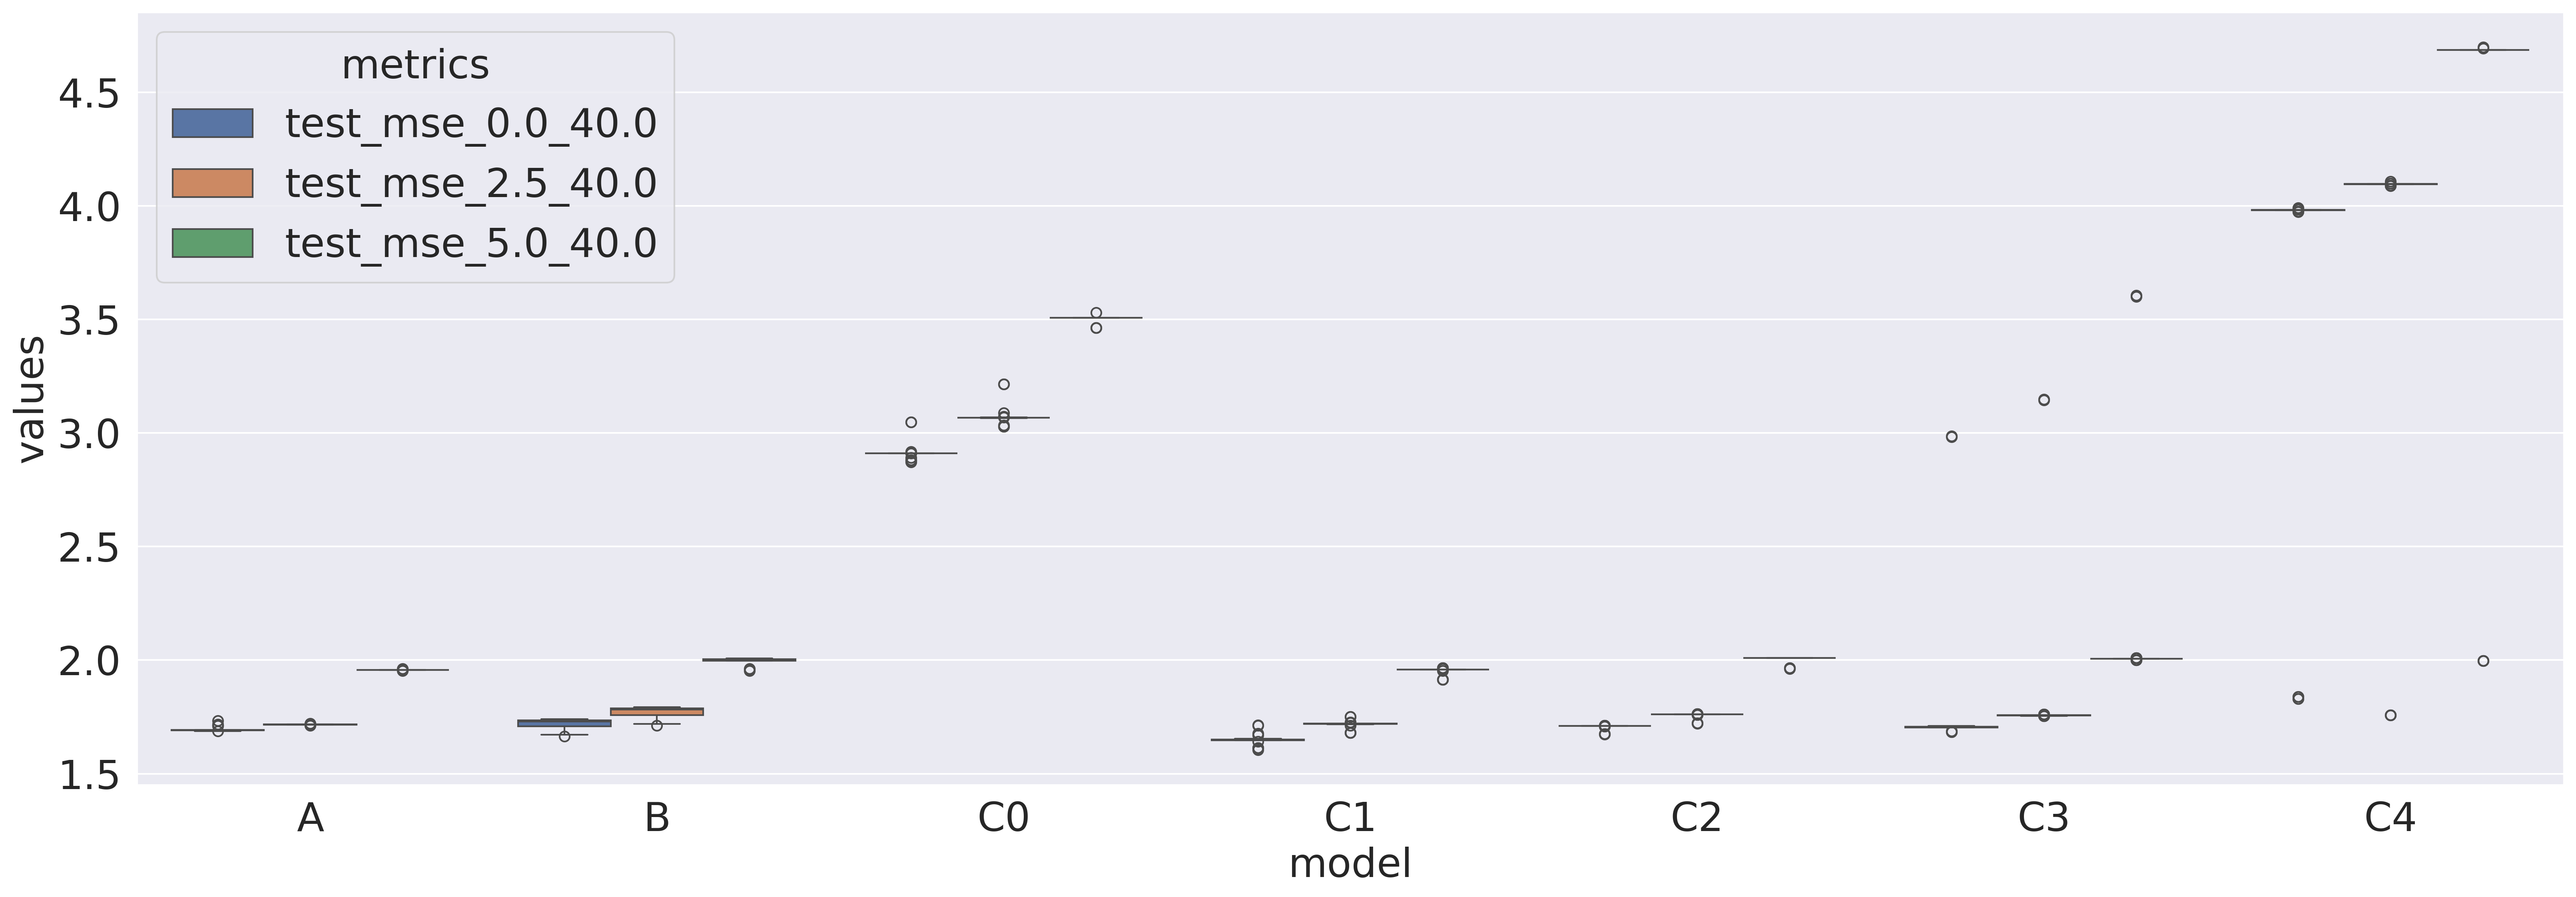

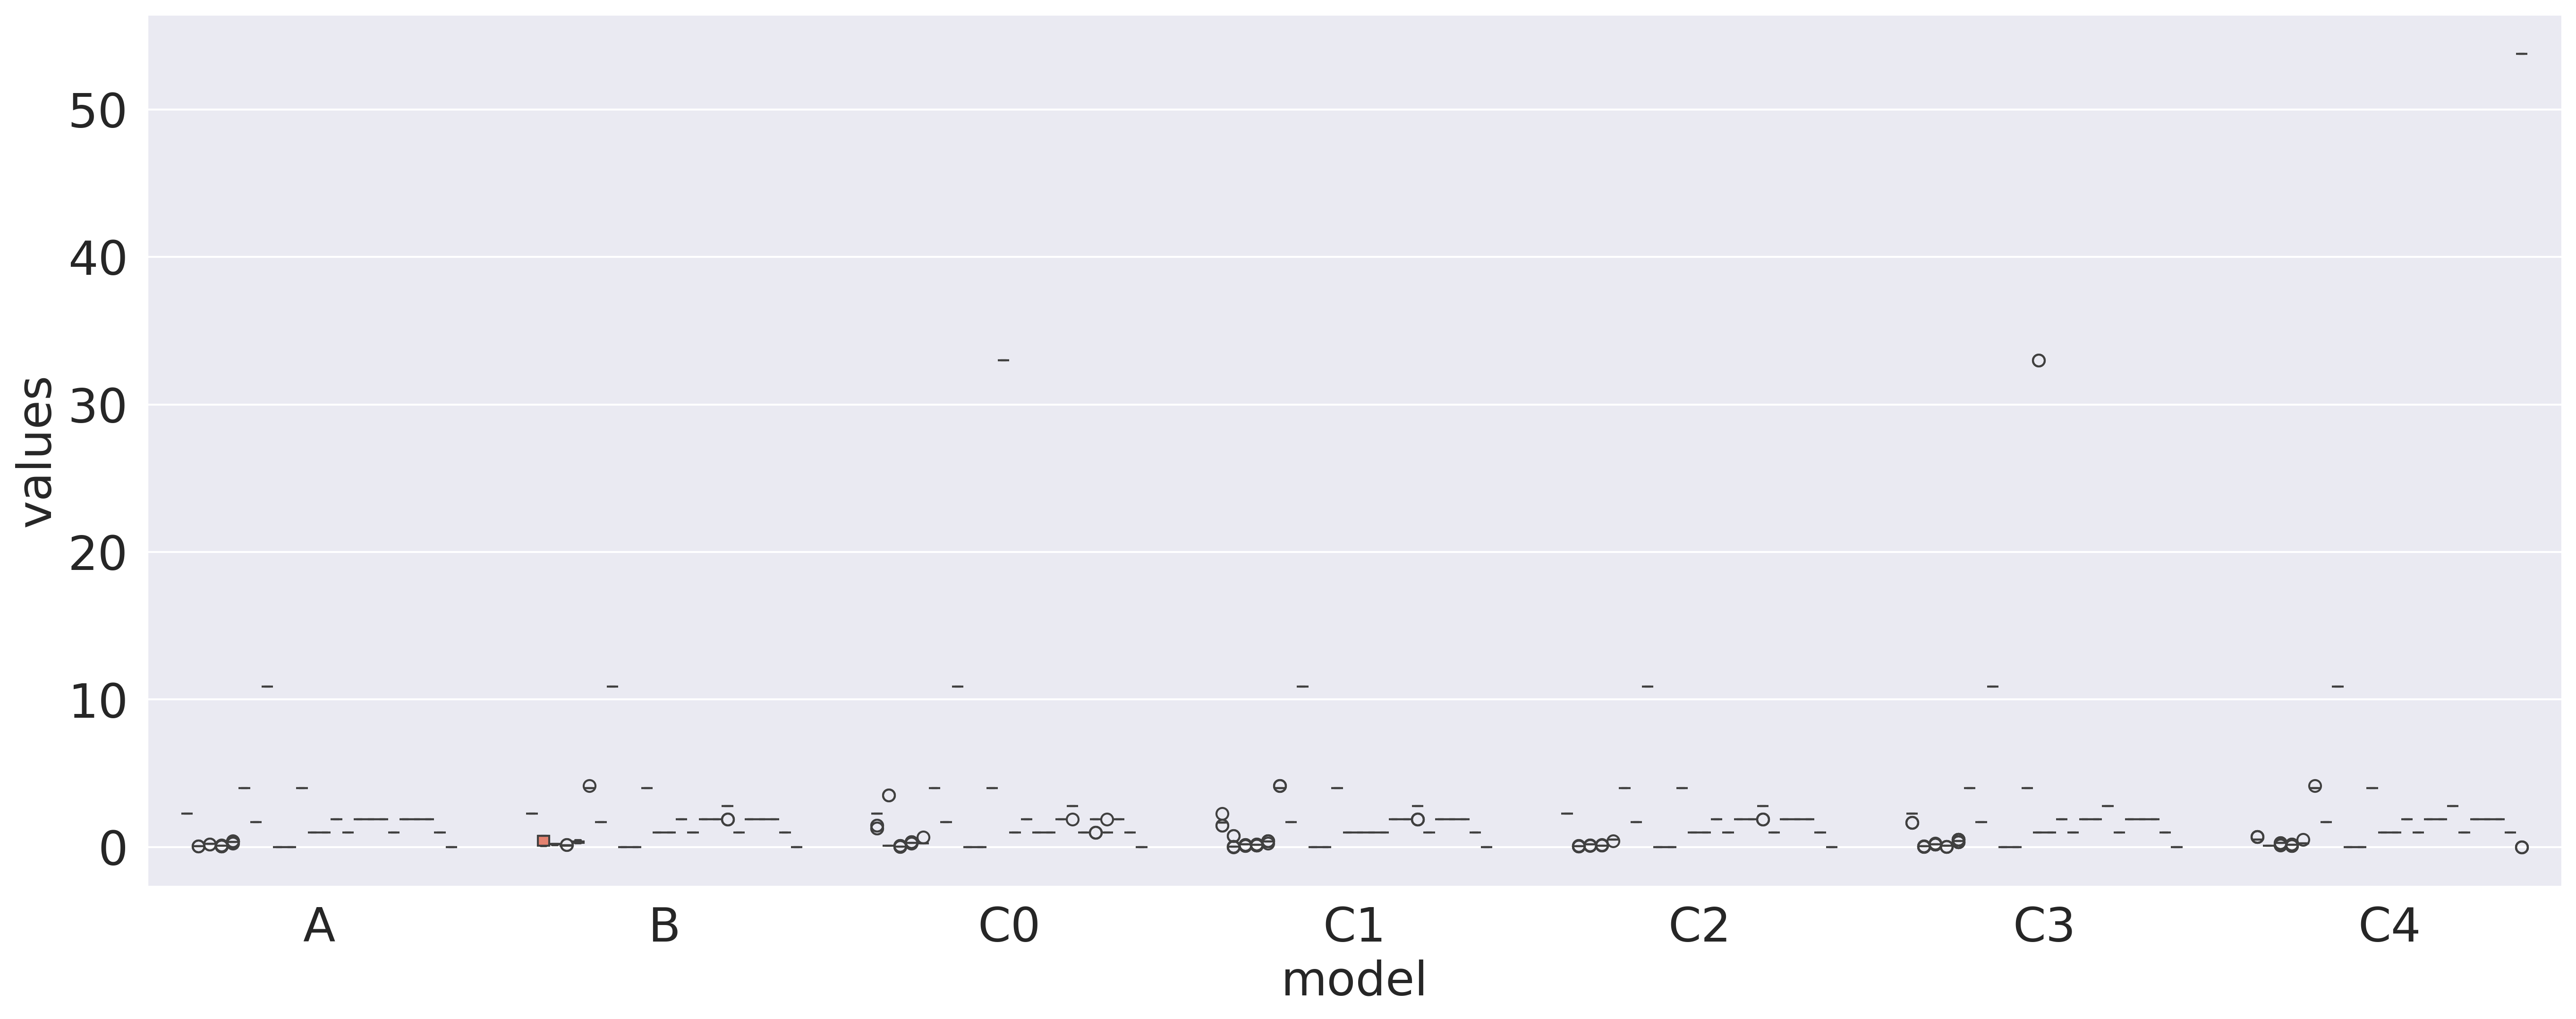

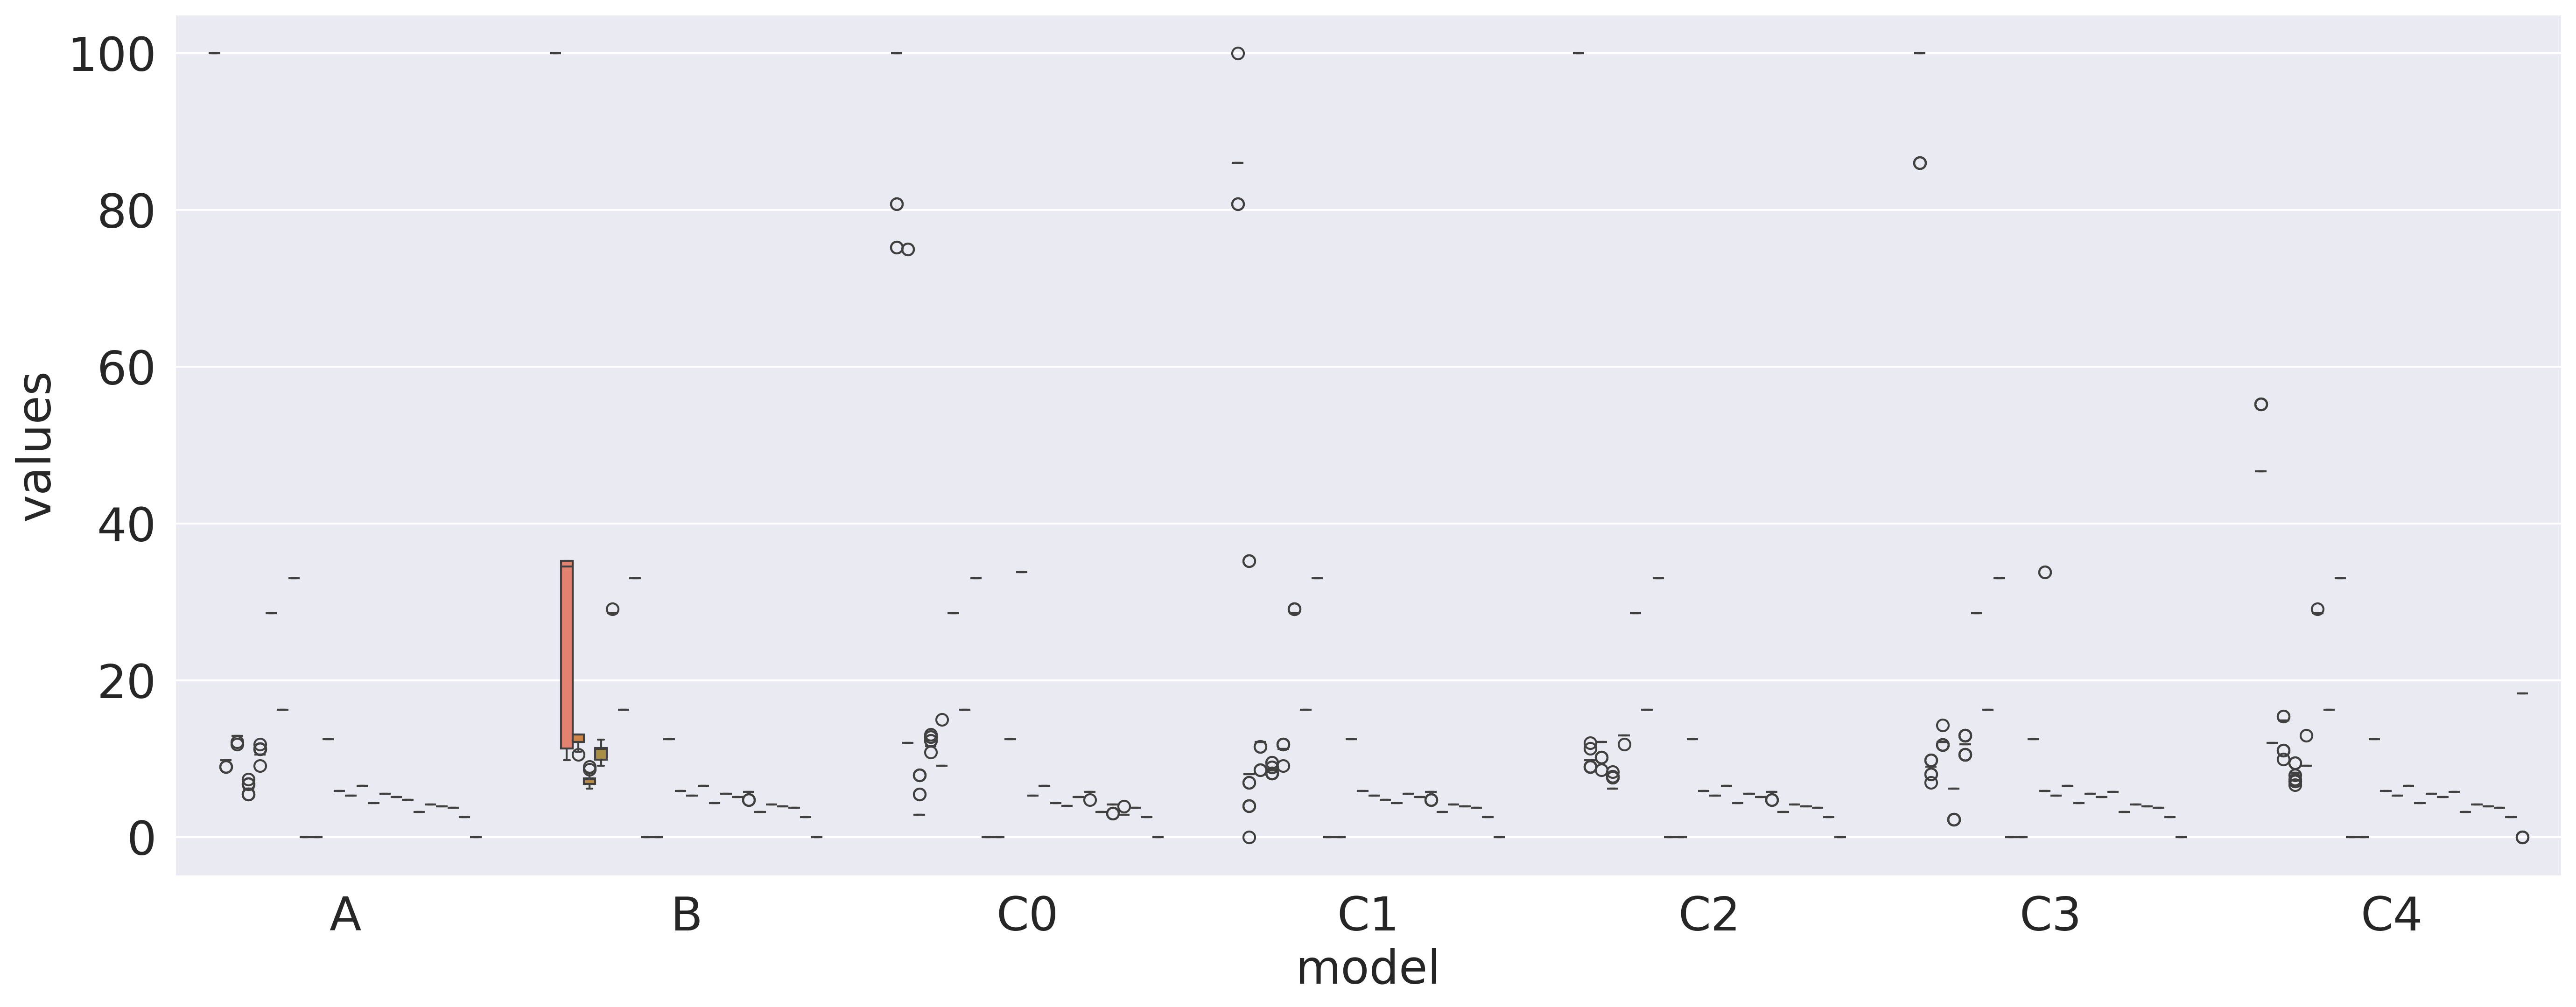

{
    'A': 'All data (25471)',
    'B': 'CCSampling(290)',
    'C0': '1.60e-02 <= y_loss_f <= 1.61e-02 (156)',
    'C1': '1.80e-02 <= y_loss_f <= 1.80e-02 (346)',
    'C2': '2.00e-02 <= y_loss_f <= 2.00e-02 (378)',
    'C3': '2.20e-02 <= y_loss_f <= 2.20e-02 (311)',
    'C4': '2.39e-02 <= y_loss_f <= 2.40e-02 (191)'
}

fit_time  score_time  test_r2 avg  test_neg_mean_squared_error avg  \
0    0.038774    0.033866     0.989396                        -1.687200   
1    0.041746    0.034014     0.989239                        -1.712178   
2    0.038202    0.033936     0.989368                        -1.691733   
3    0.037930    0.033864     0.989104                        -1.733689   
4    0.039285    0.035681     0.989364                        -1.692400   
..        ...         ...          ...                              ...   
219  0.019735    0.034469     0.975014                        -3.975689   
220  0.020606    0.032502     0.974975                        -3.981822   
221  0.021052    0.034307     0.974975                        -3.981822   
222  0.019989    0.032863     0.974975                        -3.981822   
223  0.018811    0.032315     0.974970                        -3.982667   

     test_r2_0.0  test_r2_1.5  test_r2_2.5  test_r2_3.5  test_r2_4.5  \
0            0.0          0.0          0.0          0.0          0.0   
1            0.0          0.0          0.0          0.0          0.0   
2            0.0          0.0          0.0          0.0          0.0   
3            0.0          0.0          0.0          0.0          0.0   
4            0.0          0.0          0.0          0.0          0.0   
..           ...          ...          ...          ...          ...   
219          0.0          0.0          0.0          0.0          0.0   
220          0.0          0.0          0.0          0.0          0.0   
221          0.0          0.0          0.0          0.0          0.0   
222          0.0          0.0          0.0          0.0          0.0   
223          0.0          0.0          0.0          0.0          0.0   

     test_r2_5.5  ...  test_abs_err_23.0  test_abs_err_25.0  \
0            0.0  ...                1.0           1.374369   
1            0.0  ...                1.0           1.374369   
2            0.0  ...                1.0           1.374369   
3            0.0  ...                1.0           1.374369   
4            0.0  ...                1.0           1.374369   
..           ...  ...                ...                ...   
219          0.0  ...                1.0           1.374369   
220          0.0  ...                1.0           1.374369   
221          0.0  ...                1.0           1.374369   
222          0.0  ...                1.0           1.374369   
223          0.0  ...                1.0           1.374369   

     test_abs_err_27.0  test_abs_err_29.0  test_abs_err_31.0  \
0             1.374369           1.374369                1.0   
1             1.374369           1.374369                1.0   
2             1.374369           1.374369                1.0   
3             1.374369           1.374369                1.0   
4             1.374369           1.374369                1.0   
..                 ...                ...                ...   
219           1.374369           1.666667                1.0   
220           1.374369           1.666667                1.0   
221           1.374369           1.666667                1.0   
222           1.374369           1.666667                1.0   
223           1.374369           1.666667                1.0   

     test_abs_err_33.0  test_abs_err_35.0  test_abs_err_37.0  \
0             1.374369           1.374369           1.374369   
1             1.374369           1.374369           1.374369   
2             1.374369           1.374369           1.374369   
3             1.374369           1.374369           1.374369   
4             1.374369           1.374369           1.374369   
..                 ...                ...                ...   
219           1.374369           1.374369           1.374369   
220           1.374369           1.374369           1.374369   
221           1.374369           1.374369           1.374369   
222           1.374369           1.374369           1.374369   
223      

In [25]:
result = test_feature("y_loss_f")
result

In [26]:
shm_scoring = SHM_Scoring()
res = extract_metrics(result, metrics=shm_scoring.REAL_MSE_RESULTS)
res

model        metrics     values
6720      A   test_mse_1.5   2.250000
6721      A   test_mse_1.5   2.250000
6722      A   test_mse_1.5   2.250000
6723      A   test_mse_1.5   2.250000
6724      A   test_mse_1.5   2.250000
...     ...            ...        ...
12091    C4  test_mse_40.0  53.777778
12092    C4  test_mse_40.0  53.777778
12093    C4  test_mse_40.0  53.777778
12094    C4  test_mse_40.0  53.777778
12095    C4  test_mse_40.0  53.777778

[5376 rows x 3 columns]

In [27]:
aggri = res.groupby(["model", "metrics"], group_keys=False).mean()
aggri

values
model metrics                 
A     test_mse_1.5    2.250000
      test_mse_10.0  10.890000
      test_mse_12.0   0.000000
      test_mse_14.0   0.000000
      test_mse_16.0   4.000000
...                        ...
C4    test_mse_4.5    0.133646
      test_mse_40.0  47.055556
      test_mse_5.5    0.258125
      test_mse_7.0    4.004479
      test_mse_8.0    1.690000

[168 rows x 1 columns]

In [28]:
from natsort import natsorted

pivot = aggri.reset_index().pivot(index="metrics", columns="model", values="values")
pivot = pivot.reindex(index=natsorted(pivot.index))
pivot.T

metrics  test_mse_1.5  test_mse_2.5  test_mse_3.5  test_mse_4.5  test_mse_5.5  \
model                                                                           
A            2.250000      0.059062      0.201597      0.077188      0.343437   
B            2.250000      0.484514      0.184965      0.106667      0.348854   
C0           2.140000      0.303889      0.017917      0.280104      0.263333   
C1           1.669444      0.081215      0.173264      0.146875      0.381354   
C2           2.250000      0.059687      0.172187      0.083854      0.507292   
C3           2.195000      0.049687      0.180937      0.066250      0.423333   
C4           0.514444      0.090000      0.255382      0.133646      0.258125   

metrics  test_mse_7.0  test_mse_8.0  test_mse_10.0  test_mse_12.0  \
model                                                               
A            4.000000          1.69          10.89            0.0   
B            4.004479          1.69          10.89            0.0   
C0           4.000000          1.69          10.89            0.0   
C1           4.013438          1.69          10.89            0.0   
C2           4.000000          1.69          10.89            0.0   
C3           4.000000          1.69          10.89            0.0   
C4           4.004479          1.69          10.89            0.0   

metrics  test_mse_14.0  ...  test_mse_23.0  test_mse_25.0  test_mse_27.0  \
model                   ...                                                
A                  0.0  ...            1.0       1.888889       1.888889   
B                  0.0  ...            1.0       1.888889       1.888889   
C0                 0.0  ...            1.0       1.000000       1.888889   
C1                 0.0  ...            1.0       1.888889       1.888889   
C2                 0.0  ...            1.0       1.888889       1.888889   
C3                 0.0  ...            1.0       1.888889       1.888889   
C4                 0.0  ...            1.0       1.888889       1.888889   

metrics  test_mse_29.0  test_mse_31.0  test_mse_33.0  test_mse_35.0  \
model                                                                 
A             1.888889            1.0       1.888889       1.888889   
B             2.694444            1.0       1.888889       1.888889   
C0            2.750000            1.0       1.805556       1.027778   
C1            2.666667            1.0       1.888889       1.888889   
C2            2.694444            1.0       1.888889       1.888889   
C3            2.777778            1.0       1.888889       1.888889   
C4            2.777778            1.0       1.888889       1.888889   

metrics  test_mse_37.0  test_mse_39.0  test_mse_40.0  
model                                                 
A             1.888889            1.0       0.000000  
B             1.888889            1.0       0.000000  
C0            1.888889            1.0       0.000000  
C1            1.888889            1.0       0.000000  
C2            1.888889            1.0       0.000000  
C3            1.888889            1.0       0.000000  
C4            1.888889            1.0      47.055556  

[7 rows x 24 columns]

<Axes: xlabel='metrics'>

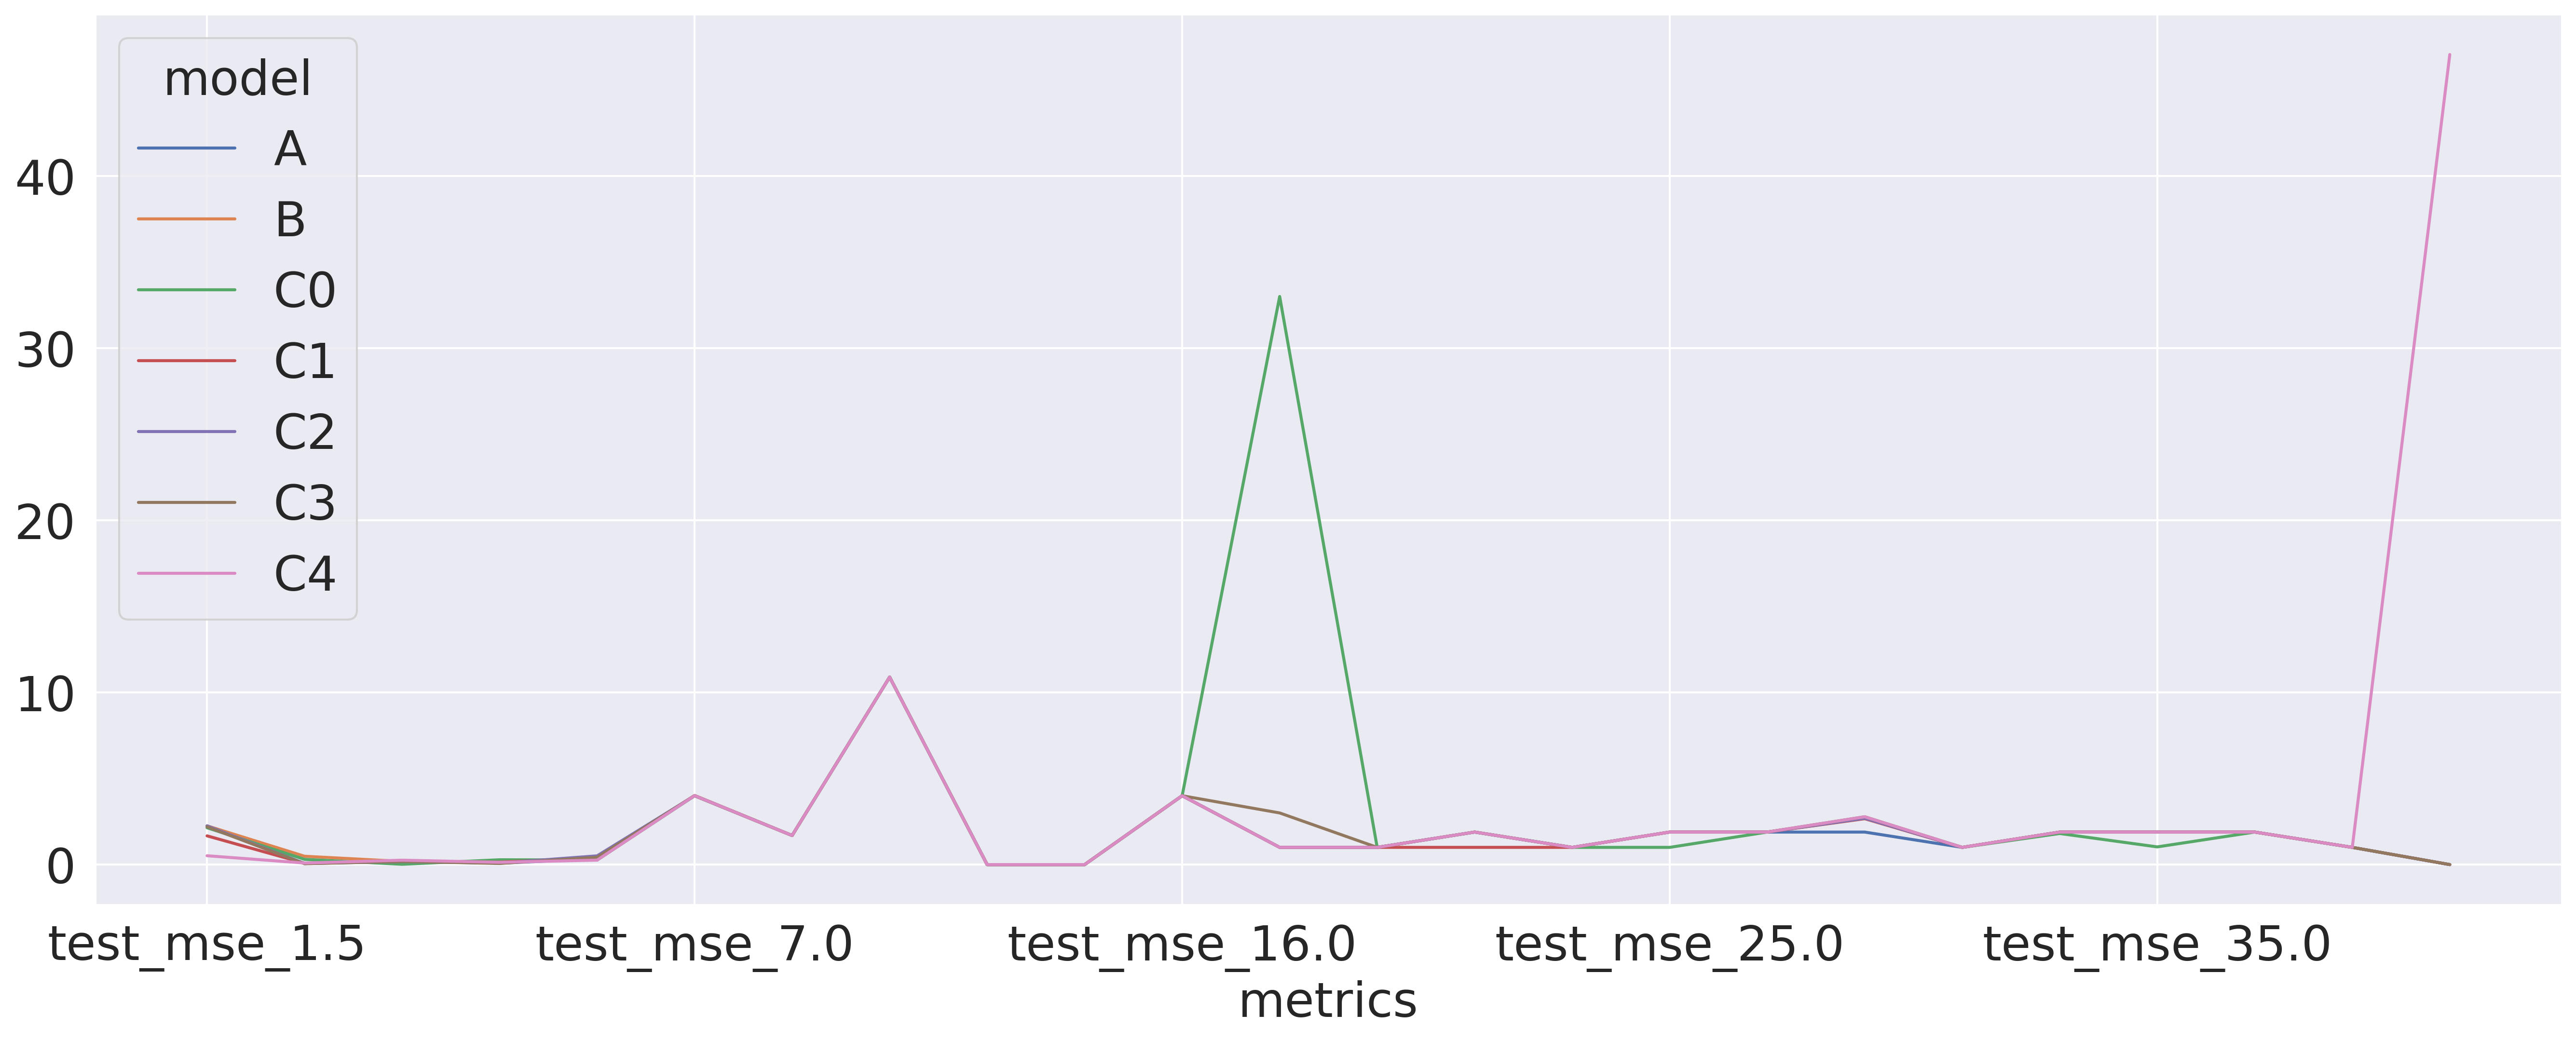

In [29]:
pivot.plot()

In [30]:
def test_sampler_filter(n_subgroups=5, samples_per_class=10):
    models = []
    labels = {}

    n_train_samples = int(Xsyn.shape[0] * 0.9)
    pipeline = build_pipeline()
    models.append([("A", pipeline)])
    labels["A"] = f"All data ({n_train_samples})"

    n_classes = len(np.unique(ysyn))
    strgy = dict(zip(range(n_classes), [samples_per_class] * n_classes))
    sampler = ClusterCentroids(
        estimator=KMeans(n_init="auto"),
        sampling_strategy=strgy,
        random_state=random_state,
    )
    estimator = KNeighborsRegressor(n_neighbors=1, leaf_size=1)
    pipeline = build_sampled_pipeline(sampler, estimator)
    models.append([("B", pipeline)])
    labels["B"] = f"CCSampling({samples_per_class * n_classes})"

    slices = dict(
        y_sdv_fl=4,
        y_sdv_core=0,
        y_dens_core=1,
        y_young_fl=0,
        y_dc=0,
        y_pcf=0,
        y_ec_pwas=0,
        y_loss_f=2,
    )
    fparams = []
    for feat in FEATURE_LIST[6:]:
        value_min = feat_data[feat].min()
        value_max = feat_data[feat].max()
        gap = (value_max - value_min) / (n_subgroups)

        value_min += gap * slices[feat]
        value_max = value_min + gap * 2

        fparams.append(dict(filter_tag=feat, min_value=value_min, max_value=value_max))
    
    pipeline = build_filtered_pipeline(fparams, random_state=None)
    models.append([(f"C", pipeline)])
    labels[f"C"] = f"{fparams})"

    scoring = get_real_regression_scoring()
    X_sext = feat_data.copy()
    X_sext["X"] = list(Xsyn)

    X_rext = pd.DataFrame(
        [["", -1, -1, -1, -1, -1, -1, -1, -1, -1]] * len(Xreal), columns=FEATURE_LIST
    )
    X_rext["X"] = list(Xreal)

    results = conduct_ab_mixed_reg_experiment(
        Xsyn=X_sext,
        ysyn=ysyn,
        Xreal=X_rext,
        yreal=yreal,
        estimators=models,
        n_splits=32,
        test_size=0.1,
        scoring=scoring,
        random_state=random_state,
    )

    plot_metrics(
        extract_metrics(
            results, ["test_mse_0.0_40.0", "test_mse_2.5_40.0", "test_mse_5.0_40.0"]
        )
    )
    plt.tight_layout()
    plt.show()

    shm_scoring = SHM_Scoring()
    plot_metrics(extract_metrics(results, shm_scoring.REAL_MSE_RESULTS))
    plt.gca().get_legend().remove()
    plt.show()

    plot_metrics(extract_metrics(results, shm_scoring.REAL_REL_ERROR))
    plt.gca().get_legend().remove()
    plt.show()

    print(labels)
    return results

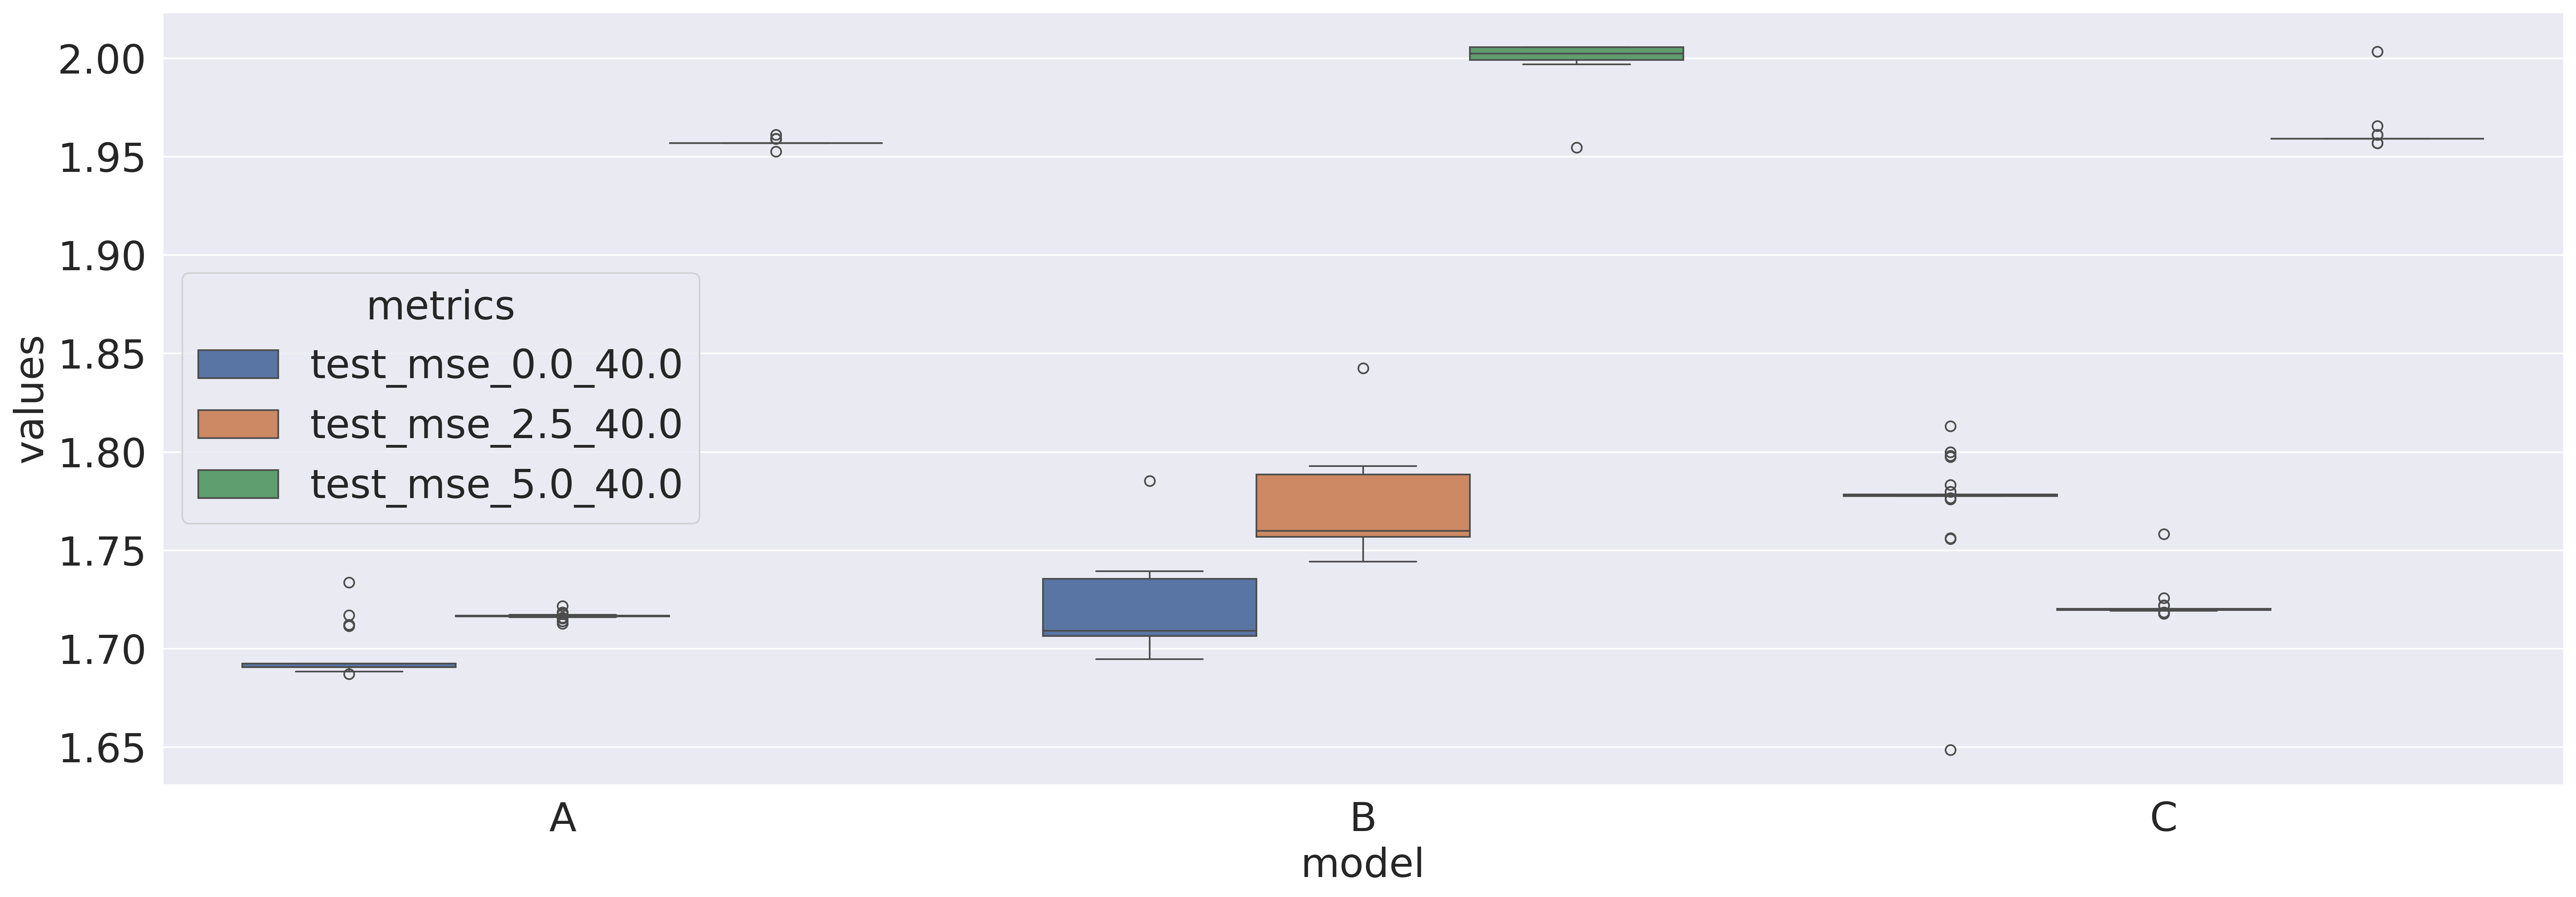

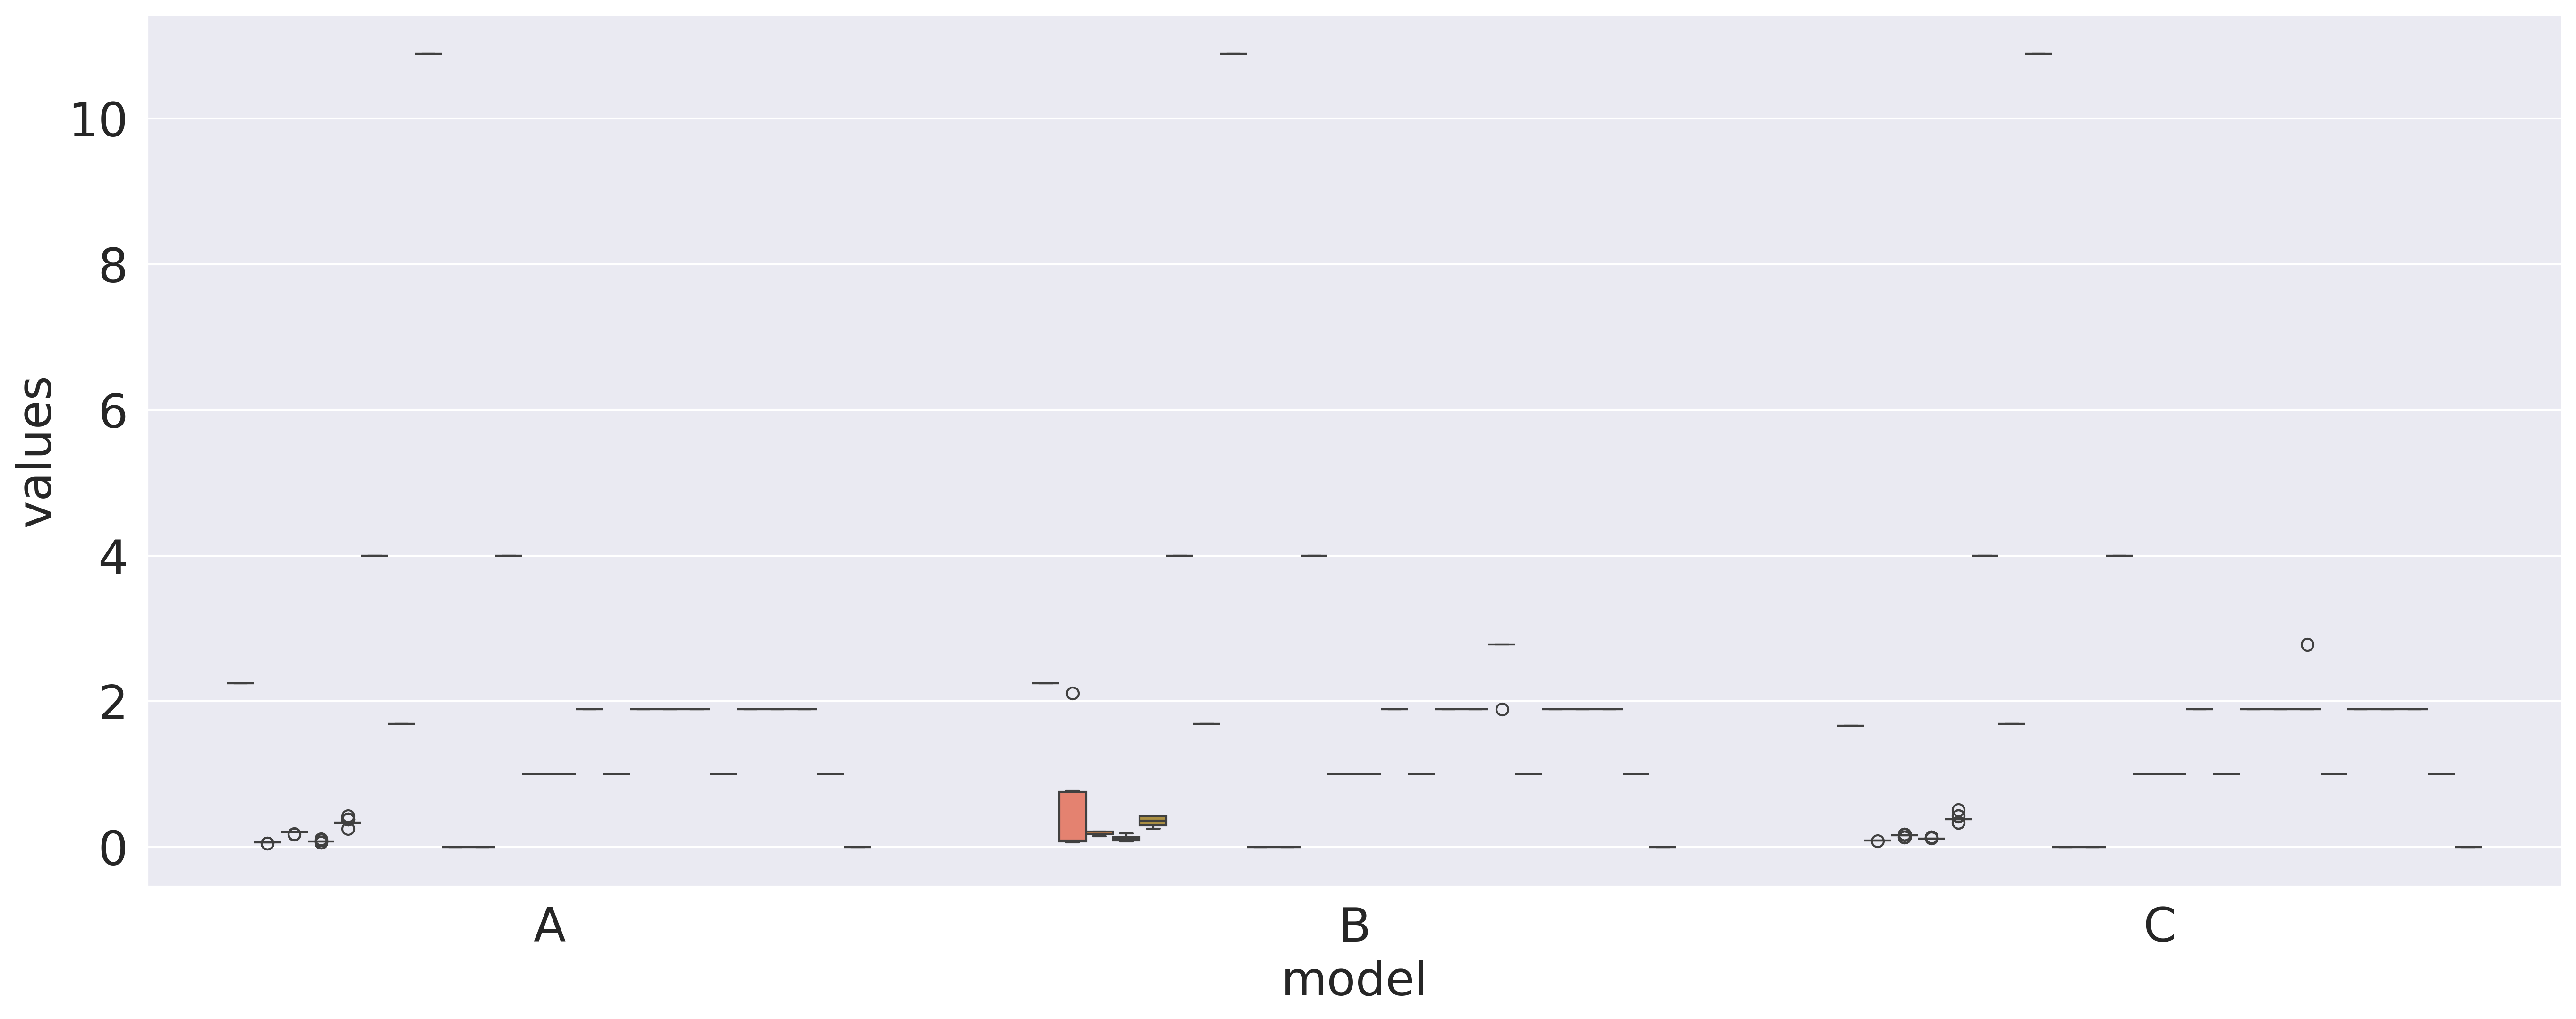

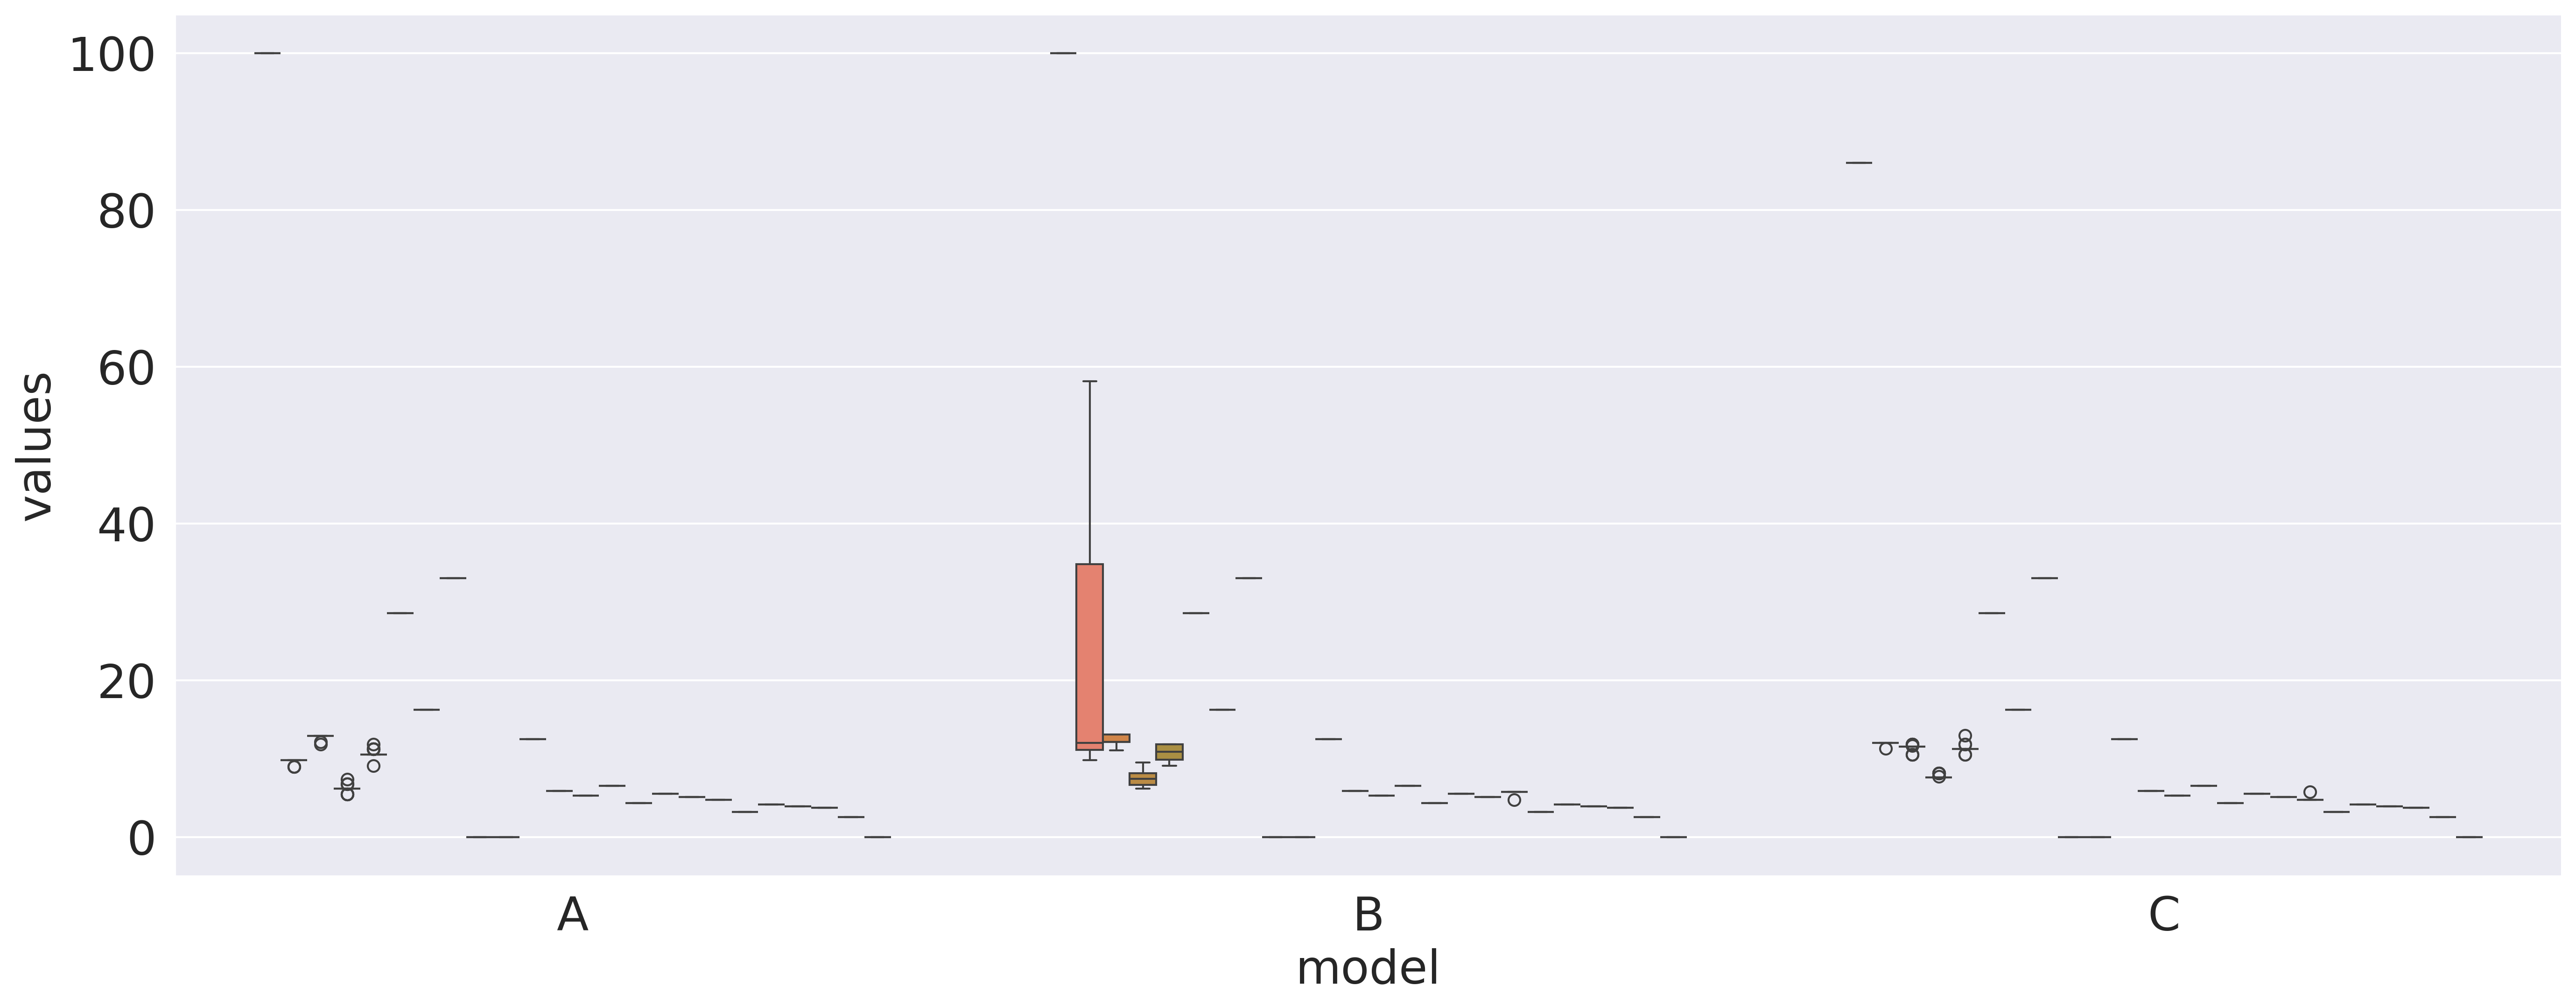

{
    'A': 'All data (25471)',
    'B': 'CCSampling(290)',
    'C': "[{'filter_tag': 'y_dc', 'min_value': 0.9502999782562256, 'max_value': 0.9901000022888183}, {'filter_tag':
'y_pcf', 'min_value': 0.9502999782562256, 'max_value': 0.9900599956512451}, {'filter_tag': 'y_ec_pwas', 
'min_value': 0.9502999782562256, 'max_value': 0.9900599956512451}, {'filter_tag': 'y_loss_f', 'min_value': 
0.019200000539422037, 'max_value': 0.022400000318884852}])"
}

fit_time  score_time  test_r2 avg  test_neg_mean_squared_error avg  \
0   0.042049    0.036062     0.989396                        -1.687200   
1   0.039904    0.046412     0.989239                        -1.712178   
2   0.040246    0.033922     0.989368                        -1.691733   
3   0.041466    0.035665     0.989104                        -1.733689   
4   0.037845    0.046682     0.989364                        -1.692400   
..       ...         ...          ...                              ...   
91  0.030466    0.033135     0.988828                        -1.777644   
92  0.030745    0.032594     0.988814                        -1.779867   
93  0.031619    0.032859     0.988824                        -1.778311   
94  0.030927    0.033057     0.988699                        -1.798089   
95  0.029980    0.032636     0.988965                        -1.755867   

    test_r2_0.0  test_r2_1.5  test_r2_2.5  test_r2_3.5  test_r2_4.5  \
0           0.0          0.0          0.0          0.0          0.0   
1           0.0          0.0          0.0          0.0          0.0   
2           0.0          0.0          0.0          0.0          0.0   
3           0.0          0.0          0.0          0.0          0.0   
4           0.0          0.0          0.0          0.0          0.0   
..          ...          ...          ...          ...          ...   
91          0.0          0.0          0.0          0.0          0.0   
92          0.0          0.0          0.0          0.0          0.0   
93          0.0          0.0          0.0          0.0          0.0   
94          0.0          0.0          0.0          0.0          0.0   
95          0.0          0.0          0.0          0.0          0.0   

    test_r2_5.5  ...  test_abs_err_23.0  test_abs_err_25.0  test_abs_err_27.0  \
0           0.0  ...                1.0           1.374369           1.374369   
1           0.0  ...                1.0           1.374369           1.374369   
2           0.0  ...                1.0           1.374369           1.374369   
3           0.0  ...                1.0           1.374369           1.374369   
4           0.0  ...                1.0           1.374369           1.374369   
..          ...  ...                ...                ...                ...   
91          0.0  ...                1.0           1.374369           1.374369   
92          0.0  ...                1.0           1.374369           1.374369   
93          0.0  ...                1.0           1.374369           1.374369   
94          0.0  ...                1.0           1.374369           1.374369   
95          0.0  ...                1.0           1.374369           1.374369   

    test_abs_err_29.0  test_abs_err_31.0  test_abs_err_33.0  \
0            1.374369                1.0           1.374369   
1            1.374369                1.0           1.374369   
2            1.374369                1.0           1.374369   
3            1.374369                1.0           1.374369   
4            1.374369                1.0           1.374369   
..                ...                ...                ...   
91           1.374369                1.0           1.374369   
92           1.374369                1.0           1.374369   
93           1.374369                1.0           1.374369   
94           1.374369                1.0           1.374369   
95           1.374369                1.0           1.374369   

    test_abs_err_35.0  test_abs_err_37.0  test_abs_err_39.0  test_abs_err_40.0  
0            1.374369           1.374369                1.0                0.0  
1            1.374369           1.374369                1.0                0.0  
2            1.374369           1.374369                1.0                0.0  
3            1.374369           1.374369                1.0                0.0  
4            1.374369           1.374369                1.0                0.0  
..                ...                ...      

In [31]:
test_sampler_filter()